In [2]:
%pylab inline
import pandas as pd
import fastparquet 
import os,sys

Populating the interactive namespace from numpy and matplotlib


In [3]:
sys.path.insert(0,"/mnt/lanlep2019/src/main")

In [4]:
!ln -s /mnt/lanlep2019 ~/

In [5]:
os.chdir("/mnt/lanlep2019/")

In [6]:
!pwd

/mnt/lanlep2019


# once

In [7]:
!pip install hyperopt


    100% |████████████████████████████████| 122kB 3.3MB/s ta 0:00:01
    100% |████████████████████████████████| 829kB 1.6MB/s  eta 0:00:01
    100% |████████████████████████████████| 1.7MB 796kB/s  eta 0:00:01
    100% |████████████████████████████████| 419kB 3.1MB/s  eta 0:00:01
  Running setup.py bdist_wheel for future ... done
  Stored in directory: /home/hadoop/.cache/pip/wheels/0c/61/d2/d6b7317325828fbb39ee6ad559dbe4664d0896da4721bf379e
  Running setup.py bdist_wheel for networkx ... done
  Stored in directory: /home/hadoop/.cache/pip/wheels/68/f8/29/b53346a112a07d30a5a84d53f19aeadaa1a474897c0423af91
Successfully built future networkx
You are using pip version 9.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# data

In [8]:
import lightgbm as lgb

In [9]:
import data
import config

In [10]:
reload (data)

<module 'data' from '/mnt/lanlep2019/src/main/data.pyc'>

In [57]:
if 1:
    dataset=[]
    strategy = {'type':'rand', "fold":5}
    types=['kaggle','signal','kaggle2'] +['fwv','fwvext']+['fwvsoftmax','fwvdis','fwvdis2','fwvcos']+\
        ['fwvextsoftmax','fwvextdis','fwvextdis2','fwvextcos'] + ['fwvwholereg', 'fwvextwholereg']
    for offset in [0,37500, 75000,112500]:
        traintest = data.TrainTest('offset', offset=offset, types=types, transform=None, valid_strategy=strategy)
        dataset.append(traintest)

In [58]:
traintest.num_dataset()

5

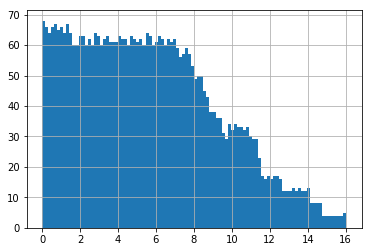

In [59]:
traintest.ydf.hist(bins=100);

In [43]:
np.abs(traintest.ydf-traintest.ydf.median()).mean()

3.0269177384241193

In [44]:
testdf=traintest.get_test_data()
testdf.shape

(2624, 450)

In [45]:
datadf=traintest.traindf
print datadf.shape
datadf.head()

(4173, 450)


mean         std     max     min  mean_change_abs  \
index                                                                  
quake_07_0405  4.622533    8.039286   251.0  -225.0         0.000033   
quake_07_0404  4.698080  112.349464  3449.0 -4482.0         0.000000   
quake_07_0159  4.141493    6.299701    94.0   -88.0         0.000007   
quake_07_0158  4.213913    5.103794    74.0  -100.0         0.000007   
quake_07_0401  4.225953    9.060598   192.0  -187.0         0.000053   

               mean_change_rate  abs_max  abs_min  std_first_50000  \
index                                                                
quake_07_0405      74755.976562    251.0      0.0         9.125431   
quake_07_0404      75871.375000   4482.0      0.0         5.712538   
quake_07_0159      75029.250000     94.0      0.0         6.280901   
quake_07_0158      75054.703125    100.0      0.0         5.603437   
quake_07_0401      75040.554688    192.0      0.0        10.612083   

               std_last_50000       ...         fwvextdis_pca10_2  \
index                               ...                             
quake_07_0405        7.902864       ...                  1.639194   
quake_07_0404       19.754288       ...                  4.808527   
quake_07_0159        6.027854       ...                  1.115260   
quake_07_0158        4.809473       ...                 -0.297501   
quake_07_0401        8.404730       ...                  2.205336   

               fwvextdis_pca10_3  fwvextdis_pca10_4  fwvextdis_pca10_5  \
index                                                                    
quake_07_0405           0.764217           0.218432          -0.007813   
quake_07_0404          -0.136472           0.502663           0.043488   
quake_07_0159           0.024505          -0.018302           0.079228   
quake_07_0158           0.168670           0.046252           0.023976   
quake_07_0401          -0.238119           0.012878           0.042690   

               fwvextdis_pca10_6  fwvextdis_pca10_7  fwvextdis_pca10_8  \
index                                                                    
quake_07_0405          -0.049034           0.021029           0.005735   
quake_07_0404           0.232533           0.001565          -0.059937   
quake_07_0159          -0.015695           0.031201           0.059025   
quake_07_0158           0.010945          -0.032556           0.000104   
quake_07_0401           0.015470          -0.028627           0.035620   

               fwvextdis_pca10_9  fwv_wholereg  fwvext_wholereg  
index                                                            
quake_07_0405           0.010838     77.421213        17.153645  
quake_07_0404          -0.009788    161.565558       119.035729  
quake_07_0159          -0.010276     -5.112977       -36.161473  
quake_07_0158          -0.003408     82.318870        33.999219  
quake_07_0401           0.040694      0.290691       -36.192186  

[5 rows x 450 columns]

In [18]:
import utils
n_thread= utils.get_num_thread()
n_thread

15

In [19]:
from hyperopt import fmin, tpe, hp


In [ ]:
removed=[]

In [84]:
def train_quake(traintest, fold,params,n_thread):
    
    Xtr,ytr,Xte,yte=traintest.get_train_data(fold)
    Xtr,ytr,Xte,yte=[u.values for u in [Xtr,ytr,Xte,yte]]
    print Xtr.shape,ytr.shape,Xte.shape,yte.shape
    if removed:
        Xtr[:,removed]=0
        Xte[:,removed]=0
    model = lgb.LGBMRegressor(n_estimators = 5000, n_jobs = n_thread, **params)
    model.fit(Xtr, ytr, sample_weight=None,
                    eval_set=[(Xtr, ytr), (Xte, yte)], eval_metric='mae', eval_sample_weight=None,
                    verbose=100, early_stopping_rounds=100)
    return model.best_score['valid_1']['l1'], model.best_iteration

In [48]:
params = {'num_leaves': 54,
          'min_data_in_leaf': 79,
          'objective': 'mae',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501
         }

In [49]:
best_mae=1e10

In [64]:
def lgbcv(learning_rate, num_leaves,reg_alpha,reg_lambda,max_depth,subsample,colsample_bytree, min_data_in_leaf,min_sum_hessian_in_leaf):
    d=locals()
    newparams=params.copy()
    newparams.update(d)    
    newparams['num_leaves']=int(num_leaves)
    newparams['max_depth']=int(max_depth)
    newparams['min_data_in_leaf']=int(min_data_in_leaf)
    scores=[]
    for traintest in dataset:
        for fold in range(5):
            s=train_quake(traintest, fold,newparams,n_thread)
            print "fold ", fold,s
            scores.append(s[0])
    r=np.mean(scores)
    global best_mae
    if best_mae>r: best_mae=r
    print "AAA, mean score", r, best_mae
    return r

In [65]:
space={
   'num_leaves': hp.uniform('num_leaves', 8,128 ),
    'reg_alpha':hp.loguniform('reg_alpha', np.log(0.01),np.log(10) ),
    'reg_lambda':hp.loguniform('reg_lambda', np.log(0.01),np.log(10) ),
    'max_depth':hp.uniform('max_depth',  3,12 ),
    'subsample':hp.uniform('subsample',  0.3,1 ),
    'colsample_bytree':hp.uniform('colsample_bytree',  0.3,1 ),
    'min_data_in_leaf':hp.loguniform('min_data_in_leaf', np.log(1),np.log(200) ),
    'min_sum_hessian_in_leaf':hp.loguniform('min_sum_hessian_in_leaf', np.log(1e-4),np.log(3) ),
    'learning_rate':hp.loguniform('learning_rate', np.log(1e-3),np.log(0.01) ),
}

In [66]:
def objective(args):
    print args
    return lgbcv(**args)



In [67]:
best = fmin(fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100)
print best

{'num_leaves': 60.08234368141781, 'reg_alpha': 2.918236416019113, 'colsample_bytree': 0.5047851370096611, 'min_sum_hessian_in_leaf': 0.0007950517311813728, 'learning_rate': 0.001623327998143825, 'subsample': 0.35313520995679815, 'reg_lambda': 1.1799851577913918, 'min_data_in_leaf': 5.006595576560673, 'max_depth': 3.620081401210768}
(3347, 450)                                          
(3347,)                                              
(837, 450)                                           
(837,)                                               
Training until validation scores don't improve for 100 rounds.
[100]	training's l1: 2.34454	valid_1's l1: 2.45264   
[200]	training's l1: 2.09555	valid_1's l1: 2.25101   
[300]	training's l1: 1.96325	valid_1's l1: 2.16043   
[400]	training's l1: 1.88707	valid_1's l1: 2.12479   
[500]	training's l1: 1.83507	valid_1's l1: 2.1076    
[600]	training's l1: 1.79218	valid_1's l1: 2.09996   
[700]	training's l1: 1.75379	valid_1's l1: 2.09219   
[800]	tra

[200]	training's l1: 2.11846	valid_1's l1: 2.16679   
[300]	training's l1: 1.98553	valid_1's l1: 2.06441   
[400]	training's l1: 1.90858	valid_1's l1: 2.02072   
[500]	training's l1: 1.85585	valid_1's l1: 2.00192   
[600]	training's l1: 1.81073	valid_1's l1: 1.98805   
[700]	training's l1: 1.77327	valid_1's l1: 1.98041   
[800]	training's l1: 1.74052	valid_1's l1: 1.9745    
[900]	training's l1: 1.70713	valid_1's l1: 1.97405   
Early stopping, best iteration is:                   
[888]	training's l1: 1.71075	valid_1's l1: 1.97299
fold                                                 
1                                                    
(1.9729869972030005, 888)                            
(3346, 450)                                          
(3346,)                                              
(836, 450)                                           
(836,)                                               
Training until validation scores don't improve for 100 rounds.
[100]	training's l1: 2

(3343,)                                              
(835, 450)                                           
(835,)                                               
Training until validation scores don't improve for 100 rounds.
[100]	training's l1: 2.36219	valid_1's l1: 2.38089   
[200]	training's l1: 2.11237	valid_1's l1: 2.18931   
[300]	training's l1: 1.97911	valid_1's l1: 2.10272   
[400]	training's l1: 1.90481	valid_1's l1: 2.06401   
[500]	training's l1: 1.85157	valid_1's l1: 2.04329   
[600]	training's l1: 1.80658	valid_1's l1: 2.0323    
[700]	training's l1: 1.77236	valid_1's l1: 2.02483   
[800]	training's l1: 1.73988	valid_1's l1: 2.01989   
[900]	training's l1: 1.7098	valid_1's l1: 2.01762    
[1000]	training's l1: 1.67859	valid_1's l1: 2.01768  
[1100]	training's l1: 1.64921	valid_1's l1: 2.01496  
[1200]	training's l1: 1.62063	valid_1's l1: 2.01361  
Early stopping, best iteration is:                   
[1186]	training's l1: 1.62485	valid_1's l1: 2.0129
fold                  

[1000]	training's l1: 1.68068	valid_1's l1: 2.00524  
[1100]	training's l1: 1.65239	valid_1's l1: 2.00164  
[1200]	training's l1: 1.62482	valid_1's l1: 2.00088  
[1300]	training's l1: 1.59746	valid_1's l1: 1.99847  
[1400]	training's l1: 1.57053	valid_1's l1: 1.99556  
[1500]	training's l1: 1.5443	valid_1's l1: 1.99402   
Early stopping, best iteration is:                   
[1448]	training's l1: 1.55798	valid_1's l1: 1.99319
fold                                                 
4                                                    
(1.9931856694147234, 1448)                           
AAA, mean score                                      
1.9918901849764734                                   
1.9918901849764734                                   
{'num_leaves': 122.6450208579993, 'reg_alpha': 0.1416483145275145, 'colsample_bytree': 0.6470886524157997, 'min_sum_hessian_in_leaf': 0.028262277700130043, 'learning_rate': 0.009221963586250785, 'subsample': 0.9488809306290351, 'reg_lambda': 0.02

(1.980180003568439, 113)                                                   
(3346, 450)                                                                
(3346,)                                                                    
(836, 450)                                                                 
(836,)                                                                     
Training until validation scores don't improve for 100 rounds.             
[100]	training's l1: 1.37191	valid_1's l1: 2.00709                         
[200]	training's l1: 1.07637	valid_1's l1: 2.00201                         
Early stopping, best iteration is:                                         
[167]	training's l1: 1.15851	valid_1's l1: 1.99564
fold                                                                       
3                                                                          
(1.995636717967172, 167)                                                   
(3346, 450)                          

(3338, 450)                                                                
(3338,)                                                                    
(835, 450)                                                                 
(835,)                                                                     
Training until validation scores don't improve for 100 rounds.             
[100]	training's l1: 1.37644	valid_1's l1: 1.95273                         
[200]	training's l1: 1.07666	valid_1's l1: 1.96261                         
Early stopping, best iteration is:                                         
[122]	training's l1: 1.29774	valid_1's l1: 1.94949
fold                                                                       
2                                                                          
(1.9494908547446528, 122)                                                  
(3339, 450)                                                                
(3339,)                              

[400]	training's l1: 1.58024	valid_1's l1: 2.03                          
[500]	training's l1: 1.45568	valid_1's l1: 2.00494                       
[600]	training's l1: 1.35389	valid_1's l1: 1.99228                       
[700]	training's l1: 1.26725	valid_1's l1: 1.98287                       
[800]	training's l1: 1.19096	valid_1's l1: 1.98055                       
[900]	training's l1: 1.12207	valid_1's l1: 1.97993                       
[1000]	training's l1: 1.05801	valid_1's l1: 1.97865                      
Early stopping, best iteration is:                                       
[953]	training's l1: 1.08758	valid_1's l1: 1.97647
fold                                                                     
3                                                                        
(1.9764692491646871, 953)                                                
(3348, 450)                                                              
(3348,)                                                      

Training until validation scores don't improve for 100 rounds.           
[100]	training's l1: 2.29192	valid_1's l1: 2.40789                       
[200]	training's l1: 1.94813	valid_1's l1: 2.19722                       
[300]	training's l1: 1.72119	valid_1's l1: 2.09954                       
[400]	training's l1: 1.56107	valid_1's l1: 2.06032                       
[500]	training's l1: 1.43649	valid_1's l1: 2.04229                       
[600]	training's l1: 1.33451	valid_1's l1: 2.03555                       
[700]	training's l1: 1.24964	valid_1's l1: 2.03188                       
[800]	training's l1: 1.1734	valid_1's l1: 2.02837                        
[900]	training's l1: 1.10519	valid_1's l1: 2.0286                        
Early stopping, best iteration is:                                       
[809]	training's l1: 1.1667	valid_1's l1: 2.02794
fold                                                                     
4                                                             

[300]	training's l1: 1.72254	valid_1's l1: 2.12894                       
[400]	training's l1: 1.56695	valid_1's l1: 2.08071                       
[500]	training's l1: 1.44989	valid_1's l1: 2.05454                       
[600]	training's l1: 1.35106	valid_1's l1: 2.04253                       
[700]	training's l1: 1.26457	valid_1's l1: 2.03803                       
[800]	training's l1: 1.18857	valid_1's l1: 2.03254                       
[900]	training's l1: 1.12182	valid_1's l1: 2.03195                       
[1000]	training's l1: 1.05991	valid_1's l1: 2.03389                      
Early stopping, best iteration is:                                       
[925]	training's l1: 1.10526	valid_1's l1: 2.02918
fold                                                                     
0                                                                        
(2.0291832290907412, 925)                                                
(3338, 450)                                                  

(3347, 450)                                                                
(3347,)                                                                    
(837, 450)                                                                 
(837,)                                                                     
Training until validation scores don't improve for 100 rounds.             
[100]	training's l1: 1.7466	valid_1's l1: 2.04114                          
[200]	training's l1: 1.49229	valid_1's l1: 2.01397                         
[300]	training's l1: 1.32109	valid_1's l1: 2.01685                         
Early stopping, best iteration is:                                         
[232]	training's l1: 1.43074	valid_1's l1: 2.01191
fold                                                                       
1                                                                          
(2.01190583987344, 232)                                                    
(3347, 450)                          

[200]	training's l1: 1.47225	valid_1's l1: 2.02663                         
Early stopping, best iteration is:                                         
[185]	training's l1: 1.50244	valid_1's l1: 2.02359
fold                                                                       
4                                                                          
(2.0235903919719513, 185)                                                  
(3342, 450)                                                                
(3342,)                                                                    
(836, 450)                                                                 
(836,)                                                                     
Training until validation scores don't improve for 100 rounds.             
[100]	training's l1: 1.72246	valid_1's l1: 2.10993                         
[200]	training's l1: 1.46911	valid_1's l1: 2.10045                         
[300]	training's l1: 1.30841	valid_1'

(1.9711011952493427, 203)                                                  
(3339, 450)                                                                
(3339,)                                                                    
(834, 450)                                                                 
(834,)                                                                     
Training until validation scores don't improve for 100 rounds.             
[100]	training's l1: 1.73533	valid_1's l1: 2.05713                         
[200]	training's l1: 1.48014	valid_1's l1: 2.0349                          
Early stopping, best iteration is:                                         
[147]	training's l1: 1.59057	valid_1's l1: 2.03037
fold                                                                       
3                                                                          
(2.0303657738677723, 147)                                                  
(3339, 450)                          

(837,)                                                                   
Training until validation scores don't improve for 100 rounds.           
[100]	training's l1: 1.5785	valid_1's l1: 2.02854                        
[200]	training's l1: 1.33785	valid_1's l1: 2.02025                       
Early stopping, best iteration is:                                       
[171]	training's l1: 1.40014	valid_1's l1: 2.00998
fold                                                                     
1                                                                        
(2.009978048858163, 171)                                                 
(3346, 450)                                                              
(3346,)                                                                  
(836, 450)                                                               
(836,)                                                                   
Training until validation scores don't improve for 100 rounds

Training until validation scores don't improve for 100 rounds.           
[100]	training's l1: 1.56164	valid_1's l1: 2.06625                       
[200]	training's l1: 1.32449	valid_1's l1: 2.04553                       
Early stopping, best iteration is:                                       
[193]	training's l1: 1.33626	valid_1's l1: 2.04185
fold                                                                     
0                                                                        
(2.0418549708927696, 193)                                                
(3338, 450)                                                              
(3338,)                                                                  
(835, 450)                                                               
(835,)                                                                   
Training until validation scores don't improve for 100 rounds.           
[100]	training's l1: 1.56673	valid_1's l1: 2.023             

fold                                                                     
3                                                                        
(2.017795107950316, 144)                                                 
(3348, 450)                                                              
(3348,)                                                                  
(836, 450)                                                               
(836,)                                                                   
Training until validation scores don't improve for 100 rounds.           
[100]	training's l1: 1.13807	valid_1's l1: 2.02708                       
[200]	training's l1: 0.556287	valid_1's l1: 2.01871                      
Early stopping, best iteration is:                                       
[126]	training's l1: 0.942852	valid_1's l1: 2.01107
fold                                                                     
4                                                           

(1.9475437376182985, 136)                                                
(3343, 450)                                                              
(3343,)                                                                  
(835, 450)                                                               
(835,)                                                                   
Training until validation scores don't improve for 100 rounds.           
[100]	training's l1: 1.12818	valid_1's l1: 2.05759                       
[200]	training's l1: 0.554089	valid_1's l1: 2.08003                      
Early stopping, best iteration is:                                       
[103]	training's l1: 1.10189	valid_1's l1: 2.05401
fold                                                                     
3                                                                        
(2.054006788248118, 103)                                                 
(3343, 450)                                                  

(837,)                                                                     
Training until validation scores don't improve for 100 rounds.             
[100]	training's l1: 2.15205	valid_1's l1: 2.38669                         
[200]	training's l1: 1.73286	valid_1's l1: 2.17484                         
[300]	training's l1: 1.45514	valid_1's l1: 2.07661                         
[400]	training's l1: 1.24555	valid_1's l1: 2.03535                         
[500]	training's l1: 1.116	valid_1's l1: 2.01491                           
[600]	training's l1: 1.03064	valid_1's l1: 2.00743                         
[700]	training's l1: 0.965598	valid_1's l1: 1.99969                        
[800]	training's l1: 0.905796	valid_1's l1: 1.99846                        
[900]	training's l1: 0.850268	valid_1's l1: 1.99333                        
[1000]	training's l1: 0.811838	valid_1's l1: 1.98853                       
[1100]	training's l1: 0.772406	valid_1's l1: 1.99015                       
Early stoppi

[200]	training's l1: 1.7396	valid_1's l1: 2.1282                           
[300]	training's l1: 1.45567	valid_1's l1: 2.03021                         
[400]	training's l1: 1.26347	valid_1's l1: 1.98965                         
[500]	training's l1: 1.1349	valid_1's l1: 1.97069                          
[600]	training's l1: 1.04736	valid_1's l1: 1.95705                         
[700]	training's l1: 0.976938	valid_1's l1: 1.95175                        
[800]	training's l1: 0.914504	valid_1's l1: 1.94966                        
[900]	training's l1: 0.862439	valid_1's l1: 1.94941                        
Early stopping, best iteration is:                                         
[854]	training's l1: 0.88514	valid_1's l1: 1.94772
fold                                                                       
2                                                                          
(1.9477170044603904, 854)                                                  
(3346, 450)                          

Training until validation scores don't improve for 100 rounds.             
[100]	training's l1: 2.15855	valid_1's l1: 2.3651                          
[200]	training's l1: 1.71762	valid_1's l1: 2.17873                         
[300]	training's l1: 1.42915	valid_1's l1: 2.0932                          
[400]	training's l1: 1.23115	valid_1's l1: 2.06843                         
[500]	training's l1: 1.11169	valid_1's l1: 2.05882                         
[600]	training's l1: 1.02893	valid_1's l1: 2.05383                         
[700]	training's l1: 0.96241	valid_1's l1: 2.05307                         
Early stopping, best iteration is:                                         
[632]	training's l1: 1.00884	valid_1's l1: 2.05125
fold                                                                       
3                                                                          
(2.051251742183793, 632)                                                   
(3343, 450)                          

[400]	training's l1: 1.22792	valid_1's l1: 2.0681                          
[500]	training's l1: 1.11049	valid_1's l1: 2.04978                         
[600]	training's l1: 1.02495	valid_1's l1: 2.03932                         
[700]	training's l1: 0.96174	valid_1's l1: 2.03542                         
[800]	training's l1: 0.905465	valid_1's l1: 2.03349                        
[900]	training's l1: 0.857685	valid_1's l1: 2.03524                        
Early stopping, best iteration is:                                         
[820]	training's l1: 0.895047	valid_1's l1: 2.0316
fold                                                                       
4                                                                          
(2.031596939983057, 820)                                                   
AAA, mean score                                                            
2.016759413835697                                                          
1.9918901849764734                   

Early stopping, best iteration is:                                         
[207]	training's l1: 0.685908	valid_1's l1: 1.99949
fold                                                                       
2                                                                          
(1.9994877327294223, 207)                                                  
(3346, 450)                                                                
(3346,)                                                                    
(836, 450)                                                                 
(836,)                                                                     
Training until validation scores don't improve for 100 rounds.             
[100]	training's l1: 0.882661	valid_1's l1: 2.05618                        
[200]	training's l1: 0.626984	valid_1's l1: 2.07289                        
Early stopping, best iteration is:                                         
[134]	training's l1: 0.76054	valid_1

(835, 450)                                                                 
(835,)                                                                     
Training until validation scores don't improve for 100 rounds.             
[100]	training's l1: 0.908711	valid_1's l1: 2.03914                        
[200]	training's l1: 0.676901	valid_1's l1: 2.05149                        
Early stopping, best iteration is:                                         
[100]	training's l1: 0.908711	valid_1's l1: 2.03914
fold                                                                       
2                                                                          
(2.0391389616852327, 100)                                                  
(3339, 450)                                                                
(3339,)                                                                    
(834, 450)                                                                 
(834,)                              

[300]	training's l1: 1.82506	valid_1's l1: 2.17437                         
[400]	training's l1: 1.63295	valid_1's l1: 2.09818                         
[500]	training's l1: 1.48399	valid_1's l1: 2.05104                         
[600]	training's l1: 1.37013	valid_1's l1: 2.02477                         
[700]	training's l1: 1.27923	valid_1's l1: 2.01276                         
[800]	training's l1: 1.20751	valid_1's l1: 2.00493                         
[900]	training's l1: 1.1495	valid_1's l1: 2.0064                           
Early stopping, best iteration is:                                         
[830]	training's l1: 1.18908	valid_1's l1: 2.00345
fold                                                                       
3                                                                          
(2.0034533617307644, 830)                                                  
(3348, 450)                                                                
(3348,)                              

Training until validation scores don't improve for 100 rounds.             
[100]	training's l1: 2.42342	valid_1's l1: 2.50258                         
[200]	training's l1: 2.07526	valid_1's l1: 2.28917                         
[300]	training's l1: 1.83192	valid_1's l1: 2.1668                          
[400]	training's l1: 1.63819	valid_1's l1: 2.09512                         
[500]	training's l1: 1.48847	valid_1's l1: 2.05414                         
[600]	training's l1: 1.37636	valid_1's l1: 2.03307                         
[700]	training's l1: 1.28439	valid_1's l1: 2.01891                         
[800]	training's l1: 1.21053	valid_1's l1: 2.01326                         
[900]	training's l1: 1.15389	valid_1's l1: 2.00739                         
[1000]	training's l1: 1.10413	valid_1's l1: 2.00622                        
[1100]	training's l1: 1.0607	valid_1's l1: 2.00502                         
Early stopping, best iteration is:                                         
[1068]	train

[600]	training's l1: 1.36986	valid_1's l1: 2.05192                         
[700]	training's l1: 1.28086	valid_1's l1: 2.03897                         
[800]	training's l1: 1.20953	valid_1's l1: 2.02852                         
[900]	training's l1: 1.14674	valid_1's l1: 2.02243                         
[1000]	training's l1: 1.10056	valid_1's l1: 2.02115                        
[1100]	training's l1: 1.06218	valid_1's l1: 2.01843                        
Early stopping, best iteration is:                                         
[1098]	training's l1: 1.06274	valid_1's l1: 2.01824
fold                                                                       
3                                                                          
(2.018239978114175, 1098)                                                  
(3343, 450)                                                                
(3343,)                                                                    
(835, 450)                          

[600]	training's l1: 1.36149	valid_1's l1: 2.05121                         
[700]	training's l1: 1.27242	valid_1's l1: 2.03475                         
[800]	training's l1: 1.20004	valid_1's l1: 2.03021                         
[900]	training's l1: 1.13867	valid_1's l1: 2.02707                         
Early stopping, best iteration is:                                         
[898]	training's l1: 1.13994	valid_1's l1: 2.0269
fold                                                                       
3                                                                          
(2.0269020828954982, 898)                                                  
(3339, 450)                                                                
(3339,)                                                                    
(834, 450)                                                                 
(834,)                                                                     
Training until validation scores don't

fold                                                                       
4                                                                          
(1.990195510841117, 450)                                                   
(3345, 450)                                                                
(3345,)                                                                    
(837, 450)                                                                 
(837,)                                                                     
Training until validation scores don't improve for 100 rounds.             
[100]	training's l1: 1.95749	valid_1's l1: 2.24727                         
[200]	training's l1: 1.62335	valid_1's l1: 2.09843                         
[300]	training's l1: 1.42442	valid_1's l1: 2.0637                          
[400]	training's l1: 1.28587	valid_1's l1: 2.05196                         
[500]	training's l1: 1.17267	valid_1's l1: 2.0415                          
[600]	traini

(1.993648945235762, 596)                                                   
(3342, 450)                                                                
(3342,)                                                                    
(836, 450)                                                                 
(836,)                                                                     
Training until validation scores don't improve for 100 rounds.             
[100]	training's l1: 1.99492	valid_1's l1: 2.13045                         
[200]	training's l1: 1.66503	valid_1's l1: 1.966                           
[300]	training's l1: 1.47203	valid_1's l1: 1.93142                         
[400]	training's l1: 1.33183	valid_1's l1: 1.92277                         
[500]	training's l1: 1.21455	valid_1's l1: 1.92608                         
Early stopping, best iteration is:                                         
[436]	training's l1: 1.2846	valid_1's l1: 1.92093
fold                                  

(834,)                                                                     
Training until validation scores don't improve for 100 rounds.             
[100]	training's l1: 1.96937	valid_1's l1: 2.23051                         
[200]	training's l1: 1.63975	valid_1's l1: 2.07612                         
[300]	training's l1: 1.44051	valid_1's l1: 2.02931                         
[400]	training's l1: 1.29756	valid_1's l1: 2.02064                         
[500]	training's l1: 1.18376	valid_1's l1: 2.01615                         
[600]	training's l1: 1.0896	valid_1's l1: 2.01538                          
Early stopping, best iteration is:                                         
[525]	training's l1: 1.15926	valid_1's l1: 2.01404
fold                                                                       
4                                                                          
(2.014038707240902, 525)                                                   
AAA, mean score                      

[300]	training's l1: 1.56995	valid_1's l1: 1.98939                          
[400]	training's l1: 1.47711	valid_1's l1: 1.98539                          
[500]	training's l1: 1.39289	valid_1's l1: 1.98539                          
[600]	training's l1: 1.32556	valid_1's l1: 1.98257                          
Early stopping, best iteration is:                                          
[583]	training's l1: 1.33699	valid_1's l1: 1.98139
fold                                                                        
1                                                                           
(1.9813871310424094, 583)                                                   
(3346, 450)                                                                 
(3346,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation

fold                                                                        
4                                                                           
(2.0416906583582026, 236)                                                   
(3338, 450)                                                                 
(3338,)                                                                     
(835, 450)                                                                  
(835,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.83185	valid_1's l1: 2.09338                          
[200]	training's l1: 1.65672	valid_1's l1: 2.04654                          
[300]	training's l1: 1.55217	valid_1's l1: 2.03052                          
Early stopping, best iteration is:                                          
[283]	training's l1: 1.56843	valid_1's l1: 2.0265
fold                      

[700]	training's l1: 1.03017	valid_1's l1: 2.00339                          
[800]	training's l1: 0.928815	valid_1's l1: 1.99909                         
[900]	training's l1: 0.841669	valid_1's l1: 1.99449                         
[1000]	training's l1: 0.765213	valid_1's l1: 1.99115                        
[1100]	training's l1: 0.696996	valid_1's l1: 1.98919                        
[1200]	training's l1: 0.635151	valid_1's l1: 1.98888                        
[1300]	training's l1: 0.579427	valid_1's l1: 1.98806                        
[1400]	training's l1: 0.527418	valid_1's l1: 1.98949                        
Early stopping, best iteration is:                                          
[1301]	training's l1: 0.57892	valid_1's l1: 1.98796
fold                                                                        
1                                                                           
(1.987960128085691, 1301)                                                   
(3347, 450)             

[800]	training's l1: 0.92367	valid_1's l1: 1.99116                          
[900]	training's l1: 0.834416	valid_1's l1: 1.98783                         
[1000]	training's l1: 0.757194	valid_1's l1: 1.9875                         
Early stopping, best iteration is:                                          
[957]	training's l1: 0.789135	valid_1's l1: 1.98584
fold                                                                        
1                                                                           
(1.9858416373890104, 957)                                                   
(3346, 450)                                                                 
(3346,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.3

[1200]	training's l1: 0.642103	valid_1's l1: 1.99221                        
[1300]	training's l1: 0.584153	valid_1's l1: 1.99109                        
Early stopping, best iteration is:                                          
[1232]	training's l1: 0.622839	valid_1's l1: 1.9906
fold                                                                        
1                                                                           
(1.990598280164062, 1232)                                                   
(3342, 450)                                                                 
(3342,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.35772	valid_1's l1: 2.46932                          
[200]	training's l1: 1.9

[500]	training's l1: 1.28994	valid_1's l1: 2.02298                          
[600]	training's l1: 1.14647	valid_1's l1: 2.00577                          
[700]	training's l1: 1.02887	valid_1's l1: 1.99376                          
[800]	training's l1: 0.927185	valid_1's l1: 1.99074                         
[900]	training's l1: 0.841519	valid_1's l1: 1.99067                         
Early stopping, best iteration is:                                          
[885]	training's l1: 0.853751	valid_1's l1: 1.98927
fold                                                                        
1                                                                           
(1.9892666654698203, 885)                                                   
(3338, 450)                                                                 
(3338,)                                                                     
(835, 450)                                                                  
(835,)                  

[200]	training's l1: 2.1041	valid_1's l1: 2.29626                            
[300]	training's l1: 1.88513	valid_1's l1: 2.17001                           
[400]	training's l1: 1.71928	valid_1's l1: 2.09596                           
[500]	training's l1: 1.58713	valid_1's l1: 2.05288                           
[600]	training's l1: 1.47809	valid_1's l1: 2.02957                           
[700]	training's l1: 1.38934	valid_1's l1: 2.01832                           
[800]	training's l1: 1.31412	valid_1's l1: 2.0115                            
[900]	training's l1: 1.25121	valid_1's l1: 2.00686                           
[1000]	training's l1: 1.19428	valid_1's l1: 2.00037                          
[1100]	training's l1: 1.14595	valid_1's l1: 2.00072                          
Early stopping, best iteration is:                                           
[1007]	training's l1: 1.19093	valid_1's l1: 2.00004
fold                                                                         
1           

fold                                                                         
0                                                                            
(2.048789048713743, 1362)                                                    
(3345, 450)                                                                  
(3345,)                                                                      
(837, 450)                                                                   
(837,)                                                                       
Training until validation scores don't improve for 100 rounds.               
[100]	training's l1: 2.43807	valid_1's l1: 2.50057                           
[200]	training's l1: 2.11236	valid_1's l1: 2.26807                           
[300]	training's l1: 1.88786	valid_1's l1: 2.15499                           
[400]	training's l1: 1.71657	valid_1's l1: 2.08505                           
[500]	training's l1: 1.58209	valid_1's l1: 2.05395              

Early stopping, best iteration is:                                           
[986]	training's l1: 1.18463	valid_1's l1: 2.09858
fold                                                                         
0                                                                            
(2.0985816242764868, 986)                                                    
(3342, 450)                                                                  
(3342,)                                                                      
(836, 450)                                                                   
(836,)                                                                       
Training until validation scores don't improve for 100 rounds.               
[100]	training's l1: 2.44013	valid_1's l1: 2.5019                            
[200]	training's l1: 2.11828	valid_1's l1: 2.27399                           
[300]	training's l1: 1.89421	valid_1's l1: 2.15798                           
[400]	trainin

[400]	training's l1: 1.70489	valid_1's l1: 2.14276                           
[500]	training's l1: 1.57404	valid_1's l1: 2.09841                           
[600]	training's l1: 1.46758	valid_1's l1: 2.07342                           
[700]	training's l1: 1.38535	valid_1's l1: 2.05811                           
[800]	training's l1: 1.31254	valid_1's l1: 2.04891                           
[900]	training's l1: 1.25187	valid_1's l1: 2.04136                           
[1000]	training's l1: 1.19672	valid_1's l1: 2.03665                          
[1100]	training's l1: 1.14485	valid_1's l1: 2.03404                          
[1200]	training's l1: 1.09829	valid_1's l1: 2.03151                          
[1300]	training's l1: 1.05422	valid_1's l1: 2.02981                          
Early stopping, best iteration is:                                           
[1254]	training's l1: 1.07401	valid_1's l1: 2.02906
fold                                                                         
0           

{'num_leaves': 57.3280771495733, 'reg_alpha': 0.18517875872571407, 'colsample_bytree': 0.37894944198153724, 'min_sum_hessian_in_leaf': 0.00024150343099092376, 'learning_rate': 0.001856686098704005, 'subsample': 0.5008264017677716, 'reg_lambda': 0.29421575011602874, 'min_data_in_leaf': 6.995163662100986, 'max_depth': 11.785427902674842}
(3347, 450)                                                                  
(3347,)                                                                      
(837, 450)                                                                   
(837,)                                                                       
Training until validation scores don't improve for 100 rounds.               
[100]	training's l1: 1.97529	valid_1's l1: 2.40316                           
[200]	training's l1: 1.43552	valid_1's l1: 2.20286                           
[300]	training's l1: 1.10223	valid_1's l1: 2.13261                           
[400]	training's l1: 0.904124	valid_1'

[200]	training's l1: 1.44148	valid_1's l1: 2.13362                           
[300]	training's l1: 1.10594	valid_1's l1: 2.05926                           
[400]	training's l1: 0.90964	valid_1's l1: 2.04455                           
[500]	training's l1: 0.779958	valid_1's l1: 2.03878                          
[600]	training's l1: 0.696268	valid_1's l1: 2.03343                          
[700]	training's l1: 0.639564	valid_1's l1: 2.02901                          
[800]	training's l1: 0.599175	valid_1's l1: 2.02461                          
Early stopping, best iteration is:                                           
[781]	training's l1: 0.60743	valid_1's l1: 2.02142
fold                                                                         
1                                                                            
(2.021416278523448, 781)                                                     
(3346, 450)                                                                  
(3346,)      

2                                                                            
(1.9591483295400118, 501)                                                    
(3343, 450)                                                                  
(3343,)                                                                      
(835, 450)                                                                   
(835,)                                                                       
Training until validation scores don't improve for 100 rounds.               
[100]	training's l1: 1.98644	valid_1's l1: 2.32808                           
[200]	training's l1: 1.44013	valid_1's l1: 2.1443                            
[300]	training's l1: 1.10911	valid_1's l1: 2.08536                           
[400]	training's l1: 0.914974	valid_1's l1: 2.0707                           
[500]	training's l1: 0.787835	valid_1's l1: 2.05954                          
[600]	training's l1: 0.707337	valid_1's l1: 2.05865             

[100]	training's l1: 1.97383	valid_1's l1: 2.39364                           
[200]	training's l1: 1.43404	valid_1's l1: 2.16967                           
[300]	training's l1: 1.1084	valid_1's l1: 2.07852                            
[400]	training's l1: 0.919044	valid_1's l1: 2.04572                          
[500]	training's l1: 0.79187	valid_1's l1: 2.03047                           
[600]	training's l1: 0.702201	valid_1's l1: 2.02811                          
[700]	training's l1: 0.640871	valid_1's l1: 2.02842                          
Early stopping, best iteration is:                                           
[667]	training's l1: 0.658302	valid_1's l1: 2.02449
fold                                                                         
4                                                                            
(2.0244874220301496, 667)                                                    
AAA, mean score                                                              
2.0223097494

[1100]	training's l1: 1.02102	valid_1's l1: 1.99918                          
Early stopping, best iteration is:                                           
[1058]	training's l1: 1.04241	valid_1's l1: 1.99775
fold                                                                         
4                                                                            
(1.99775271295942, 1058)                                                     
(3345, 450)                                                                  
(3345,)                                                                      
(837, 450)                                                                   
(837,)                                                                       
Training until validation scores don't improve for 100 rounds.               
[100]	training's l1: 2.1831	valid_1's l1: 2.38211                            
[200]	training's l1: 1.84626	valid_1's l1: 2.16919                           
[300]	traini

(836,)                                                                       
Training until validation scores don't improve for 100 rounds.               
[100]	training's l1: 2.18731	valid_1's l1: 2.36518                           
[200]	training's l1: 1.85437	valid_1's l1: 2.18039                           
[300]	training's l1: 1.64799	valid_1's l1: 2.11636                           
[400]	training's l1: 1.50089	valid_1's l1: 2.09692                           
[500]	training's l1: 1.39359	valid_1's l1: 2.09183                           
[600]	training's l1: 1.31298	valid_1's l1: 2.08568                           
[700]	training's l1: 1.23916	valid_1's l1: 2.08386                           
[800]	training's l1: 1.17311	valid_1's l1: 2.08224                           
[900]	training's l1: 1.11162	valid_1's l1: 2.08168                           
Early stopping, best iteration is:                                           
[866]	training's l1: 1.13253	valid_1's l1: 2.08007
fold         

Early stopping, best iteration is:                                           
[949]	training's l1: 1.10628	valid_1's l1: 2.02949
fold                                                                         
0                                                                            
(2.0294868385645906, 949)                                                    
(3338, 450)                                                                  
(3338,)                                                                      
(835, 450)                                                                   
(835,)                                                                       
Training until validation scores don't improve for 100 rounds.               
[100]	training's l1: 2.21433	valid_1's l1: 2.30629                           
[200]	training's l1: 1.8736	valid_1's l1: 2.0993                             
[300]	training's l1: 1.66202	valid_1's l1: 2.02442                           
[400]	trainin

fold                                                                        
1                                                                           
(2.0219700575297503, 239)                                                   
(3347, 450)                                                                 
(3347,)                                                                     
(837, 450)                                                                  
(837,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.69797	valid_1's l1: 2.05683                          
[200]	training's l1: 1.3257	valid_1's l1: 1.97527                           
[300]	training's l1: 1.14739	valid_1's l1: 1.96432                          
Early stopping, best iteration is:                                          
[277]	training's l1: 1.18138	valid_1's l1: 1.96188
fold                     

[400]	training's l1: 1.0002	valid_1's l1: 2.025                             
[500]	training's l1: 0.900019	valid_1's l1: 2.02681                         
Early stopping, best iteration is:                                          
[437]	training's l1: 0.962285	valid_1's l1: 2.02179
fold                                                                        
4                                                                           
(2.0217944214975327, 437)                                                   
(3342, 450)                                                                 
(3342,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.67592	valid_1's l1: 2.16141                          
[200]	training's l1: 1.2

[300]	training's l1: 1.16078	valid_1's l1: 1.95444                          
[400]	training's l1: 1.0411	valid_1's l1: 1.95512                           
Early stopping, best iteration is:                                          
[347]	training's l1: 1.10151	valid_1's l1: 1.94869
fold                                                                        
2                                                                           
(1.9486919113604488, 347)                                                   
(3339, 450)                                                                 
(3339,)                                                                     
(834, 450)                                                                  
(834,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.69152	valid_1's l1: 2.10979                          
[200]	training's l1: 1.32

[400]	training's l1: 1.91539	valid_1's l1: 2.05813                          
[500]	training's l1: 1.84658	valid_1's l1: 2.02562                          
[600]	training's l1: 1.79371	valid_1's l1: 2.00315                          
[700]	training's l1: 1.75012	valid_1's l1: 1.99234                          
[800]	training's l1: 1.70954	valid_1's l1: 1.98522                          
[900]	training's l1: 1.67313	valid_1's l1: 1.98242                          
[1000]	training's l1: 1.63908	valid_1's l1: 1.97838                         
[1100]	training's l1: 1.60641	valid_1's l1: 1.97508                         
[1200]	training's l1: 1.57549	valid_1's l1: 1.97344                         
[1300]	training's l1: 1.54488	valid_1's l1: 1.97208                         
[1400]	training's l1: 1.51484	valid_1's l1: 1.97246                         
Early stopping, best iteration is:                                          
[1354]	training's l1: 1.52824	valid_1's l1: 1.97148
fold                    

(3346,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.43272	valid_1's l1: 2.43299                          
[200]	training's l1: 2.17313	valid_1's l1: 2.22028                          
[300]	training's l1: 2.01875	valid_1's l1: 2.10588                          
[400]	training's l1: 1.92093	valid_1's l1: 2.04989                          
[500]	training's l1: 1.84974	valid_1's l1: 2.0204                           
[600]	training's l1: 1.79628	valid_1's l1: 2.00736                          
[700]	training's l1: 1.75036	valid_1's l1: 2.00043                          
[800]	training's l1: 1.71075	valid_1's l1: 1.99563                          
[900]	training's l1: 1.67377	valid_1's l1: 1.99206                          

Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.4261	valid_1's l1: 2.43628                           
[200]	training's l1: 2.1663	valid_1's l1: 2.2431                            
[300]	training's l1: 2.01365	valid_1's l1: 2.14096                          
[400]	training's l1: 1.91721	valid_1's l1: 2.09364                          
[500]	training's l1: 1.84605	valid_1's l1: 2.06596                          
[600]	training's l1: 1.79058	valid_1's l1: 2.0517                           
[700]	training's l1: 1.74439	valid_1's l1: 2.04488                          
[800]	training's l1: 1.70465	valid_1's l1: 2.04188                          
[900]	training's l1: 1.66881	valid_1's l1: 2.0395                           
[1000]	training's l1: 1.63481	valid_1's l1: 2.03736                         
[1100]	training's l1: 1.60228	valid_1's l1: 2.03656                         
[1200]	training's l1: 1.5715	valid_1's l1: 2.03501                          

Early stopping, best iteration is:                                          
[1301]	training's l1: 1.55349	valid_1's l1: 1.9541
fold                                                                        
2                                                                           
(1.9541012456602436, 1301)                                                  
(3339, 450)                                                                 
(3339,)                                                                     
(834, 450)                                                                  
(834,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.43175	valid_1's l1: 2.41906                          
[200]	training's l1: 2.1692	valid_1's l1: 2.22599                           
[300]	training's l1: 2.01704	valid_1's l1: 2.12304                          
[400]	training's l1: 1.91

[600]	training's l1: 1.87518	valid_1's l1: 1.97226                          
[700]	training's l1: 1.84496	valid_1's l1: 1.96779                          
[800]	training's l1: 1.82091	valid_1's l1: 1.96528                          
[900]	training's l1: 1.79763	valid_1's l1: 1.96333                          
[1000]	training's l1: 1.77718	valid_1's l1: 1.96116                         
[1100]	training's l1: 1.75633	valid_1's l1: 1.96024                         
[1200]	training's l1: 1.73682	valid_1's l1: 1.95922                         
[1300]	training's l1: 1.7177	valid_1's l1: 1.95964                          
Early stopping, best iteration is:                                          
[1201]	training's l1: 1.73666	valid_1's l1: 1.95922
fold                                                                        
2                                                                           
(1.959222872336507, 1201)                                                   
(3347, 450)             

fold                                                                        
1                                                                           
(1.9965417640085317, 1507)                                                  
(3346, 450)                                                                 
(3346,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.41211	valid_1's l1: 2.40396                          
[200]	training's l1: 2.16108	valid_1's l1: 2.18565                          
[300]	training's l1: 2.02894	valid_1's l1: 2.08202                          
[400]	training's l1: 1.957	valid_1's l1: 2.02853                            
[500]	training's l1: 1.91078	valid_1's l1: 2.00171                          

(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.40936	valid_1's l1: 2.41316                          
[200]	training's l1: 2.15756	valid_1's l1: 2.1842                           
[300]	training's l1: 2.02527	valid_1's l1: 2.0819                           
[400]	training's l1: 1.95341	valid_1's l1: 2.03867                          
[500]	training's l1: 1.90603	valid_1's l1: 2.01755                          
[600]	training's l1: 1.86966	valid_1's l1: 2.00747                          
[700]	training's l1: 1.84249	valid_1's l1: 2.00071                          
[800]	training's l1: 1.81772	valid_1's l1: 2.00036                          
[900]	training's l1: 1.79622	valid_1's l1: 1.99985                          
[1000]	training's l1: 1.77657	valid_1's l1: 1.99926                         
Early stopping, best iteration is:                                          

[1100]	training's l1: 1.7361	valid_1's l1: 2.0505                           
[1200]	training's l1: 1.71874	valid_1's l1: 2.04789                         
[1300]	training's l1: 1.70146	valid_1's l1: 2.04562                         
[1400]	training's l1: 1.68472	valid_1's l1: 2.04498                         
[1500]	training's l1: 1.66846	valid_1's l1: 2.04502                         
Early stopping, best iteration is:                                          
[1425]	training's l1: 1.68094	valid_1's l1: 2.04393
fold                                                                        
0                                                                           
(2.043931566363044, 1425)                                                   
(3338, 450)                                                                 
(3338,)                                                                     
(835, 450)                                                                  
(835,)                  

(2.013637896942223, 2055)                                                   
AAA, mean score                                                             
2.0079434844111006                                                          
1.9918901849764734                                                          
{'num_leaves': 88.10221985116013, 'reg_alpha': 0.837901102575483, 'colsample_bytree': 0.41760922227912484, 'min_sum_hessian_in_leaf': 0.0020119077907982284, 'learning_rate': 0.0019298266595491069, 'subsample': 0.8297042610524725, 'reg_lambda': 9.258989951979393, 'min_data_in_leaf': 1.0484671948672246, 'max_depth': 8.801217354746676}
(3347, 450)                                                                 
(3347,)                                                                     
(837, 450)                                                                  
(837,)                                                                      
Training until validation scores don't improve fo

Early stopping, best iteration is:                                          
[1203]	training's l1: 0.719314	valid_1's l1: 1.99893
fold                                                                        
4                                                                           
(1.998925693454779, 1203)                                                   
(3345, 450)                                                                 
(3345,)                                                                     
(837, 450)                                                                  
(837,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.24233	valid_1's l1: 2.46398                          
[200]	training's l1: 1.89232	valid_1's l1: 2.23095                          
[300]	training's l1: 1.6686	valid_1's l1: 2.13853                           
[400]	training's l1: 1.

(3342, 450)                                                                 
(3342,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.24658	valid_1's l1: 2.43172                          
[200]	training's l1: 1.8921	valid_1's l1: 2.22908                           
[300]	training's l1: 1.66646	valid_1's l1: 2.14439                          
[400]	training's l1: 1.49531	valid_1's l1: 2.11642                          
[500]	training's l1: 1.34919	valid_1's l1: 2.10525                          
[600]	training's l1: 1.22292	valid_1's l1: 2.10209                          
[700]	training's l1: 1.10958	valid_1's l1: 2.10333                          
Early stopping, best iteration is:                                          

[1100]	training's l1: 0.771037	valid_1's l1: 2.05826                        
[1200]	training's l1: 0.704062	valid_1's l1: 2.05578                        
[1300]	training's l1: 0.643807	valid_1's l1: 2.05609                        
[1400]	training's l1: 0.58738	valid_1's l1: 2.05507                         
[1500]	training's l1: 0.534833	valid_1's l1: 2.05537                        
Early stopping, best iteration is:                                          
[1488]	training's l1: 0.540959	valid_1's l1: 2.05427
fold                                                                        
0                                                                           
(2.0542692000320506, 1488)                                                  
(3338, 450)                                                                 
(3338,)                                                                     
(835, 450)                                                                  
(835,)                 

[700]	training's l1: 1.28769	valid_1's l1: 2.11054                           
[800]	training's l1: 1.20531	valid_1's l1: 2.10532                           
[900]	training's l1: 1.13364	valid_1's l1: 2.10201                           
[1000]	training's l1: 1.06949	valid_1's l1: 2.10197                          
Early stopping, best iteration is:                                           
[920]	training's l1: 1.11998	valid_1's l1: 2.10124
fold                                                                         
0                                                                            
(2.1012375158104986, 920)                                                    
(3347, 450)                                                                  
(3347,)                                                                      
(837, 450)                                                                   
(837,)                                                                       
Training unti

[900]	training's l1: 1.14363	valid_1's l1: 2.06242                           
[1000]	training's l1: 1.08061	valid_1's l1: 2.05868                          
[1100]	training's l1: 1.02156	valid_1's l1: 2.05967                          
Early stopping, best iteration is:                                           
[1021]	training's l1: 1.06784	valid_1's l1: 2.05678
fold                                                                         
0                                                                            
(2.05677906580605, 1021)                                                     
(3345, 450)                                                                  
(3345,)                                                                      
(837, 450)                                                                   
(837,)                                                                       
Training until validation scores don't improve for 100 rounds.               
[100]	traini

[300]	training's l1: 1.82549	valid_1's l1: 2.19544                           
[400]	training's l1: 1.65046	valid_1's l1: 2.1365                            
[500]	training's l1: 1.5069	valid_1's l1: 2.11246                            
[600]	training's l1: 1.38744	valid_1's l1: 2.09966                           
[700]	training's l1: 1.28892	valid_1's l1: 2.09651                           
[800]	training's l1: 1.2062	valid_1's l1: 2.09472                            
[900]	training's l1: 1.1364	valid_1's l1: 2.09187                            
[1000]	training's l1: 1.07258	valid_1's l1: 2.08849                          
[1100]	training's l1: 1.01353	valid_1's l1: 2.08823                          
Early stopping, best iteration is:                                           
[1077]	training's l1: 1.02664	valid_1's l1: 2.08742
fold                                                                         
0                                                                            
(2.087417904

fold                                                                         
4                                                                            
(2.028389690879487, 1735)                                                    
(3338, 450)                                                                  
(3338,)                                                                      
(835, 450)                                                                   
(835,)                                                                       
Training until validation scores don't improve for 100 rounds.               
[100]	training's l1: 2.38147	valid_1's l1: 2.52284                           
[200]	training's l1: 2.05381	valid_1's l1: 2.2998                            
[300]	training's l1: 1.82676	valid_1's l1: 2.18456                           
[400]	training's l1: 1.65244	valid_1's l1: 2.12                              
[500]	training's l1: 1.51213	valid_1's l1: 2.08469              

[1300]	training's l1: 0.928404	valid_1's l1: 2.00812                         
[1400]	training's l1: 0.881488	valid_1's l1: 2.00926                         
Early stopping, best iteration is:                                           
[1319]	training's l1: 0.92022	valid_1's l1: 2.00738
fold                                                                         
4                                                                            
(2.0073761102805427, 1319)                                                   
AAA, mean score                                                              
2.0052602187038273                                                           
1.9918901849764734                                                           
{'num_leaves': 46.58960939296615, 'reg_alpha': 9.507655917646936, 'colsample_bytree': 0.5351824979120933, 'min_sum_hessian_in_leaf': 0.002730060572448159, 'learning_rate': 0.002549561196627476, 'subsample': 0.4445447649603603, 'reg_lambda': 1.030

(837, 450)                                                                   
(837,)                                                                       
Training until validation scores don't improve for 100 rounds.               
[100]	training's l1: 2.02718	valid_1's l1: 2.23633                           
[200]	training's l1: 1.60151	valid_1's l1: 2.06426                           
[300]	training's l1: 1.32742	valid_1's l1: 2.02103                           
[400]	training's l1: 1.12563	valid_1's l1: 2.00547                           
[500]	training's l1: 0.963954	valid_1's l1: 1.99688                          
[600]	training's l1: 0.826554	valid_1's l1: 1.99463                          
Early stopping, best iteration is:                                           
[569]	training's l1: 0.866363	valid_1's l1: 1.99416
fold                                                                         
1                                                                            
(1.994163814

fold                                                                         
2                                                                            
(1.9311600673064917, 520)                                                    
(3343, 450)                                                                  
(3343,)                                                                      
(835, 450)                                                                   
(835,)                                                                       
Training until validation scores don't improve for 100 rounds.               
[100]	training's l1: 2.02693	valid_1's l1: 2.24604                           
[200]	training's l1: 1.6024	valid_1's l1: 2.08994                            
[300]	training's l1: 1.32917	valid_1's l1: 2.0559                            
[400]	training's l1: 1.12844	valid_1's l1: 2.04783                           
[500]	training's l1: 0.966499	valid_1's l1: 2.0443              

[300]	training's l1: 1.33027	valid_1's l1: 2.04818                           
[400]	training's l1: 1.13027	valid_1's l1: 2.02359                           
[500]	training's l1: 0.973123	valid_1's l1: 2.01542                          
[600]	training's l1: 0.840312	valid_1's l1: 2.01055                          
[700]	training's l1: 0.729314	valid_1's l1: 2.01263                          
Early stopping, best iteration is:                                           
[605]	training's l1: 0.833847	valid_1's l1: 2.00968
fold                                                                         
4                                                                            
(2.009677035949251, 605)                                                     
AAA, mean score                                                              
2.0135835490763423                                                           
1.9918901849764734                                                           
{'num_leaves

[1000]	training's l1: 1.58929	valid_1's l1: 1.99                             
[1100]	training's l1: 1.55595	valid_1's l1: 1.99096                          
Early stopping, best iteration is:                                           
[1021]	training's l1: 1.58288	valid_1's l1: 1.98916
fold                                                                         
4                                                                            
(1.9891637518032939, 1021)                                                   
(3345, 450)                                                                  
(3345,)                                                                      
(837, 450)                                                                   
(837,)                                                                       
Training until validation scores don't improve for 100 rounds.               
[100]	training's l1: 2.18855	valid_1's l1: 2.32886                           
[200]	traini

[1300]	training's l1: 1.49077	valid_1's l1: 2.01418                          
[1400]	training's l1: 1.46081	valid_1's l1: 2.01454                          
Early stopping, best iteration is:                                           
[1324]	training's l1: 1.48391	valid_1's l1: 2.01335
fold                                                                         
4                                                                            
(2.0133536025818546, 1324)                                                   
(3342, 450)                                                                  
(3342,)                                                                      
(836, 450)                                                                   
(836,)                                                                       
Training until validation scores don't improve for 100 rounds.               
[100]	training's l1: 2.18681	valid_1's l1: 2.32088                           
[200]	traini

[100]	training's l1: 2.18461	valid_1's l1: 2.30298                           
[200]	training's l1: 1.96225	valid_1's l1: 2.12064                           
[300]	training's l1: 1.86994	valid_1's l1: 2.06968                           
[400]	training's l1: 1.81553	valid_1's l1: 2.04806                           
[500]	training's l1: 1.77008	valid_1's l1: 2.03735                           
[600]	training's l1: 1.72883	valid_1's l1: 2.0319                            
[700]	training's l1: 1.68966	valid_1's l1: 2.02735                           
[800]	training's l1: 1.6535	valid_1's l1: 2.02588                            
[900]	training's l1: 1.61912	valid_1's l1: 2.02351                           
[1000]	training's l1: 1.58631	valid_1's l1: 2.02113                          
[1100]	training's l1: 1.55292	valid_1's l1: 2.01842                          
[1200]	training's l1: 1.52204	valid_1's l1: 2.01765                          
[1300]	training's l1: 1.49093	valid_1's l1: 2.01518             

fold                                                                         
4                                                                            
(1.9902956074058633, 1458)                                                   
AAA, mean score                                                              
1.9974565605793324                                                           
1.9918901849764734                                                           
{'num_leaves': 56.80722696045434, 'reg_alpha': 9.782332861324708, 'colsample_bytree': 0.7690819421602809, 'min_sum_hessian_in_leaf': 0.00012513759445039257, 'learning_rate': 0.0033435606372172657, 'subsample': 0.31203666677736386, 'reg_lambda': 4.952923852406996, 'min_data_in_leaf': 8.034410801958948, 'max_depth': 3.95499720366524}
(3347, 450)                                                                 
(3347,)                                                                     
(837, 450)                                  

[600]	training's l1: 1.69613	valid_1's l1: 2.05891                          
[700]	training's l1: 1.65164	valid_1's l1: 2.05493                          
[800]	training's l1: 1.61059	valid_1's l1: 2.05546                          
Early stopping, best iteration is:                                          
[774]	training's l1: 1.62136	valid_1's l1: 2.05435
fold                                                                        
0                                                                           
(2.054351191573658, 774)                                                    
(3345, 450)                                                                 
(3345,)                                                                     
(837, 450)                                                                  
(837,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.14

(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.13819	valid_1's l1: 2.17809                          
[200]	training's l1: 1.93827	valid_1's l1: 2.03933                          
[300]	training's l1: 1.85788	valid_1's l1: 2.01433                          
[400]	training's l1: 1.79976	valid_1's l1: 2.00622                          
[500]	training's l1: 1.75267	valid_1's l1: 2.00294                          
[600]	training's l1: 1.71012	valid_1's l1: 1.99976                          
[700]	training's l1: 1.67059	valid_1's l1: 2.00033                          
Early stopping, best iteration is:                                          
[618]	training's l1: 1.70282	valid_1's l1: 1.99911
fold                                                                        
1                        

Early stopping, best iteration is:                                          
[736]	training's l1: 1.64669	valid_1's l1: 1.97376
fold                                                                        
1                                                                           
(1.9737621439582171, 736)                                                   
(3338, 450)                                                                 
(3338,)                                                                     
(835, 450)                                                                  
(835,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.14686	valid_1's l1: 2.15044                          
[200]	training's l1: 1.94803	valid_1's l1: 2.00037                          
[300]	training's l1: 1.86203	valid_1's l1: 1.96662                          
[400]	training's l1: 1.80

[300]	training's l1: 1.79641	valid_1's l1: 1.98195                          
[400]	training's l1: 1.70054	valid_1's l1: 1.96462                          
[500]	training's l1: 1.62572	valid_1's l1: 1.95536                          
[600]	training's l1: 1.55942	valid_1's l1: 1.95233                          
[700]	training's l1: 1.49906	valid_1's l1: 1.95029                          
[800]	training's l1: 1.43908	valid_1's l1: 1.95183                          
[900]	training's l1: 1.38051	valid_1's l1: 1.94947                          
Early stopping, best iteration is:                                          
[891]	training's l1: 1.38593	valid_1's l1: 1.9487
fold                                                                        
2                                                                           
(1.9486988100852711, 891)                                                   
(3347, 450)                                                                 
(3347,)                   

2                                                                           
(1.9361168743589754, 929)                                                   
(3346, 450)                                                                 
(3346,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.20443	valid_1's l1: 2.26412                          
[200]	training's l1: 1.93055	valid_1's l1: 2.07006                          
[300]	training's l1: 1.79212	valid_1's l1: 2.01561                          
[400]	training's l1: 1.6972	valid_1's l1: 1.99963                           
[500]	training's l1: 1.61878	valid_1's l1: 1.99343                          
[600]	training's l1: 1.55043	valid_1's l1: 1.99033                          

fold                                                                        
3                                                                           
(2.0157809803178472, 763)                                                   
(3343, 450)                                                                 
(3343,)                                                                     
(835, 450)                                                                  
(835,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.18371	valid_1's l1: 2.31658                          
[200]	training's l1: 1.91381	valid_1's l1: 2.13189                          
[300]	training's l1: 1.78278	valid_1's l1: 2.07538                          
[400]	training's l1: 1.68737	valid_1's l1: 2.05137                          
[500]	training's l1: 1.60989	valid_1's l1: 2.03733                          

[600]	training's l1: 1.54506	valid_1's l1: 2.00411                          
[700]	training's l1: 1.48233	valid_1's l1: 1.99632                          
[800]	training's l1: 1.42119	valid_1's l1: 1.9942                           
[900]	training's l1: 1.36312	valid_1's l1: 1.9942                           
[1000]	training's l1: 1.31135	valid_1's l1: 1.99535                         
Early stopping, best iteration is:                                          
[961]	training's l1: 1.33	valid_1's l1: 1.99193
fold                                                                        
4                                                                           
(1.9919307836143079, 961)                                                   
AAA, mean score                                                             
1.995711954024292                                                           
1.9918901849764734                                                          
{'num_leaves': 63.3707209102

(837, 450)                                                                  
(837,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.15421	valid_1's l1: 2.32531                          
[200]	training's l1: 1.88599	valid_1's l1: 2.14474                          
[300]	training's l1: 1.7501	valid_1's l1: 2.08775                           
[400]	training's l1: 1.65756	valid_1's l1: 2.06713                          
[500]	training's l1: 1.58034	valid_1's l1: 2.05962                          
[600]	training's l1: 1.51065	valid_1's l1: 2.05248                          
[700]	training's l1: 1.4429	valid_1's l1: 2.04743                           
[800]	training's l1: 1.38177	valid_1's l1: 2.04514                          
Early stopping, best iteration is:                                          
[796]	training's l1: 1.38417	valid_1's l1: 2.0449
fold                      

(2.085696140176408, 661)                                                    
(3342, 450)                                                                 
(3342,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.17526	valid_1's l1: 2.25468                          
[200]	training's l1: 1.90222	valid_1's l1: 2.08355                          
[300]	training's l1: 1.76432	valid_1's l1: 2.03654                          
[400]	training's l1: 1.66669	valid_1's l1: 2.01764                          
[500]	training's l1: 1.59499	valid_1's l1: 2.00778                          
[600]	training's l1: 1.53316	valid_1's l1: 2.00216                          
[700]	training's l1: 1.47067	valid_1's l1: 2.00161                          

(835,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.18427	valid_1's l1: 2.22318                          
[200]	training's l1: 1.91314	valid_1's l1: 2.03148                          
[300]	training's l1: 1.77384	valid_1's l1: 1.97623                          
[400]	training's l1: 1.67171	valid_1's l1: 1.9579                           
[500]	training's l1: 1.58901	valid_1's l1: 1.95124                          
[600]	training's l1: 1.5181	valid_1's l1: 1.94766                           
[700]	training's l1: 1.45178	valid_1's l1: 1.9448                           
[800]	training's l1: 1.38932	valid_1's l1: 1.94433                          
[900]	training's l1: 1.33187	valid_1's l1: 1.94427                          
Early stopping, best iteration is:                                          
[809]	training's l1: 1.38411	valid_1's l1: 1.94264
fold                     

[200]	training's l1: 1.53082	valid_1's l1: 2.0058                           
[300]	training's l1: 1.32898	valid_1's l1: 1.98987                          
[400]	training's l1: 1.18219	valid_1's l1: 1.98281                          
[500]	training's l1: 1.06208	valid_1's l1: 1.98329                          
[600]	training's l1: 0.971637	valid_1's l1: 1.97593                         
[700]	training's l1: 0.896718	valid_1's l1: 1.97668                         
Early stopping, best iteration is:                                          
[632]	training's l1: 0.942867	valid_1's l1: 1.97395
fold                                                                        
3                                                                           
(1.9739493483825745, 632)                                                   
(3348, 450)                                                                 
(3348,)                                                                     
(836, 450)              

(3342, 450)                                                                 
(3342,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.87055	valid_1's l1: 2.12523                          
[200]	training's l1: 1.53573	valid_1's l1: 2.03091                          
[300]	training's l1: 1.35058	valid_1's l1: 2.01076                          
[400]	training's l1: 1.21047	valid_1's l1: 2.00608                          
[500]	training's l1: 1.09669	valid_1's l1: 2.00691                          
Early stopping, best iteration is:                                          
[460]	training's l1: 1.13524	valid_1's l1: 2.00321
fold                                                                        
1                        

[200]	training's l1: 1.52164	valid_1's l1: 2.03394                          
[300]	training's l1: 1.32213	valid_1's l1: 2.00895                          
[400]	training's l1: 1.17534	valid_1's l1: 2.00421                          
[500]	training's l1: 1.05997	valid_1's l1: 2.01096                          
Early stopping, best iteration is:                                          
[438]	training's l1: 1.12765	valid_1's l1: 2.00242
fold                                                                        
3                                                                           
(2.0024214547589274, 438)                                                   
(3339, 450)                                                                 
(3339,)                                                                     
(834, 450)                                                                  
(834,)                                                                      
Training until validation

[200]	training's l1: 1.68371	valid_1's l1: 2.07101                        
[300]	training's l1: 1.53515	valid_1's l1: 2.0488                         
[400]	training's l1: 1.41532	valid_1's l1: 2.04223                        
[500]	training's l1: 1.31358	valid_1's l1: 2.03925                        
Early stopping, best iteration is:                                        
[471]	training's l1: 1.34083	valid_1's l1: 2.03599
fold                                                                      
0                                                                         
(2.035988097764448, 471)                                                  
(3345, 450)                                                               
(3345,)                                                                   
(837, 450)                                                                
(837,)                                                                    
Training until validation scores don't improve fo

(1.9159579729857397, 360)                                                 
(3343, 450)                                                               
(3343,)                                                                   
(835, 450)                                                                
(835,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.94587	valid_1's l1: 2.11488                        
[200]	training's l1: 1.69072	valid_1's l1: 2.02927                        
[300]	training's l1: 1.54155	valid_1's l1: 2.01308                        
[400]	training's l1: 1.41758	valid_1's l1: 2.00943                        
[500]	training's l1: 1.31794	valid_1's l1: 2.00881                        
Early stopping, best iteration is:                                        
[438]	training's l1: 1.37702	valid_1's l1: 2.00528
fold                                             

1.9918901849764734                                                        
{'num_leaves': 75.48634716415748, 'reg_alpha': 1.1738023092588072, 'colsample_bytree': 0.30494537726393545, 'min_sum_hessian_in_leaf': 0.003794829983092579, 'learning_rate': 0.005077281497700296, 'subsample': 0.5329154755474474, 'reg_lambda': 0.5289789576617298, 'min_data_in_leaf': 1.729543152878554, 'max_depth': 3.3989554909852404}
(3347, 450)                                                               
(3347,)                                                                   
(837, 450)                                                                
(837,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.9514	valid_1's l1: 2.15494                         
[200]	training's l1: 1.77875	valid_1's l1: 2.09614                        
[300]	training's l1: 1.66802	valid_1's l1: 2.08915               

[200]	training's l1: 1.80538	valid_1's l1: 1.96373                        
[300]	training's l1: 1.6969	valid_1's l1: 1.94658                         
[400]	training's l1: 1.6086	valid_1's l1: 1.94134                         
[500]	training's l1: 1.53601	valid_1's l1: 1.94148                        
Early stopping, best iteration is:                                        
[469]	training's l1: 1.55711	valid_1's l1: 1.93892
fold                                                                      
2                                                                         
(1.9389200303419079, 469)                                                 
(3346, 450)                                                               
(3346,)                                                                   
(836, 450)                                                                
(836,)                                                                    
Training until validation scores don't improve fo

(2.0234258481014695, 372)                                                 
(3338, 450)                                                               
(3338,)                                                                   
(835, 450)                                                                
(835,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.94809	valid_1's l1: 2.12571                        
[200]	training's l1: 1.78412	valid_1's l1: 2.04877                        
[300]	training's l1: 1.68047	valid_1's l1: 2.02881                        
[400]	training's l1: 1.59877	valid_1's l1: 2.01954                        
[500]	training's l1: 1.52255	valid_1's l1: 2.01225                        
Early stopping, best iteration is:                                        
[489]	training's l1: 1.52967	valid_1's l1: 2.01173
fold                                             

(1.9895714897364374, 263)                                                 
(3347, 450)                                                               
(3347,)                                                                   
(837, 450)                                                                
(837,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.41742	valid_1's l1: 2.02928                        
[200]	training's l1: 1.01487	valid_1's l1: 1.99947                        
[300]	training's l1: 0.851468	valid_1's l1: 1.9947                        
[400]	training's l1: 0.741461	valid_1's l1: 1.9943                        
Early stopping, best iteration is:                                        
[370]	training's l1: 0.769345	valid_1's l1: 1.98506
fold                                                                      
2                                               

Early stopping, best iteration is:                                        
[254]	training's l1: 0.891686	valid_1's l1: 2.09989
fold                                                                      
0                                                                         
(2.099886837751446, 254)                                                  
(3342, 450)                                                               
(3342,)                                                                   
(836, 450)                                                                
(836,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.42253	valid_1's l1: 2.0541                         
[200]	training's l1: 1.01456	valid_1's l1: 1.99187                        
[300]	training's l1: 0.834627	valid_1's l1: 2.001                         
Early stopping, best iteration is:              

[100]	training's l1: 1.41111	valid_1's l1: 2.0992                         
[200]	training's l1: 1.01606	valid_1's l1: 2.06575                        
[300]	training's l1: 0.841901	valid_1's l1: 2.05979                       
[400]	training's l1: 0.727869	valid_1's l1: 2.06458                       
Early stopping, best iteration is:                                        
[309]	training's l1: 0.834407	valid_1's l1: 2.0562
fold                                                                      
4                                                                         
(2.0562034726909304, 309)                                                 
AAA, mean score                                                           
2.0200776188559146                                                        
1.9918901849764734                                                        
{'num_leaves': 98.96052642124145, 'reg_alpha': 2.8758586734309812, 'colsample_bytree': 0.46850069172824127, 'min_sum_hessian

fold                                                                      
2                                                                         
(1.9625269137799686, 171)                                                 
(3346, 450)                                                               
(3346,)                                                                   
(836, 450)                                                                
(836,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.21629	valid_1's l1: 2.03317                        
[200]	training's l1: 0.801162	valid_1's l1: 2.02351                       
Early stopping, best iteration is:                                        
[145]	training's l1: 0.990782	valid_1's l1: 2.01647
fold                                                                      
3                                               

1                                                                         
(2.015037360897179, 172)                                                  
(3338, 450)                                                               
(3338,)                                                                   
(835, 450)                                                                
(835,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.2376	valid_1's l1: 1.98736                         
[200]	training's l1: 0.808626	valid_1's l1: 1.98681                       
Early stopping, best iteration is:                                        
[108]	training's l1: 1.18406	valid_1's l1: 1.98187
fold                                                                      
2                                                                         
(1.9818702536301298, 108)                        

Early stopping, best iteration is:                                        
[310]	training's l1: 1.68707	valid_1's l1: 2.00449
fold                                                                      
4                                                                         
(2.004494523830021, 310)                                                  
(3345, 450)                                                               
(3345,)                                                                   
(837, 450)                                                                
(837,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.98303	valid_1's l1: 2.17019                        
[200]	training's l1: 1.79342	valid_1's l1: 2.07394                        
[300]	training's l1: 1.69462	valid_1's l1: 2.04917                        
[400]	training's l1: 1.61749	valid_1's l1: 2.0428

(836, 450)                                                                
(836,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 2.01787	valid_1's l1: 2.04799                        
[200]	training's l1: 1.82856	valid_1's l1: 1.94326                        
[300]	training's l1: 1.72561	valid_1's l1: 1.92683                        
[400]	training's l1: 1.64584	valid_1's l1: 1.92505                        
[500]	training's l1: 1.57482	valid_1's l1: 1.92757                        
Early stopping, best iteration is:                                        
[418]	training's l1: 1.63293	valid_1's l1: 1.9232
fold                                                                      
2                                                                         
(1.9231995055960287, 418)                                                 
(3343, 450)                                       

fold                                                                      
4                                                                         
(2.001691671385937, 434)                                                  
AAA, mean score                                                           
2.0005964547969564                                                        
1.9918901849764734                                                        
{'num_leaves': 79.24133007326813, 'reg_alpha': 6.208860193802504, 'colsample_bytree': 0.3418582762370805, 'min_sum_hessian_in_leaf': 0.18331393169464164, 'learning_rate': 0.002957394905644615, 'subsample': 0.5406472403932031, 'reg_lambda': 0.34726010968115145, 'min_data_in_leaf': 2.4826947647444344, 'max_depth': 3.0145682804333447}
(3347, 450)                                                               
(3347,)                                                                   
(837, 450)                                                        

(837,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 2.16031	valid_1's l1: 2.20077                        
[200]	training's l1: 1.94846	valid_1's l1: 2.04599                        
[300]	training's l1: 1.85413	valid_1's l1: 2.00502                        
[400]	training's l1: 1.78505	valid_1's l1: 1.98899                        
[500]	training's l1: 1.72775	valid_1's l1: 1.9856                         
[600]	training's l1: 1.67429	valid_1's l1: 1.98392                        
[700]	training's l1: 1.62249	valid_1's l1: 1.98474                        
Early stopping, best iteration is:                                        
[618]	training's l1: 1.66374	valid_1's l1: 1.98231
fold                                                                      
1                                                                         
(1.9823092776209181, 618)                        

[400]	training's l1: 1.80694	valid_1's l1: 1.93326                        
[500]	training's l1: 1.75308	valid_1's l1: 1.93037                        
[600]	training's l1: 1.70328	valid_1's l1: 1.92652                        
[700]	training's l1: 1.65349	valid_1's l1: 1.92673                        
Early stopping, best iteration is:                                        
[626]	training's l1: 1.6897	valid_1's l1: 1.92555
fold                                                                      
2                                                                         
(1.9255494891038591, 626)                                                 
(3343, 450)                                                               
(3343,)                                                                   
(835, 450)                                                                
(835,)                                                                    
Training until validation scores don't improve for

[1100]	training's l1: 1.45614	valid_1's l1: 1.99769                       
[1200]	training's l1: 1.42107	valid_1's l1: 1.99965                       
Early stopping, best iteration is:                                        
[1108]	training's l1: 1.45288	valid_1's l1: 1.99727
fold                                                                      
3                                                                         
(1.9972715944111088, 1108)                                                
(3339, 450)                                                               
(3339,)                                                                   
(834, 450)                                                                
(834,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 2.14507	valid_1's l1: 2.26439                        
[200]	training's l1: 1.93817	valid_1's l1: 2.103

(3345,)                                                                   
(837, 450)                                                                
(837,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 2.02758	valid_1's l1: 2.20865                        
[200]	training's l1: 1.79937	valid_1's l1: 2.08257                        
[300]	training's l1: 1.67785	valid_1's l1: 2.05913                        
[400]	training's l1: 1.58069	valid_1's l1: 2.05017                        
[500]	training's l1: 1.49972	valid_1's l1: 2.04489                        
[600]	training's l1: 1.42633	valid_1's l1: 2.04347                        
[700]	training's l1: 1.35928	valid_1's l1: 2.04063                        
[800]	training's l1: 1.30163	valid_1's l1: 2.04006                        
[900]	training's l1: 1.24787	valid_1's l1: 2.03952                        
Early stopping, best iter

fold                                                                      
1                                                                         
(1.9902224120293988, 441)                                                 
(3342, 450)                                                               
(3342,)                                                                   
(836, 450)                                                                
(836,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 2.067	valid_1's l1: 2.09477                          
[200]	training's l1: 1.84019	valid_1's l1: 1.94947                        
[300]	training's l1: 1.71562	valid_1's l1: 1.9144                         
[400]	training's l1: 1.62072	valid_1's l1: 1.90895                        
Early stopping, best iteration is:                                        
[374]	training's l1: 1.64

3                                                                         
(1.9999395907960473, 506)                                                 
(3339, 450)                                                               
(3339,)                                                                   
(834, 450)                                                                
(834,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 2.03734	valid_1's l1: 2.19757                        
[200]	training's l1: 1.81289	valid_1's l1: 2.06189                        
[300]	training's l1: 1.69061	valid_1's l1: 2.02667                        
[400]	training's l1: 1.59253	valid_1's l1: 2.01082                        
[500]	training's l1: 1.50882	valid_1's l1: 2.00803                        
Early stopping, best iteration is:                                        
[442]	training's l1: 1.55

Early stopping, best iteration is:                                        
[508]	training's l1: 1.32997	valid_1's l1: 2.03597
fold                                                                      
0                                                                         
(2.0359738929232365, 508)                                                 
(3345, 450)                                                               
(3345,)                                                                   
(837, 450)                                                                
(837,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 2.01787	valid_1's l1: 2.15151                        
[200]	training's l1: 1.72854	valid_1's l1: 2.01401                        
[300]	training's l1: 1.56726	valid_1's l1: 1.987                          
[400]	training's l1: 1.44748	valid_1's l1: 1.9794

[400]	training's l1: 1.47311	valid_1's l1: 1.90958                        
[500]	training's l1: 1.37348	valid_1's l1: 1.91039                        
Early stopping, best iteration is:                                        
[437]	training's l1: 1.43568	valid_1's l1: 1.90752
fold                                                                      
2                                                                         
(1.9075196682515094, 437)                                                 
(3343, 450)                                                               
(3343,)                                                                   
(835, 450)                                                                
(835,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 2.01151	valid_1's l1: 2.17323                        
[200]	training's l1: 1.71874	valid_1's l1: 2.0522

Early stopping, best iteration is:                                        
[678]	training's l1: 1.19413	valid_1's l1: 1.99829
fold                                                                      
4                                                                         
(1.9982873687504719, 678)                                                 
AAA, mean score                                                           
1.9934370657959488                                                        
1.9918901849764734                                                        
{'num_leaves': 19.631022806981946, 'reg_alpha': 0.36509400842624334, 'colsample_bytree': 0.5791785563287719, 'min_sum_hessian_in_leaf': 2.811792093110457, 'learning_rate': 0.0015532944805131687, 'subsample': 0.38257621056012336, 'reg_lambda': 7.637431942836718, 'min_data_in_leaf': 5.1354269735982845, 'max_depth': 7.710677262740148}
(3347, 450)                                                               
(3347,)        

[900]	training's l1: 1.48696	valid_1's l1: 2.00094                        
[1000]	training's l1: 1.43691	valid_1's l1: 1.99795                       
[1100]	training's l1: 1.38915	valid_1's l1: 1.99439                       
[1200]	training's l1: 1.34294	valid_1's l1: 1.99408                       
[1300]	training's l1: 1.29845	valid_1's l1: 1.9951                        
Early stopping, best iteration is:                                        
[1214]	training's l1: 1.33662	valid_1's l1: 1.99343
fold                                                                      
4                                                                         
(1.9934282832487515, 1214)                                                
(3345, 450)                                                               
(3345,)                                                                   
(837, 450)                                                                
(837,)                                          

[500]	training's l1: 1.71223	valid_1's l1: 2.05736                        
[600]	training's l1: 1.64129	valid_1's l1: 2.0475                         
[700]	training's l1: 1.57935	valid_1's l1: 2.04139                        
[800]	training's l1: 1.52142	valid_1's l1: 2.03609                        
[900]	training's l1: 1.46876	valid_1's l1: 2.03324                        
[1000]	training's l1: 1.41864	valid_1's l1: 2.03                          
[1100]	training's l1: 1.37045	valid_1's l1: 2.02843                       
[1200]	training's l1: 1.32425	valid_1's l1: 2.02733                       
[1300]	training's l1: 1.28026	valid_1's l1: 2.02644                       
[1400]	training's l1: 1.23717	valid_1's l1: 2.02594                       
[1500]	training's l1: 1.19607	valid_1's l1: 2.02381                       
[1600]	training's l1: 1.1559	valid_1's l1: 2.02189                        
[1700]	training's l1: 1.11767	valid_1's l1: 2.01977                       
[1800]	training's l1: 1.0

[300]	training's l1: 1.92706	valid_1's l1: 2.14961                        
[400]	training's l1: 1.8126	valid_1's l1: 2.09395                         
[500]	training's l1: 1.7264	valid_1's l1: 2.06716                         
[600]	training's l1: 1.65347	valid_1's l1: 2.05181                        
[700]	training's l1: 1.59066	valid_1's l1: 2.04303                        
[800]	training's l1: 1.53372	valid_1's l1: 2.03873                        
[900]	training's l1: 1.48002	valid_1's l1: 2.03657                        
[1000]	training's l1: 1.43044	valid_1's l1: 2.03451                       
[1100]	training's l1: 1.38278	valid_1's l1: 2.03212                       
[1200]	training's l1: 1.33562	valid_1's l1: 2.03119                       
[1300]	training's l1: 1.29153	valid_1's l1: 2.02835                       
[1400]	training's l1: 1.24935	valid_1's l1: 2.0286                        
Early stopping, best iteration is:                                        
[1339]	training's l1: 1.2

(834,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 2.38841	valid_1's l1: 2.51331                        
[200]	training's l1: 2.09448	valid_1's l1: 2.26251                        
[300]	training's l1: 1.92517	valid_1's l1: 2.14394                        
[400]	training's l1: 1.81332	valid_1's l1: 2.08836                        
[500]	training's l1: 1.72875	valid_1's l1: 2.05657                        
[600]	training's l1: 1.65926	valid_1's l1: 2.03717                        
[700]	training's l1: 1.59618	valid_1's l1: 2.02254                        
[800]	training's l1: 1.53794	valid_1's l1: 2.0114                         
[900]	training's l1: 1.48374	valid_1's l1: 2.00679                        
[1000]	training's l1: 1.43173	valid_1's l1: 1.99896                       
[1100]	training's l1: 1.38282	valid_1's l1: 1.99281                       
[1200]	training's l1: 1.3

(3348, 450)                                                               
(3348,)                                                                   
(836, 450)                                                                
(836,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 2.25949	valid_1's l1: 2.3237                         
[200]	training's l1: 2.00109	valid_1's l1: 2.12089                        
[300]	training's l1: 1.87017	valid_1's l1: 2.04434                        
[400]	training's l1: 1.78717	valid_1's l1: 2.01821                        
[500]	training's l1: 1.72349	valid_1's l1: 2.00614                        
[600]	training's l1: 1.67202	valid_1's l1: 2.00263                        
[700]	training's l1: 1.62536	valid_1's l1: 2.00121                        
Early stopping, best iteration is:                                        
[651]	training's l1: 1.64

[600]	training's l1: 1.66478	valid_1's l1: 2.02623                        
[700]	training's l1: 1.61766	valid_1's l1: 2.02264                        
[800]	training's l1: 1.57243	valid_1's l1: 2.01998                        
[900]	training's l1: 1.53094	valid_1's l1: 2.01922                        
[1000]	training's l1: 1.49143	valid_1's l1: 2.01996                       
Early stopping, best iteration is:                                        
[938]	training's l1: 1.51578	valid_1's l1: 2.01857
fold                                                                      
4                                                                         
(2.01856530283723, 938)                                                   
(3342, 450)                                                               
(3342,)                                                                   
(836, 450)                                                                
(836,)                                           

[300]	training's l1: 1.85867	valid_1's l1: 2.08641                        
[400]	training's l1: 1.77776	valid_1's l1: 2.056                          
[500]	training's l1: 1.71766	valid_1's l1: 2.04056                        
[600]	training's l1: 1.66581	valid_1's l1: 2.03061                        
[700]	training's l1: 1.61843	valid_1's l1: 2.02474                        
[800]	training's l1: 1.57459	valid_1's l1: 2.02043                        
[900]	training's l1: 1.53215	valid_1's l1: 2.01888                        
[1000]	training's l1: 1.49268	valid_1's l1: 2.01353                       
[1100]	training's l1: 1.45405	valid_1's l1: 2.00966                       
[1200]	training's l1: 1.41772	valid_1's l1: 2.00717                       
[1300]	training's l1: 1.38335	valid_1's l1: 2.00698                       
Early stopping, best iteration is:                                        
[1264]	training's l1: 1.39546	valid_1's l1: 2.00617
fold                                            

[200]	training's l1: 1.09023	valid_1's l1: 2.0992                         
[300]	training's l1: 0.854467	valid_1's l1: 2.09813                       
Early stopping, best iteration is:                                        
[280]	training's l1: 0.885007	valid_1's l1: 2.09355
fold                                                                      
0                                                                         
(2.093546849691022, 280)                                                  
(3347, 450)                                                               
(3347,)                                                                   
(837, 450)                                                                
(837,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.60309	valid_1's l1: 2.12574                        
[200]	training's l1: 1.11364	valid_1's l1: 2.018

Early stopping, best iteration is:                                        
[237]	training's l1: 0.997716	valid_1's l1: 2.007
fold                                                                      
3                                                                         
(2.007002288997495, 237)                                                  
(3346, 450)                                                               
(3346,)                                                                   
(836, 450)                                                                
(836,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.58193	valid_1's l1: 2.1282                         
[200]	training's l1: 1.09349	valid_1's l1: 2.03627                        
[300]	training's l1: 0.86105	valid_1's l1: 2.02814                        
[400]	training's l1: 0.722696	valid_1's l1: 2.0391

fold                                                                      
1                                                                         
(2.0207829230004384, 216)                                                 
(3338, 450)                                                               
(3338,)                                                                   
(835, 450)                                                                
(835,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.61246	valid_1's l1: 2.06569                        
[200]	training's l1: 1.12628	valid_1's l1: 1.96259                        
[300]	training's l1: 0.894864	valid_1's l1: 1.95949                       
Early stopping, best iteration is:                                        
[277]	training's l1: 0.937646	valid_1's l1: 1.95183
fold                                            

2                                                                         
(1.9748485692900395, 803)                                                 
(3347, 450)                                                               
(3347,)                                                                   
(837, 450)                                                                
(837,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 2.26108	valid_1's l1: 2.36909                        
[200]	training's l1: 1.93657	valid_1's l1: 2.16126                        
[300]	training's l1: 1.74116	valid_1's l1: 2.06809                        
[400]	training's l1: 1.59703	valid_1's l1: 2.02735                        
[500]	training's l1: 1.48804	valid_1's l1: 2.00708                        
[600]	training's l1: 1.40654	valid_1's l1: 1.99945                        
[700]	training's l1: 1.34

[800]	training's l1: 1.26814	valid_1's l1: 2.00333                        
[900]	training's l1: 1.21314	valid_1's l1: 2.00161                        
Early stopping, best iteration is:                                        
[864]	training's l1: 1.23273	valid_1's l1: 2.00053
fold                                                                      
3                                                                         
(2.0005257976173785, 864)                                                 
(3346, 450)                                                               
(3346,)                                                                   
(836, 450)                                                                
(836,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 2.24413	valid_1's l1: 2.38225                        
[200]	training's l1: 1.91624	valid_1's l1: 2.1746

[200]	training's l1: 1.91809	valid_1's l1: 2.20482                        
[300]	training's l1: 1.72492	valid_1's l1: 2.11962                        
[400]	training's l1: 1.58537	valid_1's l1: 2.07685                        
[500]	training's l1: 1.47744	valid_1's l1: 2.05726                        
[600]	training's l1: 1.39626	valid_1's l1: 2.04784                        
[700]	training's l1: 1.32652	valid_1's l1: 2.04365                        
[800]	training's l1: 1.26452	valid_1's l1: 2.04207                        
[900]	training's l1: 1.21256	valid_1's l1: 2.04144                        
[1000]	training's l1: 1.1641	valid_1's l1: 2.03985                        
[1100]	training's l1: 1.11541	valid_1's l1: 2.03847                       
Early stopping, best iteration is:                                        
[1031]	training's l1: 1.14814	valid_1's l1: 2.03743
fold                                                                      
4                                               

{'num_leaves': 28.940232608867234, 'reg_alpha': 0.8574806535966152, 'colsample_bytree': 0.8337213189641979, 'min_sum_hessian_in_leaf': 0.20477486335701728, 'learning_rate': 0.004957217418934124, 'subsample': 0.3491699915902783, 'reg_lambda': 5.488034409775926, 'min_data_in_leaf': 5.791714412129744, 'max_depth': 8.014760321908893}
(3347, 450)                                                               
(3347,)                                                                   
(837, 450)                                                                
(837,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.75792	valid_1's l1: 2.16297                        
[200]	training's l1: 1.39332	valid_1's l1: 2.10638                        
[300]	training's l1: 1.15435	valid_1's l1: 2.09715                        
[400]	training's l1: 0.965303	valid_1's l1: 2.09942                 

[300]	training's l1: 1.18295	valid_1's l1: 1.93672                        
[400]	training's l1: 0.995815	valid_1's l1: 1.93113                       
[500]	training's l1: 0.845495	valid_1's l1: 1.93767                       
Early stopping, best iteration is:                                        
[401]	training's l1: 0.9943	valid_1's l1: 1.93047
fold                                                                      
2                                                                         
(1.9304748913071392, 401)                                                 
(3346, 450)                                                               
(3346,)                                                                   
(836, 450)                                                                
(836,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.77923	valid_1's l1: 2.0695 

[300]	training's l1: 1.1694	valid_1's l1: 2.02719                         
[400]	training's l1: 0.98541	valid_1's l1: 2.02837                        
[500]	training's l1: 0.835032	valid_1's l1: 2.02105                       
[600]	training's l1: 0.714076	valid_1's l1: 2.01894                       
Early stopping, best iteration is:                                        
[580]	training's l1: 0.736014	valid_1's l1: 2.01473
fold                                                                      
0                                                                         
(2.014726970654057, 580)                                                  
(3338, 450)                                                               
(3338,)                                                                   
(835, 450)                                                                
(835,)                                                                    
Training until validation scores don't improve f

[200]	training's l1: 1.50491	valid_1's l1: 2.01181                        
[300]	training's l1: 1.28679	valid_1's l1: 1.98098                        
[400]	training's l1: 1.15466	valid_1's l1: 1.97955                        
Early stopping, best iteration is:                                        
[321]	training's l1: 1.25178	valid_1's l1: 1.97655
fold                                                                      
2                                                                         
(1.9765504354030892, 321)                                                 
(3347, 450)                                                               
(3347,)                                                                   
(837, 450)                                                                
(837,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.91962	valid_1's l1: 2.2117

[400]	training's l1: 1.12876	valid_1's l1: 2.03392                        
Early stopping, best iteration is:                                        
[315]	training's l1: 1.23966	valid_1's l1: 2.03242
fold                                                                      
4                                                                         
(2.032416587265848, 315)                                                  
(3342, 450)                                                               
(3342,)                                                                   
(836, 450)                                                                
(836,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.90069	valid_1's l1: 2.27374                        
[200]	training's l1: 1.47717	valid_1's l1: 2.13352                        
[300]	training's l1: 1.24797	valid_1's l1: 2.1066

fold                                                                      
1                                                                         
(1.9991482927731756, 460)                                                 
(3338, 450)                                                               
(3338,)                                                                   
(835, 450)                                                                
(835,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.92922	valid_1's l1: 2.16018                        
[200]	training's l1: 1.50775	valid_1's l1: 2.00872                        
[300]	training's l1: 1.27384	valid_1's l1: 1.98607                        
[400]	training's l1: 1.14511	valid_1's l1: 1.97725                        
[500]	training's l1: 1.04889	valid_1's l1: 1.98264                        
Early stopping, best iter

[200]	training's l1: 1.51187	valid_1's l1: 1.99028                        
Early stopping, best iteration is:                                        
[177]	training's l1: 1.5611	valid_1's l1: 1.9852
fold                                                                      
4                                                                         
(1.9851964151998753, 177)                                                 
(3345, 450)                                                               
(3345,)                                                                   
(837, 450)                                                                
(837,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.74498	valid_1's l1: 2.07212                        
[200]	training's l1: 1.4921	valid_1's l1: 2.04485                         
Early stopping, best iteration is:                 

[100]	training's l1: 1.74515	valid_1's l1: 2.03334                        
[200]	training's l1: 1.50772	valid_1's l1: 2.01466                        
[300]	training's l1: 1.37115	valid_1's l1: 2.01449                        
Early stopping, best iteration is:                                        
[223]	training's l1: 1.46705	valid_1's l1: 2.01054
fold                                                                      
3                                                                         
(2.0105403272064866, 223)                                                 
(3343, 450)                                                               
(3343,)                                                                   
(835, 450)                                                                
(835,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.75831	valid_1's l1: 2.0562

(3347, 450)                                                               
(3347,)                                                                   
(837, 450)                                                                
(837,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 2.32741	valid_1's l1: 2.44624                        
[200]	training's l1: 2.00333	valid_1's l1: 2.22391                        
[300]	training's l1: 1.78798	valid_1's l1: 2.10904                        
[400]	training's l1: 1.63006	valid_1's l1: 2.0476                         
[500]	training's l1: 1.50936	valid_1's l1: 2.01607                        
[600]	training's l1: 1.40955	valid_1's l1: 2.00673                        
[700]	training's l1: 1.32474	valid_1's l1: 1.99915                        
[800]	training's l1: 1.24835	valid_1's l1: 1.99376                        
[900]	training's l1: 1.18

[700]	training's l1: 1.31687	valid_1's l1: 1.99612                        
[800]	training's l1: 1.23852	valid_1's l1: 1.99223                        
[900]	training's l1: 1.16993	valid_1's l1: 1.99294                        
Early stopping, best iteration is:                                        
[848]	training's l1: 1.20391	valid_1's l1: 1.99047
fold                                                                      
1                                                                         
(1.990471230409326, 848)                                                  
(3346, 450)                                                               
(3346,)                                                                   
(836, 450)                                                                
(836,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 2.34255	valid_1's l1: 2.4086

(3342,)                                                                   
(836, 450)                                                                
(836,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 2.34423	valid_1's l1: 2.39944                        
[200]	training's l1: 2.02836	valid_1's l1: 2.16628                        
[300]	training's l1: 1.81105	valid_1's l1: 2.04333                        
[400]	training's l1: 1.65344	valid_1's l1: 1.9784                         
[500]	training's l1: 1.53317	valid_1's l1: 1.94489                        
[600]	training's l1: 1.43081	valid_1's l1: 1.92213                        
[700]	training's l1: 1.34345	valid_1's l1: 1.9115                         
[800]	training's l1: 1.26715	valid_1's l1: 1.90801                        
[900]	training's l1: 1.1978	valid_1's l1: 1.90843                         
Early stopping, best iter

Early stopping, best iteration is:                                        
[794]	training's l1: 1.2549	valid_1's l1: 1.94766
fold                                                                      
2                                                                         
(1.9476644534766254, 794)                                                 
(3339, 450)                                                               
(3339,)                                                                   
(834, 450)                                                                
(834,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 2.33544	valid_1's l1: 2.40748                        
[200]	training's l1: 1.99611	valid_1's l1: 2.21423                        
[300]	training's l1: 1.77174	valid_1's l1: 2.11431                        
[400]	training's l1: 1.61396	valid_1's l1: 2.06454

(3345,)                                                                   
(837, 450)                                                                
(837,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.31408	valid_1's l1: 2.07788                        
[200]	training's l1: 1.00061	valid_1's l1: 2.07522                        
Early stopping, best iteration is:                                        
[166]	training's l1: 1.0918	valid_1's l1: 2.06778
fold                                                                      
0                                                                         
(2.0677798843398714, 166)                                                 
(3345, 450)                                                               
(3345,)                                                                   
(837, 450)                                        

Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.33263	valid_1's l1: 2.04026                        
[200]	training's l1: 1.04824	valid_1's l1: 2.02995                        
Early stopping, best iteration is:                                        
[150]	training's l1: 1.16934	valid_1's l1: 2.02395
fold                                                                      
4                                                                         
(2.023947519452585, 150)                                                  
(3338, 450)                                                               
(3338,)                                                                   
(835, 450)                                                                
(835,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.33071	valid_1's l1: 2.0457

[400]	training's l1: 1.2542	valid_1's l1: 1.93633                         
Early stopping, best iteration is:                                        
[328]	training's l1: 1.32212	valid_1's l1: 1.92937
fold                                                                      
2                                                                         
(1.9293691836296039, 328)                                                 
(3347, 450)                                                               
(3347,)                                                                   
(837, 450)                                                                
(837,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.75759	valid_1's l1: 2.06733                        
[200]	training's l1: 1.48751	valid_1's l1: 1.99872                        
[300]	training's l1: 1.35339	valid_1's l1: 1.9931

[200]	training's l1: 1.47025	valid_1's l1: 2.10508                        
[300]	training's l1: 1.33747	valid_1's l1: 2.10467                        
[400]	training's l1: 1.24309	valid_1's l1: 2.10235                        
Early stopping, best iteration is:                                        
[363]	training's l1: 1.27474	valid_1's l1: 2.09856
fold                                                                      
0                                                                         
(2.0985635831200247, 363)                                                 
(3342, 450)                                                               
(3342,)                                                                   
(836, 450)                                                                
(836,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.76823	valid_1's l1: 2.0843

[400]	training's l1: 1.24486	valid_1's l1: 2.02583                        
Early stopping, best iteration is:                                        
[302]	training's l1: 1.33918	valid_1's l1: 2.01876
fold                                                                      
3                                                                         
(2.0187595226107673, 302)                                                 
(3339, 450)                                                               
(3339,)                                                                   
(834, 450)                                                                
(834,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.76958	valid_1's l1: 2.10498                        
[200]	training's l1: 1.477	valid_1's l1: 2.01953                          
[300]	training's l1: 1.33226	valid_1's l1: 2.0144

[400]	training's l1: 1.20049	valid_1's l1: 2.0946                         
[500]	training's l1: 1.01785	valid_1's l1: 2.06444                        
[600]	training's l1: 0.888283	valid_1's l1: 2.04842                       
[700]	training's l1: 0.799987	valid_1's l1: 2.04167                       
[800]	training's l1: 0.735203	valid_1's l1: 2.03806                       
[900]	training's l1: 0.683877	valid_1's l1: 2.0344                        
[1000]	training's l1: 0.641307	valid_1's l1: 2.03478                      
Early stopping, best iteration is:                                        
[913]	training's l1: 0.677215	valid_1's l1: 2.03415
fold                                                                      
4                                                                         
(2.0341508146861518, 913)                                                 
(3345, 450)                                                               
(3345,)                                         

(3342,)                                                                   
(836, 450)                                                                
(836,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 2.2496	valid_1's l1: 2.53835                         
[200]	training's l1: 1.78434	valid_1's l1: 2.3375                         
[300]	training's l1: 1.44108	valid_1's l1: 2.22984                        
[400]	training's l1: 1.185	valid_1's l1: 2.16988                          
[500]	training's l1: 0.996283	valid_1's l1: 2.1403                        
[600]	training's l1: 0.862501	valid_1's l1: 2.12825                       
[700]	training's l1: 0.770015	valid_1's l1: 2.12689                       
[800]	training's l1: 0.696555	valid_1's l1: 2.1259                        
Early stopping, best iteration is:                                        
[735]	training's l1: 0.74

[500]	training's l1: 1.00807	valid_1's l1: 2.11709                        
[600]	training's l1: 0.875372	valid_1's l1: 2.10026                       
[700]	training's l1: 0.783078	valid_1's l1: 2.09109                       
[800]	training's l1: 0.713112	valid_1's l1: 2.08291                       
[900]	training's l1: 0.661814	valid_1's l1: 2.08103                       
Early stopping, best iteration is:                                        
[868]	training's l1: 0.677379	valid_1's l1: 2.08037
fold                                                                      
0                                                                         
(2.0803741349347016, 868)                                                 
(3338, 450)                                                               
(3338,)                                                                   
(835, 450)                                                                
(835,)                                          

[900]	training's l1: 1.81055	valid_1's l1: 2.11808                          
[1000]	training's l1: 1.78511	valid_1's l1: 2.1144                          
[1100]	training's l1: 1.76169	valid_1's l1: 2.11066                         
[1200]	training's l1: 1.74025	valid_1's l1: 2.10819                         
[1300]	training's l1: 1.72024	valid_1's l1: 2.10684                         
[1400]	training's l1: 1.70157	valid_1's l1: 2.10612                         
[1500]	training's l1: 1.68283	valid_1's l1: 2.1051                          
[1600]	training's l1: 1.66496	valid_1's l1: 2.10375                         
[1700]	training's l1: 1.64753	valid_1's l1: 2.10397                         
Early stopping, best iteration is:                                          
[1636]	training's l1: 1.65855	valid_1's l1: 2.10313
fold                                                                        
0                                                                           
(2.10312805221566, 1636)

[1300]	training's l1: 1.73844	valid_1's l1: 2.00004                         
[1400]	training's l1: 1.71919	valid_1's l1: 2.00034                         
Early stopping, best iteration is:                                          
[1366]	training's l1: 1.72555	valid_1's l1: 1.99968
fold                                                                        
4                                                                           
(1.999675816148337, 1366)                                                   
(3345, 450)                                                                 
(3345,)                                                                     
(837, 450)                                                                  
(837,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.54705	valid_1's l1: 2.67625                          
[200]	training's l1: 2.2

fold                                                                        
2                                                                           
(1.9402441460326239, 2961)                                                  
(3346, 450)                                                                 
(3346,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.57994	valid_1's l1: 2.55404                          
[200]	training's l1: 2.31134	valid_1's l1: 2.32542                          
[300]	training's l1: 2.16467	valid_1's l1: 2.19809                          
[400]	training's l1: 2.06265	valid_1's l1: 2.11692                          
[500]	training's l1: 1.98819	valid_1's l1: 2.06712                          

Early stopping, best iteration is:                                          
[1374]	training's l1: 1.7287	valid_1's l1: 1.99755
fold                                                                        
1                                                                           
(1.9975476395631364, 1374)                                                  
(3342, 450)                                                                 
(3342,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.57494	valid_1's l1: 2.57192                          
[200]	training's l1: 2.32025	valid_1's l1: 2.30754                          
[300]	training's l1: 2.17714	valid_1's l1: 2.17116                          
[400]	training's l1: 2.07

[1700]	training's l1: 1.65143	valid_1's l1: 2.04523                         
[1800]	training's l1: 1.6346	valid_1's l1: 2.04382                          
[1900]	training's l1: 1.61813	valid_1's l1: 2.04244                         
[2000]	training's l1: 1.60204	valid_1's l1: 2.0403                          
[2100]	training's l1: 1.58626	valid_1's l1: 2.03913                         
[2200]	training's l1: 1.57067	valid_1's l1: 2.03759                         
[2300]	training's l1: 1.55529	valid_1's l1: 2.03731                         
Early stopping, best iteration is:                                          
[2246]	training's l1: 1.56369	valid_1's l1: 2.0367
fold                                                                        
0                                                                           
(2.036695775964475, 2246)                                                   
(3338, 450)                                                                 
(3338,)                  

[500]	training's l1: 1.97614	valid_1's l1: 2.13242                          
[600]	training's l1: 1.92492	valid_1's l1: 2.10137                          
[700]	training's l1: 1.8852	valid_1's l1: 2.07864                           
[800]	training's l1: 1.85308	valid_1's l1: 2.06388                          
[900]	training's l1: 1.82524	valid_1's l1: 2.05478                          
[1000]	training's l1: 1.79961	valid_1's l1: 2.04568                         
[1100]	training's l1: 1.77581	valid_1's l1: 2.03843                         
[1200]	training's l1: 1.75396	valid_1's l1: 2.03318                         
[1300]	training's l1: 1.73336	valid_1's l1: 2.02886                         
[1400]	training's l1: 1.71272	valid_1's l1: 2.02357                         
[1500]	training's l1: 1.69327	valid_1's l1: 2.0202                          
[1600]	training's l1: 1.67454	valid_1's l1: 2.01827                         
[1700]	training's l1: 1.65662	valid_1's l1: 2.0173                          

[100]	training's l1: 1.77841	valid_1's l1: 2.20963                          
[200]	training's l1: 1.42167	valid_1's l1: 2.09085                          
[300]	training's l1: 1.29179	valid_1's l1: 2.07085                          
[400]	training's l1: 1.2249	valid_1's l1: 2.06926                           
Early stopping, best iteration is:                                          
[312]	training's l1: 1.28013	valid_1's l1: 2.06638
fold                                                                        
0                                                                           
(2.0663752913199738, 312)                                                   
(3345, 450)                                                                 
(3345,)                                                                     
(837, 450)                                                                  
(837,)                                                                      
Training until validation

(3343, 450)                                                                 
(3343,)                                                                     
(835, 450)                                                                  
(835,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.79988	valid_1's l1: 2.1367                           
[200]	training's l1: 1.45792	valid_1's l1: 2.0543                           
[300]	training's l1: 1.31326	valid_1's l1: 2.04367                          
Early stopping, best iteration is:                                          
[278]	training's l1: 1.33668	valid_1's l1: 2.04129
fold                                                                        
3                                                                           
(2.041292436104639, 278)                                                    
(3343, 450)              

Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 2.27439	valid_1's l1: 2.42913                        
[200]	training's l1: 1.98613	valid_1's l1: 2.22315                        
[300]	training's l1: 1.8288	valid_1's l1: 2.14329                         
[400]	training's l1: 1.72527	valid_1's l1: 2.11582                        
[500]	training's l1: 1.64642	valid_1's l1: 2.10391                        
[600]	training's l1: 1.57416	valid_1's l1: 2.09776                        
[700]	training's l1: 1.50877	valid_1's l1: 2.09328                        
[800]	training's l1: 1.4497	valid_1's l1: 2.09088                         
[900]	training's l1: 1.39289	valid_1's l1: 2.08908                        
[1000]	training's l1: 1.33794	valid_1's l1: 2.08892                       
Early stopping, best iteration is:                                        
[980]	training's l1: 1.34849	valid_1's l1: 2.08798
fold                                             

Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 2.27357	valid_1's l1: 2.44684                        
[200]	training's l1: 1.98671	valid_1's l1: 2.22099                        
[300]	training's l1: 1.83247	valid_1's l1: 2.13168                        
[400]	training's l1: 1.73177	valid_1's l1: 2.09321                        
[500]	training's l1: 1.6522	valid_1's l1: 2.077                           
[600]	training's l1: 1.58174	valid_1's l1: 2.07044                        
[700]	training's l1: 1.51821	valid_1's l1: 2.06492                        
[800]	training's l1: 1.45908	valid_1's l1: 2.06211                        
[900]	training's l1: 1.39951	valid_1's l1: 2.06073                        
Early stopping, best iteration is:                                        
[874]	training's l1: 1.41411	valid_1's l1: 2.05953
fold                                                                      
0                                                

[200]	training's l1: 1.98425	valid_1's l1: 2.21661                        
[300]	training's l1: 1.82887	valid_1's l1: 2.1353                         
[400]	training's l1: 1.72609	valid_1's l1: 2.11018                        
[500]	training's l1: 1.64193	valid_1's l1: 2.10273                        
[600]	training's l1: 1.57026	valid_1's l1: 2.10053                        
[700]	training's l1: 1.5071	valid_1's l1: 2.1001                          
[800]	training's l1: 1.44925	valid_1's l1: 2.09789                        
[900]	training's l1: 1.39283	valid_1's l1: 2.09587                        
[1000]	training's l1: 1.33799	valid_1's l1: 2.096                         
Early stopping, best iteration is:                                        
[941]	training's l1: 1.36963	valid_1's l1: 2.09504
fold                                                                      
0                                                                         
(2.095035037130785, 941)                         

0                                                                         
(2.021206081940172, 1292)                                                 
(3338, 450)                                                               
(3338,)                                                                   
(835, 450)                                                                
(835,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 2.29764	valid_1's l1: 2.34674                        
[200]	training's l1: 2.00154	valid_1's l1: 2.12584                        
[300]	training's l1: 1.84375	valid_1's l1: 2.03983                        
[400]	training's l1: 1.7403	valid_1's l1: 2.00655                         
[500]	training's l1: 1.65766	valid_1's l1: 1.99224                        
[600]	training's l1: 1.58703	valid_1's l1: 1.98428                        
[700]	training's l1: 1.52

Early stopping, best iteration is:                                        
[287]	training's l1: 1.44515	valid_1's l1: 2.00854
fold                                                                      
1                                                                         
(2.008542871693873, 287)                                                  
(3347, 450)                                                               
(3347,)                                                                   
(837, 450)                                                                
(837,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.85046	valid_1's l1: 2.00907                        
[200]	training's l1: 1.60172	valid_1's l1: 1.97275                        
Early stopping, best iteration is:                                        
[183]	training's l1: 1.63522	valid_1's l1: 1.9708

(3342, 450)                                                               
(3342,)                                                                   
(836, 450)                                                                
(836,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.82281	valid_1's l1: 2.13519                        
[200]	training's l1: 1.58271	valid_1's l1: 2.10856                        
[300]	training's l1: 1.41486	valid_1's l1: 2.11086                        
Early stopping, best iteration is:                                        
[246]	training's l1: 1.50131	valid_1's l1: 2.10242
fold                                                                      
0                                                                         
(2.102419654938909, 246)                                                  
(3342, 450)                                      

Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.84202	valid_1's l1: 2.04242                        
[200]	training's l1: 1.59038	valid_1's l1: 1.99233                        
[300]	training's l1: 1.42668	valid_1's l1: 1.98609                        
Early stopping, best iteration is:                                        
[294]	training's l1: 1.43554	valid_1's l1: 1.98393
fold                                                                      
3                                                                         
(1.9839277941644946, 294)                                                 
(3339, 450)                                                               
(3339,)                                                                   
(834, 450)                                                                
(834,)                                                                    
Training until validation scores don't improve fo

[200]	training's l1: 1.04588	valid_1's l1: 1.98611                        
Early stopping, best iteration is:                                        
[192]	training's l1: 1.07248	valid_1's l1: 1.98354
fold                                                                      
1                                                                         
(1.983539586331287, 192)                                                  
(3346, 450)                                                               
(3346,)                                                                   
(836, 450)                                                                
(836,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.45206	valid_1's l1: 1.99184                        
[200]	training's l1: 1.05268	valid_1's l1: 1.94733                        
[300]	training's l1: 0.822208	valid_1's l1: 1.940

[200]	training's l1: 1.03767	valid_1's l1: 2.04231                        
Early stopping, best iteration is:                                        
[194]	training's l1: 1.05657	valid_1's l1: 2.03934
fold                                                                      
0                                                                         
(2.039344803457541, 194)                                                  
(3338, 450)                                                               
(3338,)                                                                   
(835, 450)                                                                
(835,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.43298	valid_1's l1: 2.01563                        
[200]	training's l1: 1.03625	valid_1's l1: 2.00645                        
Early stopping, best iteration is:               

(1.9748444898733668, 573)                                                 
(3347, 450)                                                               
(3347,)                                                                   
(837, 450)                                                                
(837,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 2.16908	valid_1's l1: 2.40266                        
[200]	training's l1: 1.68658	valid_1's l1: 2.20327                        
[300]	training's l1: 1.3435	valid_1's l1: 2.09608                         
[400]	training's l1: 1.11743	valid_1's l1: 2.0518                         
[500]	training's l1: 0.963077	valid_1's l1: 2.03319                       
[600]	training's l1: 0.846082	valid_1's l1: 2.02951                       
Early stopping, best iteration is:                                        
[559]	training's l1: 0.89

[100]	training's l1: 2.15902	valid_1's l1: 2.42304                        
[200]	training's l1: 1.67813	valid_1's l1: 2.21172                        
[300]	training's l1: 1.33243	valid_1's l1: 2.10237                        
[400]	training's l1: 1.10084	valid_1's l1: 2.05754                        
[500]	training's l1: 0.94703	valid_1's l1: 2.04045                        
[600]	training's l1: 0.830169	valid_1's l1: 2.03834                       
[700]	training's l1: 0.743127	valid_1's l1: 2.03691                       
[800]	training's l1: 0.683313	valid_1's l1: 2.03039                       
[900]	training's l1: 0.635123	valid_1's l1: 2.02995                       
[1000]	training's l1: 0.601208	valid_1's l1: 2.02783                      
[1100]	training's l1: 0.571881	valid_1's l1: 2.02883                      
Early stopping, best iteration is:                                        
[1037]	training's l1: 0.589652	valid_1's l1: 2.02663
fold                                           

(3338, 450)                                                               
(3338,)                                                                   
(835, 450)                                                                
(835,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 2.14425	valid_1's l1: 2.45397                        
[200]	training's l1: 1.67131	valid_1's l1: 2.23656                        
[300]	training's l1: 1.34079	valid_1's l1: 2.12818                        
[400]	training's l1: 1.12546	valid_1's l1: 2.07464                        
[500]	training's l1: 0.973225	valid_1's l1: 2.04737                       
[600]	training's l1: 0.860701	valid_1's l1: 2.03769                       
[700]	training's l1: 0.778116	valid_1's l1: 2.02883                       
[800]	training's l1: 0.714668	valid_1's l1: 2.0271                        
[900]	training's l1: 0.66

fold                                                                        
0                                                                           
(2.1023979352062176, 401)                                                   
(3347, 450)                                                                 
(3347,)                                                                     
(837, 450)                                                                  
(837,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.94209	valid_1's l1: 2.19579                          
[200]	training's l1: 1.5605	valid_1's l1: 2.03564                           
[300]	training's l1: 1.33305	valid_1's l1: 2.00592                          
[400]	training's l1: 1.17417	valid_1's l1: 1.99646                          
[500]	training's l1: 1.05019	valid_1's l1: 1.99872                          

fold                                                                        
2                                                                           
(1.9212164540812668, 655)                                                   
(3346, 450)                                                                 
(3346,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.94535	valid_1's l1: 2.16455                          
[200]	training's l1: 1.55137	valid_1's l1: 2.02222                          
[300]	training's l1: 1.31928	valid_1's l1: 1.99751                          
[400]	training's l1: 1.15976	valid_1's l1: 1.98765                          
[500]	training's l1: 1.03345	valid_1's l1: 1.98535                          

4                                                                           
(2.0127686046870505, 732)                                                   
(3338, 450)                                                                 
(3338,)                                                                     
(835, 450)                                                                  
(835,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.92119	valid_1's l1: 2.22977                          
[200]	training's l1: 1.54183	valid_1's l1: 2.08024                          
[300]	training's l1: 1.3204	valid_1's l1: 2.03305                           
[400]	training's l1: 1.16488	valid_1's l1: 2.0157                           
[500]	training's l1: 1.03958	valid_1's l1: 2.01565                          
Early stopping, best iteration is:                                          

[100]	training's l1: 2.3119	valid_1's l1: 2.38771                         
[200]	training's l1: 2.06866	valid_1's l1: 2.17807                        
[300]	training's l1: 1.93881	valid_1's l1: 2.08056                        
[400]	training's l1: 1.85958	valid_1's l1: 2.04141                        
[500]	training's l1: 1.8014	valid_1's l1: 2.02245                         
[600]	training's l1: 1.75291	valid_1's l1: 2.01953                        
[700]	training's l1: 1.71071	valid_1's l1: 2.01754                        
[800]	training's l1: 1.67312	valid_1's l1: 2.01385                        
[900]	training's l1: 1.64121	valid_1's l1: 2.01204                        
[1000]	training's l1: 1.61005	valid_1's l1: 2.0107                        
Early stopping, best iteration is:                                        
[990]	training's l1: 1.61264	valid_1's l1: 2.01061
fold                                                                      
1                                                

(3346,)                                                                   
(836, 450)                                                                
(836,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 2.33057	valid_1's l1: 2.33688                        
[200]	training's l1: 2.07647	valid_1's l1: 2.13404                        
[300]	training's l1: 1.94193	valid_1's l1: 2.035                          
[400]	training's l1: 1.86332	valid_1's l1: 1.99649                        
[500]	training's l1: 1.80658	valid_1's l1: 1.97381                        
[600]	training's l1: 1.7581	valid_1's l1: 1.9601                          
[700]	training's l1: 1.71331	valid_1's l1: 1.95208                        
[800]	training's l1: 1.6731	valid_1's l1: 1.94758                         
[900]	training's l1: 1.63854	valid_1's l1: 1.94391                        
[1000]	training's l1: 1.6

[500]	training's l1: 1.82248	valid_1's l1: 1.93759                        
[600]	training's l1: 1.77423	valid_1's l1: 1.92571                        
[700]	training's l1: 1.73135	valid_1's l1: 1.91969                        
[800]	training's l1: 1.6919	valid_1's l1: 1.9156                          
[900]	training's l1: 1.6563	valid_1's l1: 1.91391                         
[1000]	training's l1: 1.62318	valid_1's l1: 1.91321                       
Early stopping, best iteration is:                                        
[964]	training's l1: 1.63466	valid_1's l1: 1.91157
fold                                                                      
2                                                                         
(1.9115661095005434, 964)                                                 
(3343, 450)                                                               
(3343,)                                                                   
(835, 450)                                       

Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 2.32053	valid_1's l1: 2.34192                        
[200]	training's l1: 2.062	valid_1's l1: 2.1548                           
[300]	training's l1: 1.92877	valid_1's l1: 2.0737                         
[400]	training's l1: 1.84592	valid_1's l1: 2.03968                        
[500]	training's l1: 1.7839	valid_1's l1: 2.0253                          
[600]	training's l1: 1.73809	valid_1's l1: 2.01634                        
[700]	training's l1: 1.69954	valid_1's l1: 2.01389                        
[800]	training's l1: 1.66169	valid_1's l1: 2.01328                        
Early stopping, best iteration is:                                        
[769]	training's l1: 1.67349	valid_1's l1: 2.01295
fold                                                                      
3                                                                         
(2.0129541428595634, 769)                        

[300]	training's l1: 1.02109	valid_1's l1: 2.03619                        
[400]	training's l1: 0.828729	valid_1's l1: 2.01383                       
[500]	training's l1: 0.693125	valid_1's l1: 2.01068                       
[600]	training's l1: 0.599163	valid_1's l1: 2.01049                       
Early stopping, best iteration is:                                        
[524]	training's l1: 0.66875	valid_1's l1: 2.00845
fold                                                                      
4                                                                         
(2.0084530771555937, 524)                                                 
(3345, 450)                                                               
(3345,)                                                                   
(837, 450)                                                                
(837,)                                                                    
Training until validation scores don't improve fo

[500]	training's l1: 0.681628	valid_1's l1: 2.02771                       
Early stopping, best iteration is:                                        
[487]	training's l1: 0.697106	valid_1's l1: 2.02677
fold                                                                      
1                                                                         
(2.0267686178873996, 487)                                                 
(3342, 450)                                                               
(3342,)                                                                   
(836, 450)                                                                
(836,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.92807	valid_1's l1: 2.2387                         
[200]	training's l1: 1.37909	valid_1's l1: 2.03119                        
[300]	training's l1: 1.03184	valid_1's l1: 1.962

(2.046819565622016, 381)                                                  
(3339, 450)                                                               
(3339,)                                                                   
(834, 450)                                                                
(834,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.89849	valid_1's l1: 2.33752                        
[200]	training's l1: 1.34827	valid_1's l1: 2.13259                        
[300]	training's l1: 1.01287	valid_1's l1: 2.07459                        
[400]	training's l1: 0.823478	valid_1's l1: 2.05299                       
[500]	training's l1: 0.692403	valid_1's l1: 2.04883                       
[600]	training's l1: 0.593466	valid_1's l1: 2.04007                       
[700]	training's l1: 0.519578	valid_1's l1: 2.03863                       
[800]	training's l1: 0.46

1                                                                         
(1.987281410938865, 211)                                                  
(3346, 450)                                                               
(3346,)                                                                   
(836, 450)                                                                
(836,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.73294	valid_1's l1: 1.97705                        
[200]	training's l1: 1.48962	valid_1's l1: 1.94018                        
[300]	training's l1: 1.30293	valid_1's l1: 1.93711                        
Early stopping, best iteration is:                                        
[289]	training's l1: 1.32002	valid_1's l1: 1.93127
fold                                                                      
2                                                

[200]	training's l1: 1.46686	valid_1's l1: 2.02638                        
[300]	training's l1: 1.27904	valid_1's l1: 2.02618                        
[400]	training's l1: 1.15227	valid_1's l1: 2.02068                        
[500]	training's l1: 1.05745	valid_1's l1: 2.03164                        
Early stopping, best iteration is:                                        
[404]	training's l1: 1.14701	valid_1's l1: 2.01776
fold                                                                      
0                                                                         
(2.0177618643140445, 404)                                                 
(3338, 450)                                                               
(3338,)                                                                   
(835, 450)                                                                
(835,)                                                                    
Training until validation scores don't improve fo

[500]	training's l1: 1.78652	valid_1's l1: 1.95008                        
[600]	training's l1: 1.74551	valid_1's l1: 1.94811                        
Early stopping, best iteration is:                                        
[595]	training's l1: 1.74774	valid_1's l1: 1.94772
fold                                                                      
2                                                                         
(1.9477160081671943, 595)                                                 
(3347, 450)                                                               
(3347,)                                                                   
(837, 450)                                                                
(837,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 2.20584	valid_1's l1: 2.25786                        
[200]	training's l1: 1.98107	valid_1's l1: 2.0782

(3346, 450)                                                               
(3346,)                                                                   
(836, 450)                                                                
(836,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 2.21624	valid_1's l1: 2.2399                         
[200]	training's l1: 1.98955	valid_1's l1: 2.05862                        
[300]	training's l1: 1.89583	valid_1's l1: 2.01144                        
[400]	training's l1: 1.83908	valid_1's l1: 1.99949                        
[500]	training's l1: 1.79023	valid_1's l1: 1.99018                        
[600]	training's l1: 1.74873	valid_1's l1: 1.98602                        
[700]	training's l1: 1.70845	valid_1's l1: 1.98381                        
[800]	training's l1: 1.67076	valid_1's l1: 1.9794                         
[900]	training's l1: 1.63

[100]	training's l1: 2.20523	valid_1's l1: 2.25067                        
[200]	training's l1: 1.97772	valid_1's l1: 2.09596                        
[300]	training's l1: 1.88518	valid_1's l1: 2.05034                        
[400]	training's l1: 1.82791	valid_1's l1: 2.03388                        
[500]	training's l1: 1.77867	valid_1's l1: 2.02698                        
[600]	training's l1: 1.73825	valid_1's l1: 2.02241                        
[700]	training's l1: 1.70011	valid_1's l1: 2.02008                        
[800]	training's l1: 1.66413	valid_1's l1: 2.02014                        
Early stopping, best iteration is:                                        
[746]	training's l1: 1.68309	valid_1's l1: 2.01969
fold                                                                      
3                                                                         
(2.0196894053632533, 746)                                                 
(3343, 450)                                      

[500]	training's l1: 1.77248	valid_1's l1: 2.01729                        
[600]	training's l1: 1.73182	valid_1's l1: 2.01318                        
[700]	training's l1: 1.69302	valid_1's l1: 2.00977                        
[800]	training's l1: 1.65612	valid_1's l1: 2.00905                        
Early stopping, best iteration is:                                        
[791]	training's l1: 1.65934	valid_1's l1: 2.0083
fold                                                                      
3                                                                         
(2.0083044479238237, 791)                                                 
(3339, 450)                                                               
(3339,)                                                                   
(834, 450)                                                                
(834,)                                                                    
Training until validation scores don't improve for

[700]	training's l1: 1.00035	valid_1's l1: 2.03245                        
[800]	training's l1: 0.92459	valid_1's l1: 2.03034                        
[900]	training's l1: 0.860709	valid_1's l1: 2.02866                       
[1000]	training's l1: 0.807747	valid_1's l1: 2.02613                      
[1100]	training's l1: 0.761299	valid_1's l1: 2.02557                      
[1200]	training's l1: 0.720437	valid_1's l1: 2.02524                      
[1300]	training's l1: 0.681512	valid_1's l1: 2.02488                      
Early stopping, best iteration is:                                        
[1216]	training's l1: 0.713514	valid_1's l1: 2.02446
fold                                                                      
3                                                                         
(2.024457347757989, 1216)                                                 
(3348, 450)                                                               
(3348,)                                        

3                                                                         
(2.0132340941650004, 1022)                                                
(3346, 450)                                                               
(3346,)                                                                   
(836, 450)                                                                
(836,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 2.3373	valid_1's l1: 2.51226                         
[200]	training's l1: 1.93202	valid_1's l1: 2.28877                        
[300]	training's l1: 1.64332	valid_1's l1: 2.17343                        
[400]	training's l1: 1.42238	valid_1's l1: 2.10739                        
[500]	training's l1: 1.23728	valid_1's l1: 2.067                          
[600]	training's l1: 1.09467	valid_1's l1: 2.0497                         
[700]	training's l1: 0.98

[500]	training's l1: 1.24371	valid_1's l1: 2.09539                        
[600]	training's l1: 1.09874	valid_1's l1: 2.07573                        
[700]	training's l1: 0.992382	valid_1's l1: 2.06814                       
[800]	training's l1: 0.911747	valid_1's l1: 2.05744                       
[900]	training's l1: 0.842228	valid_1's l1: 2.05112                       
[1000]	training's l1: 0.784324	valid_1's l1: 2.04848                      
[1100]	training's l1: 0.736027	valid_1's l1: 2.04542                      
[1200]	training's l1: 0.694561	valid_1's l1: 2.0451                       
Early stopping, best iteration is:                                        
[1165]	training's l1: 0.707769	valid_1's l1: 2.04382
fold                                                                      
4                                                                         
(2.043817314084087, 1165)                                                 
(3338, 450)                                    

[1400]	training's l1: 0.645034	valid_1's l1: 2.04915                      
Early stopping, best iteration is:                                        
[1380]	training's l1: 0.651721	valid_1's l1: 2.04728
fold                                                                      
4                                                                         
(2.047282185515079, 1380)                                                 
AAA, mean score                                                           
2.0303671510935977                                                        
1.9918901849764734                                                        
{'num_leaves': 42.793533933977564, 'reg_alpha': 0.2493166407739286, 'colsample_bytree': 0.6001020287937049, 'min_sum_hessian_in_leaf': 0.0001398539328702837, 'learning_rate': 0.001908438607294564, 'subsample': 0.4072838140603108, 'reg_lambda': 2.3433038936111124, 'min_data_in_leaf': 42.413170049817914, 'max_depth': 9.006192341426996}
(3347, 450)

Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 2.21198	valid_1's l1: 2.41628                        
[200]	training's l1: 1.84991	valid_1's l1: 2.19577                        
[300]	training's l1: 1.60663	valid_1's l1: 2.11049                        
[400]	training's l1: 1.4216	valid_1's l1: 2.07428                         
[500]	training's l1: 1.2821	valid_1's l1: 2.06179                         
[600]	training's l1: 1.16724	valid_1's l1: 2.05581                        
[700]	training's l1: 1.07132	valid_1's l1: 2.05347                        
[800]	training's l1: 0.98089	valid_1's l1: 2.05154                        
Early stopping, best iteration is:                                        
[774]	training's l1: 1.00381	valid_1's l1: 2.05077
fold                                                                      
0                                                                         
(2.0507712095676593, 774)                        

(2.100099384362602, 716)                                                  
(3342, 450)                                                               
(3342,)                                                                   
(836, 450)                                                                
(836,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 2.23856	valid_1's l1: 2.33667                        
[200]	training's l1: 1.87321	valid_1's l1: 2.1432                         
[300]	training's l1: 1.62805	valid_1's l1: 2.06756                        
[400]	training's l1: 1.44569	valid_1's l1: 2.03679                        
[500]	training's l1: 1.30922	valid_1's l1: 2.01989                        
[600]	training's l1: 1.19913	valid_1's l1: 2.01087                        
[700]	training's l1: 1.09941	valid_1's l1: 2.00864                        
[800]	training's l1: 1.01

[700]	training's l1: 1.08964	valid_1's l1: 2.00235                        
[800]	training's l1: 1.00342	valid_1's l1: 1.99964                        
[900]	training's l1: 0.922149	valid_1's l1: 2.00023                       
Early stopping, best iteration is:                                        
[828]	training's l1: 0.980528	valid_1's l1: 1.9985
fold                                                                      
1                                                                         
(1.9985023722505872, 828)                                                 
(3338, 450)                                                               
(3338,)                                                                   
(835, 450)                                                                
(835,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 2.24873	valid_1's l1: 2.2988

(3347,)                                                                   
(837, 450)                                                                
(837,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.27925	valid_1's l1: 2.16265                        
[200]	training's l1: 0.740109	valid_1's l1: 2.09618                       
[300]	training's l1: 0.5851	valid_1's l1: 2.08241                         
Early stopping, best iteration is:                                        
[265]	training's l1: 0.61996	valid_1's l1: 2.07364
fold                                                                      
3                                                                         
(2.0736447948162673, 265)                                                 
(3348, 450)                                                               
(3348,)                                          

[100]	training's l1: 1.28314	valid_1's l1: 2.1538                         
[200]	training's l1: 0.744209	valid_1's l1: 2.04584                       
[300]	training's l1: 0.573763	valid_1's l1: 2.03736                       
Early stopping, best iteration is:                                        
[298]	training's l1: 0.576168	valid_1's l1: 2.03508
fold                                                                      
1                                                                         
(2.035078035802111, 298)                                                  
(3342, 450)                                                               
(3342,)                                                                   
(836, 450)                                                                
(836,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.27709	valid_1's l1: 2.105

(2.076657530369945, 294)                                                  
AAA, mean score                                                           
2.060404273499889                                                         
1.9918901849764734                                                        
{'num_leaves': 35.00847259656521, 'reg_alpha': 3.1891017764341716, 'colsample_bytree': 0.9231119622010153, 'min_sum_hessian_in_leaf': 1.4878985938855596, 'learning_rate': 0.00236636688725433, 'subsample': 0.651453017525418, 'reg_lambda': 1.5504079647147515, 'min_data_in_leaf': 16.729182503671954, 'max_depth': 11.439968054921462}
(3347, 450)                                                               
(3347,)                                                                   
(837, 450)                                                                
(837,)                                                                    
Training until validation scores don't improve for 100 rounds.       

(837,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 2.06016	valid_1's l1: 2.24828                        
[200]	training's l1: 1.63739	valid_1's l1: 2.0693                         
[300]	training's l1: 1.36952	valid_1's l1: 2.01517                        
[400]	training's l1: 1.1732	valid_1's l1: 1.99815                         
[500]	training's l1: 1.02013	valid_1's l1: 1.99261                        
Early stopping, best iteration is:                                        
[476]	training's l1: 1.05404	valid_1's l1: 1.9921
fold                                                                      
1                                                                         
(1.992098919542134, 476)                                                  
(3346, 450)                                                               
(3346,)                                           

(3343, 450)                                                               
(3343,)                                                                   
(835, 450)                                                                
(835,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 2.0707	valid_1's l1: 2.26222                         
[200]	training's l1: 1.64766	valid_1's l1: 2.0966                         
[300]	training's l1: 1.38255	valid_1's l1: 2.05174                        
[400]	training's l1: 1.18747	valid_1's l1: 2.04148                        
[500]	training's l1: 1.03202	valid_1's l1: 2.04066                        
[600]	training's l1: 0.902443	valid_1's l1: 2.04078                       
Early stopping, best iteration is:                                        
[551]	training's l1: 0.963645	valid_1's l1: 2.03838
fold                                            

[300]	training's l1: 1.37476	valid_1's l1: 2.05061                        
[400]	training's l1: 1.18133	valid_1's l1: 2.0212                         
[500]	training's l1: 1.02811	valid_1's l1: 2.01651                        
[600]	training's l1: 0.905658	valid_1's l1: 2.01544                       
[700]	training's l1: 0.801007	valid_1's l1: 2.0164                        
Early stopping, best iteration is:                                        
[622]	training's l1: 0.881594	valid_1's l1: 2.01337
fold                                                                      
4                                                                         
(2.013374916169798, 622)                                                  
AAA, mean score                                                           
2.0076194311822464                                                        
1.9918901849764734                                                        
{'num_leaves': 105.57591419448008, 'reg_alpha': 

[400]	training's l1: 1.61924	valid_1's l1: 1.98011                        
[500]	training's l1: 1.53745	valid_1's l1: 1.98206                        
Early stopping, best iteration is:                                        
[421]	training's l1: 1.60107	valid_1's l1: 1.97918
fold                                                                      
1                                                                         
(1.9791849650034081, 421)                                                 
(3346, 450)                                                               
(3346,)                                                                   
(836, 450)                                                                
(836,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.96378	valid_1's l1: 2.03714                        
[200]	training's l1: 1.81475	valid_1's l1: 1.9647

(2.0141967095131106, 347)                                                 
(3343, 450)                                                               
(3343,)                                                                   
(835, 450)                                                                
(835,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.95251	valid_1's l1: 2.10869                        
[200]	training's l1: 1.80337	valid_1's l1: 2.04973                        
[300]	training's l1: 1.70189	valid_1's l1: 2.03167                        
[400]	training's l1: 1.61601	valid_1's l1: 2.01797                        
[500]	training's l1: 1.53723	valid_1's l1: 2.01812                        
Early stopping, best iteration is:                                        
[409]	training's l1: 1.60832	valid_1's l1: 2.01656
fold                                             

0                                                                         
(2.098594957695877, 177)                                                  
(3347, 450)                                                               
(3347,)                                                                   
(837, 450)                                                                
(837,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.89293	valid_1's l1: 2.05104                        
[200]	training's l1: 1.72013	valid_1's l1: 2.01437                        
Early stopping, best iteration is:                                        
[194]	training's l1: 1.72849	valid_1's l1: 2.01187
fold                                                                      
1                                                                         
(2.0118722544683174, 194)                        

[100]	training's l1: 1.8726	valid_1's l1: 2.04067                         
[200]	training's l1: 1.694	valid_1's l1: 2.0024                           
[300]	training's l1: 1.57004	valid_1's l1: 2.00321                        
Early stopping, best iteration is:                                        
[270]	training's l1: 1.60178	valid_1's l1: 1.99819
fold                                                                      
4                                                                         
(1.998189023624198, 270)                                                  
(3342, 450)                                                               
(3342,)                                                                   
(836, 450)                                                                
(836,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.8706	valid_1's l1: 2.12297

(1.9552272918900346, 239)                                                 
(3339, 450)                                                               
(3339,)                                                                   
(834, 450)                                                                
(834,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.87866	valid_1's l1: 2.04544                        
[200]	training's l1: 1.68899	valid_1's l1: 2.01535                        
[300]	training's l1: 1.57261	valid_1's l1: 2.00699                        
[400]	training's l1: 1.48991	valid_1's l1: 2.01683                        
Early stopping, best iteration is:                                        
[324]	training's l1: 1.55314	valid_1's l1: 2.00472
fold                                                                      
3                                                

(3345, 450)                                                               
(3345,)                                                                   
(837, 450)                                                                
(837,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 2.00723	valid_1's l1: 2.15214                        
[200]	training's l1: 1.87656	valid_1's l1: 2.08092                        
[300]	training's l1: 1.81767	valid_1's l1: 2.06975                        
[400]	training's l1: 1.76625	valid_1's l1: 2.06275                        
[500]	training's l1: 1.71938	valid_1's l1: 2.05902                        
[600]	training's l1: 1.67744	valid_1's l1: 2.05836                        
[700]	training's l1: 1.63489	valid_1's l1: 2.05444                        
Early stopping, best iteration is:                                        
[672]	training's l1: 1.64

fold                                                                      
1                                                                         
(2.0019616935062587, 252)                                                 
(3342, 450)                                                               
(3342,)                                                                   
(836, 450)                                                                
(836,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 2.04079	valid_1's l1: 2.01799                        
[200]	training's l1: 1.9182	valid_1's l1: 1.93198                         
[300]	training's l1: 1.85721	valid_1's l1: 1.92073                        
[400]	training's l1: 1.79945	valid_1's l1: 1.91445                        
[500]	training's l1: 1.75272	valid_1's l1: 1.91015                        
[600]	training's l1: 1.70

[100]	training's l1: 2.01847	valid_1's l1: 2.07904                        
[200]	training's l1: 1.8889	valid_1's l1: 2.02724                         
[300]	training's l1: 1.82504	valid_1's l1: 2.02403                        
[400]	training's l1: 1.77613	valid_1's l1: 2.01895                        
[500]	training's l1: 1.73447	valid_1's l1: 2.01803                        
[600]	training's l1: 1.69418	valid_1's l1: 2.01419                        
[700]	training's l1: 1.6527	valid_1's l1: 2.01098                         
[800]	training's l1: 1.61463	valid_1's l1: 2.00555                        
[900]	training's l1: 1.57598	valid_1's l1: 2.00386                        
Early stopping, best iteration is:                                        
[894]	training's l1: 1.57812	valid_1's l1: 2.00352
fold                                                                      
3                                                                         
(2.0035188259392167, 894)                        

4                                                                         
(2.0070796262116817, 428)                                                 
(3345, 450)                                                               
(3345,)                                                                   
(837, 450)                                                                
(837,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.82735	valid_1's l1: 2.1651                         
[200]	training's l1: 1.5133	valid_1's l1: 2.08088                         
[300]	training's l1: 1.32402	valid_1's l1: 2.06722                        
[400]	training's l1: 1.1613	valid_1's l1: 2.07063                         
Early stopping, best iteration is:                                        
[321]	training's l1: 1.2872	valid_1's l1: 2.0664
fold                                               

Early stopping, best iteration is:                                        
[286]	training's l1: 1.40311	valid_1's l1: 1.91852
fold                                                                      
2                                                                         
(1.9185200372502986, 286)                                                 
(3343, 450)                                                               
(3343,)                                                                   
(835, 450)                                                                
(835,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.84594	valid_1's l1: 2.10723                        
[200]	training's l1: 1.5352	valid_1's l1: 2.04041                         
[300]	training's l1: 1.34337	valid_1's l1: 2.03252                        
Early stopping, best iteration is:               

(3347, 450)                                                               
(3347,)                                                                   
(837, 450)                                                                
(837,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.86497	valid_1's l1: 2.11137                        
[200]	training's l1: 1.726	valid_1's l1: 2.09027                          
[300]	training's l1: 1.62718	valid_1's l1: 2.09201                        
Early stopping, best iteration is:                                        
[239]	training's l1: 1.68545	valid_1's l1: 2.08699
fold                                                                      
0                                                                         
(2.0869938253722977, 239)                                                 
(3347, 450)                                      

(1.937827012370597, 416)                                                  
(3346, 450)                                                               
(3346,)                                                                   
(836, 450)                                                                
(836,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.88839	valid_1's l1: 2.00393                        
[200]	training's l1: 1.75476	valid_1's l1: 1.98964                        
[300]	training's l1: 1.64838	valid_1's l1: 1.98845                        
[400]	training's l1: 1.56366	valid_1's l1: 1.98988                        
Early stopping, best iteration is:                                        
[307]	training's l1: 1.64117	valid_1's l1: 1.9866
fold                                                                      
3                                                 

(3338,)                                                                   
(835, 450)                                                                
(835,)                                                                    
Training until validation scores don't improve for 100 rounds.            
[100]	training's l1: 1.88258	valid_1's l1: 2.00315                        
[200]	training's l1: 1.73575	valid_1's l1: 1.98024                        
[300]	training's l1: 1.63265	valid_1's l1: 1.97141                        
Early stopping, best iteration is:                                        
[280]	training's l1: 1.65013	valid_1's l1: 1.96925
fold                                                                      
1                                                                         
(1.9692465863046362, 280)                                                 
(3338, 450)                                                               
(3338,)                                          

(3347, 450)                                                                 
(3347,)                                                                     
(837, 450)                                                                  
(837,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.00705	valid_1's l1: 2.14492                          
[200]	training's l1: 1.77225	valid_1's l1: 2.0216                           
[300]	training's l1: 1.634	valid_1's l1: 1.99382                            
[400]	training's l1: 1.52852	valid_1's l1: 1.98745                          
[500]	training's l1: 1.43845	valid_1's l1: 1.98375                          
[600]	training's l1: 1.35663	valid_1's l1: 1.97899                          
[700]	training's l1: 1.28287	valid_1's l1: 1.97755                          
[800]	training's l1: 1.2167	valid_1's l1: 1.97916                           

[500]	training's l1: 1.42364	valid_1's l1: 2.00694                          
[600]	training's l1: 1.33829	valid_1's l1: 2.00457                          
Early stopping, best iteration is:                                          
[598]	training's l1: 1.33962	valid_1's l1: 2.00445
fold                                                                        
4                                                                           
(2.0044526475184354, 598)                                                   
(3342, 450)                                                                 
(3342,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.98431	valid_1's l1: 2.20156                          
[200]	training's l1: 1.75

[400]	training's l1: 1.52966	valid_1's l1: 1.9758                           
[500]	training's l1: 1.43612	valid_1's l1: 1.97391                          
[600]	training's l1: 1.35022	valid_1's l1: 1.97085                          
[700]	training's l1: 1.27089	valid_1's l1: 1.97451                          
Early stopping, best iteration is:                                          
[620]	training's l1: 1.33269	valid_1's l1: 1.9697
fold                                                                        
1                                                                           
(1.9696995274074107, 620)                                                   
(3338, 450)                                                                 
(3338,)                                                                     
(835, 450)                                                                  
(835,)                                                                      
Training until validation 

2                                                                           
(1.9557921683289252, 438)                                                   
(3347, 450)                                                                 
(3347,)                                                                     
(837, 450)                                                                  
(837,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.14561	valid_1's l1: 2.20921                          
[200]	training's l1: 1.93702	valid_1's l1: 2.05159                          
[300]	training's l1: 1.84744	valid_1's l1: 2.00974                          
[400]	training's l1: 1.77895	valid_1's l1: 1.99358                          
[500]	training's l1: 1.72689	valid_1's l1: 1.9869                           
[600]	training's l1: 1.68007	valid_1's l1: 1.98253                          

[500]	training's l1: 1.72411	valid_1's l1: 1.9792                           
[600]	training's l1: 1.67436	valid_1's l1: 1.97528                          
[700]	training's l1: 1.62637	valid_1's l1: 1.97447                          
[800]	training's l1: 1.57947	valid_1's l1: 1.97374                          
Early stopping, best iteration is:                                          
[763]	training's l1: 1.59668	valid_1's l1: 1.97246
fold                                                                        
3                                                                           
(1.9724632788792573, 763)                                                   
(3346, 450)                                                                 
(3346,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation

[800]	training's l1: 1.57461	valid_1's l1: 2.02599                          
Early stopping, best iteration is:                                          
[720]	training's l1: 1.6113	valid_1's l1: 2.0249
fold                                                                        
4                                                                           
(2.024895404184244, 720)                                                    
(3338, 450)                                                                 
(3338,)                                                                     
(835, 450)                                                                  
(835,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.12615	valid_1's l1: 2.26018                          
[200]	training's l1: 1.91894	valid_1's l1: 2.10224                          
[300]	training's l1: 1.8294

(3347, 450)                                                                 
(3347,)                                                                     
(837, 450)                                                                  
(837,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.88312	valid_1's l1: 2.17589                          
[200]	training's l1: 1.61764	valid_1's l1: 2.11217                          
[300]	training's l1: 1.45558	valid_1's l1: 2.1104                           
Early stopping, best iteration is:                                          
[274]	training's l1: 1.49314	valid_1's l1: 2.10844
fold                                                                        
0                                                                           
(2.108444623222225, 274)                                                    
(3347, 450)              

[500]	training's l1: 1.27622	valid_1's l1: 1.93393                          
[600]	training's l1: 1.19716	valid_1's l1: 1.92788                          
Early stopping, best iteration is:                                          
[564]	training's l1: 1.22439	valid_1's l1: 1.92669
fold                                                                        
2                                                                           
(1.9266920142827653, 564)                                                   
(3346, 450)                                                                 
(3346,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.90424	valid_1's l1: 2.08026                          
[200]	training's l1: 1.63

(835,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.87449	valid_1's l1: 2.1292                           
[200]	training's l1: 1.62559	valid_1's l1: 2.04158                          
[300]	training's l1: 1.47447	valid_1's l1: 2.02204                          
[400]	training's l1: 1.36175	valid_1's l1: 2.01555                          
[500]	training's l1: 1.27462	valid_1's l1: 2.01073                          
Early stopping, best iteration is:                                          
[495]	training's l1: 1.27789	valid_1's l1: 2.01037
fold                                                                        
0                                                                           
(2.0103744950156104, 495)                                                   
(3338, 450)                                                                 
(3338,)                  

fold                                                                        
2                                                                           
(1.992459897971673, 213)                                                    
(3347, 450)                                                                 
(3347,)                                                                     
(837, 450)                                                                  
(837,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.54092	valid_1's l1: 2.04313                          
[200]	training's l1: 1.13232	valid_1's l1: 2.01228                          
[300]	training's l1: 0.87696	valid_1's l1: 2.0126                           
Early stopping, best iteration is:                                          
[266]	training's l1: 0.950946	valid_1's l1: 2.00869
fold                    

Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.54709	valid_1's l1: 2.0433                           
[200]	training's l1: 1.14391	valid_1's l1: 2.00689                          
[300]	training's l1: 0.877464	valid_1's l1: 2.01621                         
Early stopping, best iteration is:                                          
[236]	training's l1: 1.03437	valid_1's l1: 1.99701
fold                                                                        
1                                                                           
(1.9970095295878705, 236)                                                   
(3342, 450)                                                                 
(3342,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation

[400]	training's l1: 0.720966	valid_1's l1: 2.02311                         
Early stopping, best iteration is:                                          
[337]	training's l1: 0.822053	valid_1's l1: 2.01536
fold                                                                        
4                                                                           
(2.015356465191918, 337)                                                    
AAA, mean score                                                             
2.0192910363585885                                                          
1.9918901849764734                                                          
{'num_leaves': 78.76177647519769, 'reg_alpha': 1.372562287378773, 'colsample_bytree': 0.3784693067212298, 'min_sum_hessian_in_leaf': 0.0022472844019840055, 'learning_rate': 0.005259769021474499, 'subsample': 0.37240103828818477, 'reg_lambda': 0.5421686826271409, 'min_data_in_leaf': 74.08737380320055, 'max_depth': 7.770940280943416

Early stopping, best iteration is:                                          
[313]	training's l1: 1.26966	valid_1's l1: 2.01308
fold                                                                        
1                                                                           
(2.0130838354380245, 313)                                                   
(3346, 450)                                                                 
(3346,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.77959	valid_1's l1: 2.03346                          
[200]	training's l1: 1.46747	valid_1's l1: 1.95982                          
[300]	training's l1: 1.29946	valid_1's l1: 1.94855                          
Early stopping, best iter

[300]	training's l1: 1.28513	valid_1's l1: 2.05814                          
Early stopping, best iteration is:                                          
[266]	training's l1: 1.335	valid_1's l1: 2.05461
fold                                                                        
4                                                                           
(2.0546120515141952, 266)                                                   
(3338, 450)                                                                 
(3338,)                                                                     
(835, 450)                                                                  
(835,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.75013	valid_1's l1: 2.12349                          
[200]	training's l1: 1.45292	valid_1's l1: 2.06541                          
[300]	training's l1: 1.2952

[600]	training's l1: 1.0708	valid_1's l1: 1.99921                           
Early stopping, best iteration is:                                          
[524]	training's l1: 1.15426	valid_1's l1: 1.99602
fold                                                                        
1                                                                           
(1.996021635242193, 524)                                                    
(3347, 450)                                                                 
(3347,)                                                                     
(837, 450)                                                                  
(837,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.94269	valid_1's l1: 2.06827                          
[200]	training's l1: 1.64584	valid_1's l1: 1.96928                          
[300]	training's l1: 1.46

[300]	training's l1: 1.46207	valid_1's l1: 1.99642                          
[400]	training's l1: 1.31687	valid_1's l1: 1.99291                          
[500]	training's l1: 1.18493	valid_1's l1: 1.98699                          
[600]	training's l1: 1.07341	valid_1's l1: 1.98565                          
[700]	training's l1: 0.971565	valid_1's l1: 1.98636                         
Early stopping, best iteration is:                                          
[675]	training's l1: 0.997691	valid_1's l1: 1.98402
fold                                                                        
3                                                                           
(1.9840195486273557, 675)                                                   
(3346, 450)                                                                 
(3346,)                                                                     
(836, 450)                                                                  
(836,)                  

[300]	training's l1: 1.45285	valid_1's l1: 2.03749                          
[400]	training's l1: 1.30851	valid_1's l1: 2.02863                          
[500]	training's l1: 1.17808	valid_1's l1: 2.02462                          
[600]	training's l1: 1.06587	valid_1's l1: 2.01966                          
Early stopping, best iteration is:                                          
[596]	training's l1: 1.07051	valid_1's l1: 2.01913
fold                                                                        
0                                                                           
(2.0191271936886985, 596)                                                   
(3338, 450)                                                                 
(3338,)                                                                     
(835, 450)                                                                  
(835,)                                                                      
Training until validation

(1.9855289154490074, 927)                                                   
(3347, 450)                                                                 
(3347,)                                                                     
(837, 450)                                                                  
(837,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.99241	valid_1's l1: 2.10772                          
[200]	training's l1: 1.67704	valid_1's l1: 1.98072                          
[300]	training's l1: 1.49425	valid_1's l1: 1.9604                           
[400]	training's l1: 1.34987	valid_1's l1: 1.95673                          
[500]	training's l1: 1.22468	valid_1's l1: 1.95368                          
Early stopping, best iteration is:                                          
[449]	training's l1: 1.28686	valid_1's l1: 1.95299
fold                     

Early stopping, best iteration is:                                          
[438]	training's l1: 1.28599	valid_1's l1: 1.99253
fold                                                                        
3                                                                           
(1.9925309545297083, 438)                                                   
(3346, 450)                                                                 
(3346,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.96374	valid_1's l1: 2.18079                          
[200]	training's l1: 1.66099	valid_1's l1: 2.05986                          
[300]	training's l1: 1.47757	valid_1's l1: 2.03225                          
[400]	training's l1: 1.34

(2.0349533190656017, 433)                                                   
(3338, 450)                                                                 
(3338,)                                                                     
(835, 450)                                                                  
(835,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.97503	valid_1's l1: 2.14025                          
[200]	training's l1: 1.66162	valid_1's l1: 2.01318                          
[300]	training's l1: 1.47147	valid_1's l1: 1.9836                           
[400]	training's l1: 1.33202	valid_1's l1: 1.97861                          
Early stopping, best iteration is:                                          
[378]	training's l1: 1.36092	valid_1's l1: 1.97611
fold                                                                        
1                        

fold                                                                        
2                                                                           
(1.9560297804204878, 469)                                                   
(3347, 450)                                                                 
(3347,)                                                                     
(837, 450)                                                                  
(837,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.0886	valid_1's l1: 2.21439                           
[200]	training's l1: 1.80392	valid_1's l1: 2.04829                          
[300]	training's l1: 1.64475	valid_1's l1: 2.00702                          
[400]	training's l1: 1.53169	valid_1's l1: 1.98857                          
[500]	training's l1: 1.44379	valid_1's l1: 1.98351                          

[100]	training's l1: 2.07718	valid_1's l1: 2.23873                          
[200]	training's l1: 1.78867	valid_1's l1: 2.07431                          
[300]	training's l1: 1.63711	valid_1's l1: 2.03189                          
[400]	training's l1: 1.52078	valid_1's l1: 2.01584                          
[500]	training's l1: 1.42711	valid_1's l1: 2.01218                          
[600]	training's l1: 1.35857	valid_1's l1: 2.01075                          
[700]	training's l1: 1.29882	valid_1's l1: 2.00695                          
[800]	training's l1: 1.24779	valid_1's l1: 2.00922                          
Early stopping, best iteration is:                                          
[700]	training's l1: 1.29882	valid_1's l1: 2.00695
fold                                                                        
4                                                                           
(2.0069504116343384, 700)                                                   
(3342, 450)              

[600]	training's l1: 1.36088	valid_1's l1: 2.01851                          
[700]	training's l1: 1.30576	valid_1's l1: 2.01511                          
[800]	training's l1: 1.26006	valid_1's l1: 2.0134                           
[900]	training's l1: 1.21438	valid_1's l1: 2.01114                          
[1000]	training's l1: 1.17753	valid_1's l1: 2.01375                         
Early stopping, best iteration is:                                          
[934]	training's l1: 1.20073	valid_1's l1: 2.00817
fold                                                                        
0                                                                           
(2.008168322813819, 934)                                                    
(3338, 450)                                                                 
(3338,)                                                                     
(835, 450)                                                                  
(835,)                   

[100]	training's l1: 1.67285	valid_1's l1: 1.99593                          
[200]	training's l1: 1.32111	valid_1's l1: 1.94847                          
[300]	training's l1: 1.10099	valid_1's l1: 1.9592                           
Early stopping, best iteration is:                                          
[202]	training's l1: 1.31624	valid_1's l1: 1.94783
fold                                                                        
2                                                                           
(1.9478319795060337, 202)                                                   
(3347, 450)                                                                 
(3347,)                                                                     
(837, 450)                                                                  
(837,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.68

Early stopping, best iteration is:                                          
[181]	training's l1: 1.36775	valid_1's l1: 2.10598
fold                                                                        
0                                                                           
(2.105976777937367, 181)                                                    
(3342, 450)                                                                 
(3342,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.67714	valid_1's l1: 2.05541                          
[200]	training's l1: 1.35427	valid_1's l1: 1.99954                          
[300]	training's l1: 1.14761	valid_1's l1: 1.99224                          
[400]	training's l1: 0.99

3                                                                           
(2.01443979521645, 261)                                                     
(3339, 450)                                                                 
(3339,)                                                                     
(834, 450)                                                                  
(834,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.6728	valid_1's l1: 2.08443                           
[200]	training's l1: 1.33451	valid_1's l1: 2.01835                          
[300]	training's l1: 1.1329	valid_1's l1: 2.01141                           
[400]	training's l1: 0.99295	valid_1's l1: 2.00704                          
Early stopping, best iteration is:                                          
[337]	training's l1: 1.0763	valid_1's l1: 2.00367
fold                      

Early stopping, best iteration is:                                          
[484]	training's l1: 1.69501	valid_1's l1: 1.99266
fold                                                                        
4                                                                           
(1.9926552062749998, 484)                                                   
(3345, 450)                                                                 
(3345,)                                                                     
(837, 450)                                                                  
(837,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.102	valid_1's l1: 2.25315                            
[200]	training's l1: 1.8938	valid_1's l1: 2.1021                            
[300]	training's l1: 1.80323	valid_1's l1: 2.07093                          
[400]	training's l1: 1.74

[600]	training's l1: 1.63315	valid_1's l1: 2.08962                          
[700]	training's l1: 1.5869	valid_1's l1: 2.09177                           
Early stopping, best iteration is:                                          
[630]	training's l1: 1.6194	valid_1's l1: 2.08811
fold                                                                        
0                                                                           
(2.0881139801126705, 630)                                                   
(3342, 450)                                                                 
(3342,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.12017	valid_1's l1: 2.17318                          
[200]	training's l1: 1.913

(1.9669053285479572, 716)                                                   
(3338, 450)                                                                 
(3338,)                                                                     
(835, 450)                                                                  
(835,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.13089	valid_1's l1: 2.13675                          
[200]	training's l1: 1.92134	valid_1's l1: 1.99024                          
[300]	training's l1: 1.82081	valid_1's l1: 1.95577                          
[400]	training's l1: 1.75764	valid_1's l1: 1.94691                          
[500]	training's l1: 1.70356	valid_1's l1: 1.94226                          
[600]	training's l1: 1.65493	valid_1's l1: 1.93573                          
[700]	training's l1: 1.60752	valid_1's l1: 1.93302                          

Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.70937	valid_1's l1: 2.01047                          
[200]	training's l1: 1.40847	valid_1's l1: 1.99943                          
[300]	training's l1: 1.16747	valid_1's l1: 1.9925                           
Early stopping, best iteration is:                                          
[276]	training's l1: 1.22041	valid_1's l1: 1.98869
fold                                                                        
3                                                                           
(1.9886922924206742, 276)                                                   
(3348, 450)                                                                 
(3348,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation

fold                                                                        
1                                                                           
(1.981939166265253, 201)                                                    
(3342, 450)                                                                 
(3342,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.73633	valid_1's l1: 1.94576                          
[200]	training's l1: 1.42903	valid_1's l1: 1.92519                          
Early stopping, best iteration is:                                          
[173]	training's l1: 1.50619	valid_1's l1: 1.921
fold                                                                        
2                          

(3347, 450)                                                                 
(3347,)                                                                     
(837, 450)                                                                  
(837,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.11913	valid_1's l1: 2.32214                          
[200]	training's l1: 1.83358	valid_1's l1: 2.16011                          
[300]	training's l1: 1.68308	valid_1's l1: 2.12064                          
[400]	training's l1: 1.57565	valid_1's l1: 2.1125                           
[500]	training's l1: 1.48814	valid_1's l1: 2.11338                          
Early stopping, best iteration is:                                          
[422]	training's l1: 1.55441	valid_1's l1: 2.10871
fold                                                                        
0                        

[500]	training's l1: 1.49957	valid_1's l1: 1.99284                          
[600]	training's l1: 1.43114	valid_1's l1: 1.99153                          
Early stopping, best iteration is:                                          
[533]	training's l1: 1.47611	valid_1's l1: 1.98972
fold                                                                        
1                                                                           
(1.9897235097598065, 533)                                                   
(3346, 450)                                                                 
(3346,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.14131	valid_1's l1: 2.2162                           
[200]	training's l1: 1.85

(835,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.13356	valid_1's l1: 2.24582                          
[200]	training's l1: 1.85121	valid_1's l1: 2.09446                          
[300]	training's l1: 1.70145	valid_1's l1: 2.05059                          
[400]	training's l1: 1.58818	valid_1's l1: 2.04002                          
[500]	training's l1: 1.50491	valid_1's l1: 2.03496                          
Early stopping, best iteration is:                                          
[471]	training's l1: 1.52901	valid_1's l1: 2.03354
fold                                                                        
3                                                                           
(2.0335360720589137, 471)                                                   
(3343, 450)                                                                 
(3343,)                  

2.0096585000080185                                                          
1.9918901849764734                                                          
{'num_leaves': 89.95072671481321, 'reg_alpha': 0.3635206168012474, 'colsample_bytree': 0.5530097822955057, 'min_sum_hessian_in_leaf': 0.011279556583561461, 'learning_rate': 0.004015987370931076, 'subsample': 0.5552930627762723, 'reg_lambda': 0.20323250272451251, 'min_data_in_leaf': 10.174782269635974, 'max_depth': 7.122127950231735}
(3347, 450)                                                                 
(3347,)                                                                     
(837, 450)                                                                  
(837,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.45444	valid_1's l1: 2.18801                          
[200]	training's l1: 0.973286	valid_1's l1: 2.107

(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.46738	valid_1's l1: 2.07638                          
[200]	training's l1: 1.02388	valid_1's l1: 1.98771                          
[300]	training's l1: 0.847684	valid_1's l1: 1.97072                         
[400]	training's l1: 0.750327	valid_1's l1: 1.96414                         
[500]	training's l1: 0.685519	valid_1's l1: 1.96877                         
Early stopping, best iteration is:                                          
[412]	training's l1: 0.742166	valid_1's l1: 1.96176
fold                                                                        
2                                                                           
(1.9617618414518945, 412)                                                   
(3346, 450)                                                                 
(3346,)                 

Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.46063	valid_1's l1: 2.1656                           
[200]	training's l1: 1.02022	valid_1's l1: 2.08779                          
[300]	training's l1: 0.852298	valid_1's l1: 2.08073                         
Early stopping, best iteration is:                                          
[278]	training's l1: 0.881758	valid_1's l1: 2.07851
fold                                                                        
0                                                                           
(2.078513038417052, 278)                                                    
(3338, 450)                                                                 
(3338,)                                                                     
(835, 450)                                                                  
(835,)                                                                      
Training until validatio

fold                                                                        
2                                                                           
(1.9472336782667845, 278)                                                   
(3347, 450)                                                                 
(3347,)                                                                     
(837, 450)                                                                  
(837,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.64571	valid_1's l1: 2.02352                          
[200]	training's l1: 1.27503	valid_1's l1: 1.99311                          
[300]	training's l1: 1.00578	valid_1's l1: 1.97592                          
[400]	training's l1: 0.791346	valid_1's l1: 1.99043                         
Early stopping, best iteration is:                                          

fold                                                                        
0                                                                           
(2.096074404072696, 265)                                                    
(3342, 450)                                                                 
(3342,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.65207	valid_1's l1: 2.02643                          
[200]	training's l1: 1.2845	valid_1's l1: 2.00219                           
[300]	training's l1: 1.01923	valid_1's l1: 2.01673                          
Early stopping, best iteration is:                                          
[204]	training's l1: 1.27166	valid_1's l1: 2.00071
fold                     

(834,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.64668	valid_1's l1: 2.06131                          
[200]	training's l1: 1.27899	valid_1's l1: 2.01277                          
[300]	training's l1: 1.00568	valid_1's l1: 2.01663                          
Early stopping, best iteration is:                                          
[248]	training's l1: 1.13551	valid_1's l1: 2.00687
fold                                                                        
4                                                                           
(2.0068685600377796, 248)                                                   
AAA, mean score                                                             
2.004054675920707                                                           
1.9918901849764734                                                          
{'num_leaves': 18.9212670

fold                                                                        
1                                                                           
(1.979003548436806, 248)                                                    
(3346, 450)                                                                 
(3346,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.77335	valid_1's l1: 2.04753                          
[200]	training's l1: 1.44133	valid_1's l1: 1.96389                          
[300]	training's l1: 1.24442	valid_1's l1: 1.93723                          
Early stopping, best iteration is:                                          
[293]	training's l1: 1.25414	valid_1's l1: 1.93448
fold                     

fold                                                                        
4                                                                           
(2.02646823354544, 308)                                                     
(3338, 450)                                                                 
(3338,)                                                                     
(835, 450)                                                                  
(835,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.75346	valid_1's l1: 2.12136                          
[200]	training's l1: 1.4224	valid_1's l1: 2.0306                            
[300]	training's l1: 1.22891	valid_1's l1: 2.01298                          
[400]	training's l1: 1.0952	valid_1's l1: 2.01116                           
[500]	training's l1: 1.00164	valid_1's l1: 2.0164                           

[500]	training's l1: 0.92851	valid_1's l1: 2.03635                          
[600]	training's l1: 0.797207	valid_1's l1: 2.01816                         
[700]	training's l1: 0.69531	valid_1's l1: 2.00786                          
[800]	training's l1: 0.614036	valid_1's l1: 2.00293                         
[900]	training's l1: 0.554712	valid_1's l1: 2.00133                         
[1000]	training's l1: 0.510426	valid_1's l1: 1.99787                        
[1100]	training's l1: 0.476069	valid_1's l1: 2.00185                        
Early stopping, best iteration is:                                          
[1017]	training's l1: 0.503934	valid_1's l1: 1.99723
fold                                                                        
1                                                                           
(1.9972322919207497, 1017)                                                  
(3347, 450)                                                                 
(3347,)                

Early stopping, best iteration is:                                          
[1071]	training's l1: 0.484891	valid_1's l1: 2.01887
fold                                                                        
1                                                                           
(2.0188743032143033, 1071)                                                  
(3346, 450)                                                                 
(3346,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.22725	valid_1's l1: 2.43766                          
[200]	training's l1: 1.73723	valid_1's l1: 2.20825                          
[300]	training's l1: 1.37355	valid_1's l1: 2.08608                          
[400]	training's l1: 1.

(3342, 450)                                                                 
(3342,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.22498	valid_1's l1: 2.4522                           
[200]	training's l1: 1.74406	valid_1's l1: 2.21777                          
[300]	training's l1: 1.37816	valid_1's l1: 2.09548                          
[400]	training's l1: 1.11568	valid_1's l1: 2.02661                          
[500]	training's l1: 0.936171	valid_1's l1: 1.9912                          
[600]	training's l1: 0.80001	valid_1's l1: 1.97514                          
[700]	training's l1: 0.698547	valid_1's l1: 1.96641                         
[800]	training's l1: 0.619899	valid_1's l1: 1.96423                         

[700]	training's l1: 0.69638	valid_1's l1: 1.96871                          
[800]	training's l1: 0.61841	valid_1's l1: 1.96555                          
[900]	training's l1: 0.563285	valid_1's l1: 1.9646                          
[1000]	training's l1: 0.518666	valid_1's l1: 1.96185                        
[1100]	training's l1: 0.486757	valid_1's l1: 1.9603                         
Early stopping, best iteration is:                                          
[1080]	training's l1: 0.492749	valid_1's l1: 1.95903
fold                                                                        
2                                                                           
(1.9590289347498406, 1080)                                                  
(3339, 450)                                                                 
(3339,)                                                                     
(834, 450)                                                                  
(834,)                 

[200]	training's l1: 1.89433	valid_1's l1: 2.0329                           
[300]	training's l1: 1.79639	valid_1's l1: 2.0082                           
[400]	training's l1: 1.72399	valid_1's l1: 2.00013                          
[500]	training's l1: 1.66325	valid_1's l1: 1.99977                          
[600]	training's l1: 1.60732	valid_1's l1: 1.99454                          
Early stopping, best iteration is:                                          
[581]	training's l1: 1.61776	valid_1's l1: 1.99319
fold                                                                        
3                                                                           
(1.9931872240359125, 581)                                                   
(3348, 450)                                                                 
(3348,)                                                                     
(836, 450)                                                                  
(836,)                   

fold                                                                        
4                                                                           
(2.017560655731786, 558)                                                    
(3342, 450)                                                                 
(3342,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.06046	valid_1's l1: 2.22509                          
[200]	training's l1: 1.86982	valid_1's l1: 2.11386                          
[300]	training's l1: 1.77436	valid_1's l1: 2.10059                          
[400]	training's l1: 1.7017	valid_1's l1: 2.0954                            
[500]	training's l1: 1.63738	valid_1's l1: 2.09667                          

[200]	training's l1: 1.89397	valid_1's l1: 2.01067                          
[300]	training's l1: 1.79395	valid_1's l1: 1.98115                          
[400]	training's l1: 1.71949	valid_1's l1: 1.97433                          
[500]	training's l1: 1.65536	valid_1's l1: 1.97338                          
[600]	training's l1: 1.59619	valid_1's l1: 1.97158                          
[700]	training's l1: 1.54197	valid_1's l1: 1.97264                          
Early stopping, best iteration is:                                          
[667]	training's l1: 1.55892	valid_1's l1: 1.96952
fold                                                                        
1                                                                           
(1.9695200134619493, 667)                                                   
(3338, 450)                                                                 
(3338,)                                                                     
(835, 450)               

(3347, 450)                                                                 
(3347,)                                                                     
(837, 450)                                                                  
(837,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.35673	valid_1's l1: 2.35357                          
[200]	training's l1: 2.0771	valid_1's l1: 2.12886                           
[300]	training's l1: 1.91858	valid_1's l1: 2.03107                          
[400]	training's l1: 1.81995	valid_1's l1: 1.9883                           
[500]	training's l1: 1.74529	valid_1's l1: 1.96615                          
[600]	training's l1: 1.68312	valid_1's l1: 1.95709                          
[700]	training's l1: 1.63499	valid_1's l1: 1.95251                          
[800]	training's l1: 1.58936	valid_1's l1: 1.94973                          

fold                                                                        
1                                                                           
(1.9843040010233581, 1182)                                                  
(3346, 450)                                                                 
(3346,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.35046	valid_1's l1: 2.3763                           
[200]	training's l1: 2.06812	valid_1's l1: 2.15696                          
[300]	training's l1: 1.91271	valid_1's l1: 2.05026                          
[400]	training's l1: 1.8161	valid_1's l1: 2.00126                           
[500]	training's l1: 1.74553	valid_1's l1: 1.97489                          

[1000]	training's l1: 1.51128	valid_1's l1: 1.99031                         
[1100]	training's l1: 1.47515	valid_1's l1: 1.99002                         
[1200]	training's l1: 1.43966	valid_1's l1: 1.9879                          
Early stopping, best iteration is:                                          
[1166]	training's l1: 1.45118	valid_1's l1: 1.98763
fold                                                                        
1                                                                           
(1.9876323455682436, 1166)                                                  
(3342, 450)                                                                 
(3342,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.3

(835,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.34987	valid_1's l1: 2.38612                          
[200]	training's l1: 2.06772	valid_1's l1: 2.16169                          
[300]	training's l1: 1.9055	valid_1's l1: 2.05903                           
[400]	training's l1: 1.80657	valid_1's l1: 2.01587                          
[500]	training's l1: 1.73069	valid_1's l1: 1.99462                          
[600]	training's l1: 1.66989	valid_1's l1: 1.98427                          
[700]	training's l1: 1.61783	valid_1's l1: 1.97763                          
[800]	training's l1: 1.57276	valid_1's l1: 1.97345                          
[900]	training's l1: 1.53331	valid_1's l1: 1.97117                          
[1000]	training's l1: 1.49318	valid_1's l1: 1.97019                         
[1100]	training's l1: 1.45621	valid_1's l1: 1.96812                         

Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.63428	valid_1's l1: 2.04799                          
[200]	training's l1: 1.2954	valid_1's l1: 2.00742                           
Early stopping, best iteration is:                                          
[178]	training's l1: 1.35347	valid_1's l1: 2.00189
fold                                                                        
1                                                                           
(2.0018912871256775, 178)                                                   
(3347, 450)                                                                 
(3347,)                                                                     
(837, 450)                                                                  
(837,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.65

fold                                                                        
4                                                                           
(2.0089063629847193, 297)                                                   
(3342, 450)                                                                 
(3342,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.61996	valid_1's l1: 2.11845                          
[200]	training's l1: 1.29163	valid_1's l1: 2.09768                          
[300]	training's l1: 1.09214	valid_1's l1: 2.10052                          
Early stopping, best iteration is:                                          
[241]	training's l1: 1.20243	valid_1's l1: 2.09348
fold                     

(834,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.63243	valid_1's l1: 2.06024                          
[200]	training's l1: 1.3065	valid_1's l1: 2.03077                           
[300]	training's l1: 1.12656	valid_1's l1: 2.04494                          
Early stopping, best iteration is:                                          
[202]	training's l1: 1.30244	valid_1's l1: 2.0298
fold                                                                        
3                                                                           
(2.0297977371865796, 202)                                                   
(3339, 450)                                                                 
(3339,)                                                                     
(834, 450)                                                                  
(834,)                    

(837, 450)                                                                  
(837,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.42587	valid_1's l1: 2.01202                          
[200]	training's l1: 1.00005	valid_1's l1: 2.01184                          
Early stopping, best iteration is:                                          
[135]	training's l1: 1.25159	valid_1's l1: 2.00586
fold                                                                        
1                                                                           
(2.005860101967327, 135)                                                    
(3346, 450)                                                                 
(3346,)                                                                     
(836, 450)                                                                  
(836,)                   

(3338, 450)                                                                 
(3338,)                                                                     
(835, 450)                                                                  
(835,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.42399	valid_1's l1: 2.04443                          
[200]	training's l1: 1.00911	valid_1's l1: 2.03179                          
[300]	training's l1: 0.741958	valid_1's l1: 2.03539                         
Early stopping, best iteration is:                                          
[207]	training's l1: 0.987258	valid_1's l1: 2.02607
fold                                                                        
0                                                                           
(2.0260707183407214, 207)                                                   
(3338, 450)             

[900]	training's l1: 1.53955	valid_1's l1: 2.01401                          
[1000]	training's l1: 1.49092	valid_1's l1: 2.01305                         
[1100]	training's l1: 1.44809	valid_1's l1: 2.01067                         
[1200]	training's l1: 1.40815	valid_1's l1: 2.00806                         
Early stopping, best iteration is:                                          
[1199]	training's l1: 1.4087	valid_1's l1: 2.008
fold                                                                        
1                                                                           
(2.008002605288864, 1199)                                                   
(3347, 450)                                                                 
(3347,)                                                                     
(837, 450)                                                                  
(837,)                                                                      
Training until validation s

fold                                                                        
0                                                                           
(2.0422426015810227, 1855)                                                  
(3345, 450)                                                                 
(3345,)                                                                     
(837, 450)                                                                  
(837,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.50163	valid_1's l1: 2.54053                          
[200]	training's l1: 2.2079	valid_1's l1: 2.2965                            
[300]	training's l1: 2.02645	valid_1's l1: 2.17479                          
[400]	training's l1: 1.89721	valid_1's l1: 2.10121                          
[500]	training's l1: 1.79949	valid_1's l1: 2.05694                          

[1600]	training's l1: 1.25117	valid_1's l1: 2.02598                         
[1700]	training's l1: 1.2181	valid_1's l1: 2.02297                          
[1800]	training's l1: 1.18626	valid_1's l1: 2.02185                         
[1900]	training's l1: 1.15619	valid_1's l1: 2.02179                         
[2000]	training's l1: 1.12769	valid_1's l1: 2.02193                         
Early stopping, best iteration is:                                          
[1924]	training's l1: 1.14983	valid_1's l1: 2.02129
fold                                                                        
4                                                                           
(2.0212941849818673, 1924)                                                  
(3342, 450)                                                                 
(3342,)                                                                     
(836, 450)                                                                  
(836,)                  

(3343, 450)                                                                 
(3343,)                                                                     
(835, 450)                                                                  
(835,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.49156	valid_1's l1: 2.58361                          
[200]	training's l1: 2.1944	valid_1's l1: 2.34888                           
[300]	training's l1: 2.01884	valid_1's l1: 2.23197                          
[400]	training's l1: 1.88638	valid_1's l1: 2.15965                          
[500]	training's l1: 1.79076	valid_1's l1: 2.1196                           
[600]	training's l1: 1.71288	valid_1's l1: 2.09437                          
[700]	training's l1: 1.64403	valid_1's l1: 2.07752                          
[800]	training's l1: 1.58551	valid_1's l1: 2.06445                          

[100]	training's l1: 2.50941	valid_1's l1: 2.5104                           
[200]	training's l1: 2.2048	valid_1's l1: 2.29216                           
[300]	training's l1: 2.02055	valid_1's l1: 2.18317                          
[400]	training's l1: 1.89095	valid_1's l1: 2.11375                          
[500]	training's l1: 1.79196	valid_1's l1: 2.07196                          
[600]	training's l1: 1.71266	valid_1's l1: 2.04914                          
[700]	training's l1: 1.64369	valid_1's l1: 2.03459                          
[800]	training's l1: 1.5888	valid_1's l1: 2.02687                           
[900]	training's l1: 1.53692	valid_1's l1: 2.01984                          
[1000]	training's l1: 1.49274	valid_1's l1: 2.01758                         
[1100]	training's l1: 1.44911	valid_1's l1: 2.01396                         
[1200]	training's l1: 1.40902	valid_1's l1: 2.01122                         
[1300]	training's l1: 1.37111	valid_1's l1: 2.00989                         

[300]	training's l1: 1.01582	valid_1's l1: 2.01553                          
[400]	training's l1: 0.788532	valid_1's l1: 2.01277                         
Early stopping, best iteration is:                                          
[366]	training's l1: 0.859106	valid_1's l1: 2.01002
fold                                                                        
3                                                                           
(2.0100152259709114, 366)                                                   
(3348, 450)                                                                 
(3348,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.87109	valid_1's l1: 2.2212                           
[200]	training's l1: 1.3

0                                                                           
(2.106967993445528, 297)                                                    
(3342, 450)                                                                 
(3342,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.87204	valid_1's l1: 2.21066                          
[200]	training's l1: 1.34329	valid_1's l1: 2.06334                          
[300]	training's l1: 1.02219	valid_1's l1: 2.0303                           
[400]	training's l1: 0.801864	valid_1's l1: 2.01749                         
[500]	training's l1: 0.639799	valid_1's l1: 2.00874                         
Early stopping, best iteration is:                                          

(3339,)                                                                     
(834, 450)                                                                  
(834,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.86377	valid_1's l1: 2.20642                          
[200]	training's l1: 1.34977	valid_1's l1: 2.06565                          
[300]	training's l1: 1.02664	valid_1's l1: 2.03999                          
[400]	training's l1: 0.801052	valid_1's l1: 2.04464                         
Early stopping, best iteration is:                                          
[306]	training's l1: 1.01238	valid_1's l1: 2.03903
fold                                                                        
3                                                                           
(2.0390252402621996, 306)                                                   
(3339, 450)              

[200]	training's l1: 1.61019	valid_1's l1: 2.10431                          
[300]	training's l1: 1.33243	valid_1's l1: 2.03576                          
[400]	training's l1: 1.14063	valid_1's l1: 2.0025                           
[500]	training's l1: 1.0235	valid_1's l1: 1.99629                           
[600]	training's l1: 0.93071	valid_1's l1: 1.99227                          
[700]	training's l1: 0.857473	valid_1's l1: 1.99611                         
Early stopping, best iteration is:                                          
[618]	training's l1: 0.915738	valid_1's l1: 1.99103
fold                                                                        
4                                                                           
(1.9910332728884734, 618)                                                   
(3345, 450)                                                                 
(3345,)                                                                     
(837, 450)              

[300]	training's l1: 1.31218	valid_1's l1: 2.11685                          
[400]	training's l1: 1.12596	valid_1's l1: 2.103                            
[500]	training's l1: 0.990762	valid_1's l1: 2.10653                         
Early stopping, best iteration is:                                          
[415]	training's l1: 1.10188	valid_1's l1: 2.10177
fold                                                                        
0                                                                           
(2.1017745764892974, 415)                                                   
(3342, 450)                                                                 
(3342,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.04

(835,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.05995	valid_1's l1: 2.25199                          
[200]	training's l1: 1.61968	valid_1's l1: 2.0476                           
[300]	training's l1: 1.33483	valid_1's l1: 1.98323                          
[400]	training's l1: 1.14378	valid_1's l1: 1.96639                          
[500]	training's l1: 1.00492	valid_1's l1: 1.96525                          
Early stopping, best iteration is:                                          
[436]	training's l1: 1.09082	valid_1's l1: 1.96392
fold                                                                        
2                                                                           
(1.963916806690565, 436)                                                    
(3339, 450)                                                                 
(3339,)                  

(3348, 450)                                                                 
(3348,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.82336	valid_1's l1: 2.03222                          
[200]	training's l1: 1.63983	valid_1's l1: 2.01072                          
[300]	training's l1: 1.52126	valid_1's l1: 2.00251                          
[400]	training's l1: 1.41571	valid_1's l1: 2.00931                          
Early stopping, best iteration is:                                          
[308]	training's l1: 1.51119	valid_1's l1: 1.99944
fold                                                                        
4                                                                           
(1.999438217579233, 308) 

(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.85333	valid_1's l1: 1.96605                          
[200]	training's l1: 1.67219	valid_1's l1: 1.92817                          
[300]	training's l1: 1.55802	valid_1's l1: 1.92451                          
Early stopping, best iteration is:                                          
[273]	training's l1: 1.58476	valid_1's l1: 1.92154
fold                                                                        
2                                                                           
(1.921541483858727, 273)                                                    
(3343, 450)                                                                 
(3343,)                                                                     
(835, 450)               

(3347, 450)                                                                 
(3347,)                                                                     
(837, 450)                                                                  
(837,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.9285	valid_1's l1: 2.14216                           
[200]	training's l1: 1.75041	valid_1's l1: 2.10062                          
[300]	training's l1: 1.63322	valid_1's l1: 2.09867                          
Early stopping, best iteration is:                                          
[249]	training's l1: 1.68858	valid_1's l1: 2.09562
fold                                                                        
0                                                                           
(2.0956182266833148, 249)                                                   
(3347, 450)              

(1.939644109864538, 459)                                                    
(3346, 450)                                                                 
(3346,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.9526	valid_1's l1: 2.04221                           
[200]	training's l1: 1.76744	valid_1's l1: 1.98406                          
[300]	training's l1: 1.65672	valid_1's l1: 1.97128                          
[400]	training's l1: 1.57722	valid_1's l1: 1.97222                          
Early stopping, best iteration is:                                          
[335]	training's l1: 1.62627	valid_1's l1: 1.96665
fold                                                                        
3                        

Early stopping, best iteration is:                                          
[465]	training's l1: 1.52692	valid_1's l1: 2.0195
fold                                                                        
0                                                                           
(2.0194968339817048, 465)                                                   
(3338, 450)                                                                 
(3338,)                                                                     
(835, 450)                                                                  
(835,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.94766	valid_1's l1: 2.03886                          
[200]	training's l1: 1.7622	valid_1's l1: 1.97234                           
[300]	training's l1: 1.65477	valid_1's l1: 1.9636                           
[400]	training's l1: 1.572

[200]	training's l1: 1.09417	valid_1's l1: 1.97034                          
[300]	training's l1: 0.79097	valid_1's l1: 1.97026                          
Early stopping, best iteration is:                                          
[239]	training's l1: 0.961009	valid_1's l1: 1.96768
fold                                                                        
2                                                                           
(1.9676807515375305, 239)                                                   
(3347, 450)                                                                 
(3347,)                                                                     
(837, 450)                                                                  
(837,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.62058	valid_1's l1: 2.10919                          
[200]	training's l1: 1.0

[200]	training's l1: 1.07414	valid_1's l1: 2.11679                          
[300]	training's l1: 0.777205	valid_1's l1: 2.11782                         
Early stopping, best iteration is:                                          
[269]	training's l1: 0.853902	valid_1's l1: 2.11289
fold                                                                        
0                                                                           
(2.1128866776727264, 269)                                                   
(3342, 450)                                                                 
(3342,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.6235	valid_1's l1: 2.11789                           
[200]	training's l1: 1.0

(3339,)                                                                     
(834, 450)                                                                  
(834,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.6191	valid_1's l1: 2.10899                           
[200]	training's l1: 1.10495	valid_1's l1: 2.0327                           
[300]	training's l1: 0.806826	valid_1's l1: 2.02587                         
Early stopping, best iteration is:                                          
[250]	training's l1: 0.940649	valid_1's l1: 2.02122
fold                                                                        
3                                                                           
(2.021224476315775, 250)                                                    
(3339, 450)                                                                 
(3339,)                 

fold                                                                        
4                                                                           
(2.024869712684177, 572)                                                    
(3345, 450)                                                                 
(3345,)                                                                     
(837, 450)                                                                  
(837,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.01447	valid_1's l1: 2.35667                          
[200]	training's l1: 1.52139	valid_1's l1: 2.1754                           
[300]	training's l1: 1.19055	valid_1's l1: 2.11297                          
[400]	training's l1: 0.973402	valid_1's l1: 2.09267                         
[500]	training's l1: 0.81836	valid_1's l1: 2.08534                          

[500]	training's l1: 0.858794	valid_1's l1: 2.00553                         
[600]	training's l1: 0.734957	valid_1's l1: 1.99984                         
[700]	training's l1: 0.625902	valid_1's l1: 1.99905                         
[800]	training's l1: 0.534935	valid_1's l1: 1.99768                         
Early stopping, best iteration is:                                          
[707]	training's l1: 0.618868	valid_1's l1: 1.99543
fold                                                                        
1                                                                           
(1.9954270221244477, 707)                                                   
(3342, 450)                                                                 
(3342,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validatio

(834,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.04414	valid_1's l1: 2.28032                          
[200]	training's l1: 1.55829	valid_1's l1: 2.11299                          
[300]	training's l1: 1.23043	valid_1's l1: 2.05613                          
[400]	training's l1: 1.01699	valid_1's l1: 2.04009                          
[500]	training's l1: 0.867279	valid_1's l1: 2.03831                         
Early stopping, best iteration is:                                          
[436]	training's l1: 0.95887	valid_1's l1: 2.03645
fold                                                                        
3                                                                           
(2.036449357043126, 436)                                                    
(3339, 450)                                                                 
(3339,)                  

[800]	training's l1: 1.50821	valid_1's l1: 1.98857                          
[900]	training's l1: 1.46151	valid_1's l1: 1.98558                          
[1000]	training's l1: 1.4198	valid_1's l1: 1.98193                          
[1100]	training's l1: 1.38276	valid_1's l1: 1.98118                         
Early stopping, best iteration is:                                          
[1051]	training's l1: 1.40048	valid_1's l1: 1.98054
fold                                                                        
3                                                                           
(1.9805417158856662, 1051)                                                  
(3348, 450)                                                                 
(3348,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validatio

Early stopping, best iteration is:                                          
[1112]	training's l1: 1.37998	valid_1's l1: 1.97958
fold                                                                        
3                                                                           
(1.9795825501978006, 1112)                                                  
(3346, 450)                                                                 
(3346,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.35051	valid_1's l1: 2.43168                          
[200]	training's l1: 2.06657	valid_1's l1: 2.22294                          
[300]	training's l1: 1.88785	valid_1's l1: 2.11654                          
[400]	training's l1: 1.7

[100]	training's l1: 2.34982	valid_1's l1: 2.4537                           
[200]	training's l1: 2.06667	valid_1's l1: 2.24249                          
[300]	training's l1: 1.89238	valid_1's l1: 2.1385                           
[400]	training's l1: 1.77611	valid_1's l1: 2.08372                          
[500]	training's l1: 1.69058	valid_1's l1: 2.05604                          
[600]	training's l1: 1.61648	valid_1's l1: 2.04254                          
[700]	training's l1: 1.55401	valid_1's l1: 2.03323                          
[800]	training's l1: 1.50042	valid_1's l1: 2.02676                          
[900]	training's l1: 1.45205	valid_1's l1: 2.02501                          
[1000]	training's l1: 1.40971	valid_1's l1: 2.02214                         
[1100]	training's l1: 1.37089	valid_1's l1: 2.02328                         
Early stopping, best iteration is:                                          
[1002]	training's l1: 1.40876	valid_1's l1: 2.02207
fold                    

[600]	training's l1: 1.61606	valid_1's l1: 2.02666                          
[700]	training's l1: 1.55369	valid_1's l1: 2.01405                          
[800]	training's l1: 1.49966	valid_1's l1: 2.00616                          
[900]	training's l1: 1.45152	valid_1's l1: 2.0041                           
[1000]	training's l1: 1.40829	valid_1's l1: 2.00278                         
[1100]	training's l1: 1.36916	valid_1's l1: 2.0004                          
[1200]	training's l1: 1.33625	valid_1's l1: 2.00009                         
[1300]	training's l1: 1.30654	valid_1's l1: 1.99976                         
Early stopping, best iteration is:                                          
[1245]	training's l1: 1.32296	valid_1's l1: 1.99887
fold                                                                        
4                                                                           
(1.9988749107468127, 1245)                                                  
AAA, mean score         

(837,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.15912	valid_1's l1: 2.40775                          
[200]	training's l1: 1.78068	valid_1's l1: 2.1991                           
[300]	training's l1: 1.53626	valid_1's l1: 2.11883                          
[400]	training's l1: 1.35272	valid_1's l1: 2.0859                           
[500]	training's l1: 1.2016	valid_1's l1: 2.075                             
[600]	training's l1: 1.07359	valid_1's l1: 2.06852                          
[700]	training's l1: 0.962022	valid_1's l1: 2.06325                         
[800]	training's l1: 0.861983	valid_1's l1: 2.05919                         
[900]	training's l1: 0.780316	valid_1's l1: 2.05496                         
[1000]	training's l1: 0.705761	valid_1's l1: 2.05412                        
Early stopping, best iteration is:                                          

0                                                                           
(2.1063117363020707, 640)                                                   
(3342, 450)                                                                 
(3342,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.18678	valid_1's l1: 2.3224                           
[200]	training's l1: 1.8103	valid_1's l1: 2.12281                           
[300]	training's l1: 1.56226	valid_1's l1: 2.0511                           
[400]	training's l1: 1.378	valid_1's l1: 2.02249                            
[500]	training's l1: 1.23162	valid_1's l1: 2.00642                          
[600]	training's l1: 1.1084	valid_1's l1: 1.99805                           

1                                                                           
(1.9831414519535204, 732)                                                   
(3338, 450)                                                                 
(3338,)                                                                     
(835, 450)                                                                  
(835,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.19206	valid_1's l1: 2.29663                          
[200]	training's l1: 1.81882	valid_1's l1: 2.08749                          
[300]	training's l1: 1.57236	valid_1's l1: 2.00471                          
[400]	training's l1: 1.38133	valid_1's l1: 1.97744                          
[500]	training's l1: 1.23207	valid_1's l1: 1.96899                          
[600]	training's l1: 1.1046	valid_1's l1: 1.96556                           

[200]	training's l1: 1.67338	valid_1's l1: 1.99886                          
[300]	training's l1: 1.5291	valid_1's l1: 1.98172                           
[400]	training's l1: 1.40898	valid_1's l1: 1.97424                          
[500]	training's l1: 1.3025	valid_1's l1: 1.97318                           
Early stopping, best iteration is:                                          
[496]	training's l1: 1.30666	valid_1's l1: 1.97243
fold                                                                        
3                                                                           
(1.972433866416539, 496)                                                    
(3348, 450)                                                                 
(3348,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation

Early stopping, best iteration is:                                          
[391]	training's l1: 1.39728	valid_1's l1: 2.07845
fold                                                                        
0                                                                           
(2.078447811495816, 391)                                                    
(3342, 450)                                                                 
(3342,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.90578	valid_1's l1: 2.08012                          
[200]	training's l1: 1.67796	valid_1's l1: 2.00961                          
[300]	training's l1: 1.54772	valid_1's l1: 1.99967                          
[400]	training's l1: 1.42

(834,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.89278	valid_1's l1: 2.08433                          
[200]	training's l1: 1.65753	valid_1's l1: 2.01893                          
[300]	training's l1: 1.51141	valid_1's l1: 2.00957                          
[400]	training's l1: 1.39422	valid_1's l1: 2.00517                          
[500]	training's l1: 1.28677	valid_1's l1: 2.01027                          
Early stopping, best iteration is:                                          
[427]	training's l1: 1.36276	valid_1's l1: 2.00292
fold                                                                        
3                                                                           
(2.002920125135358, 427)                                                    
(3339, 450)                                                                 
(3339,)                  

(837, 450)                                                                  
(837,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.79902	valid_1's l1: 2.00212                          
[200]	training's l1: 1.62615	valid_1's l1: 2.00501                          
Early stopping, best iteration is:                                          
[141]	training's l1: 1.71761	valid_1's l1: 1.99274
fold                                                                        
1                                                                           
(1.992741718862427, 141)                                                    
(3346, 450)                                                                 
(3346,)                                                                     
(836, 450)                                                                  
(836,)                   

fold                                                                        
4                                                                           
(2.0212532083990693, 130)                                                   
(3338, 450)                                                                 
(3338,)                                                                     
(835, 450)                                                                  
(835,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.77494	valid_1's l1: 2.0636                           
[200]	training's l1: 1.60782	valid_1's l1: 2.04237                          
Early stopping, best iteration is:                                          
[169]	training's l1: 1.64622	valid_1's l1: 2.03773
fold                                                                        
0                        

[400]	training's l1: 1.65146	valid_1's l1: 1.95076                          
[500]	training's l1: 1.57893	valid_1's l1: 1.94971                          
Early stopping, best iteration is:                                          
[438]	training's l1: 1.6227	valid_1's l1: 1.94597
fold                                                                        
2                                                                           
(1.9459667003854926, 438)                                                   
(3347, 450)                                                                 
(3347,)                                                                     
(837, 450)                                                                  
(837,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.97694	valid_1's l1: 2.08207                          
[200]	training's l1: 1.815

[400]	training's l1: 1.63787	valid_1's l1: 2.00865                          
[500]	training's l1: 1.5647	valid_1's l1: 2.00575                           
[600]	training's l1: 1.49972	valid_1's l1: 2.00716                          
Early stopping, best iteration is:                                          
[541]	training's l1: 1.53658	valid_1's l1: 2.0037
fold                                                                        
4                                                                           
(2.0037048237813693, 541)                                                   
(3342, 450)                                                                 
(3342,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.959

[300]	training's l1: 1.71751	valid_1's l1: 1.9736                           
[400]	training's l1: 1.63921	valid_1's l1: 1.97713                          
Early stopping, best iteration is:                                          
[305]	training's l1: 1.71297	valid_1's l1: 1.97267
fold                                                                        
1                                                                           
(1.9726709168827767, 305)                                                   
(3338, 450)                                                                 
(3338,)                                                                     
(835, 450)                                                                  
(835,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.98974	valid_1's l1: 2.03378                          
[200]	training's l1: 1.82

[400]	training's l1: 1.29142	valid_1's l1: 1.97918                          
Early stopping, best iteration is:                                          
[304]	training's l1: 1.42728	valid_1's l1: 1.97777
fold                                                                        
3                                                                           
(1.97776989922956, 304)                                                     
(3348, 450)                                                                 
(3348,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.8094	valid_1's l1: 2.03052                           
[200]	training's l1: 1.59099	valid_1's l1: 1.99285                          
[300]	training's l1: 1.43

[300]	training's l1: 1.45026	valid_1's l1: 2.00379                          
Early stopping, best iteration is:                                          
[257]	training's l1: 1.51572	valid_1's l1: 1.99962
fold                                                                        
1                                                                           
(1.9996194651623995, 257)                                                   
(3342, 450)                                                                 
(3342,)                                                                     
(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.83388	valid_1's l1: 1.95999                          
[200]	training's l1: 1.62483	valid_1's l1: 1.91523                          
[300]	training's l1: 1.46

fold                                                                        
4                                                                           
(1.9930234912475275, 272)                                                   
AAA, mean score                                                             
1.99475375228617                                                            
1.9918901849764734                                                          
{'num_leaves': 38.08684045700259, 'reg_alpha': 0.16942457298110492, 'colsample_bytree': 0.6958805513071559, 'min_sum_hessian_in_leaf': 0.0005711642909389406, 'learning_rate': 0.005697028334543943, 'subsample': 0.669215408967011, 'reg_lambda': 5.948321836653134, 'min_data_in_leaf': 2.0344365260896367, 'max_depth': 4.337398981811725}
(3347, 450)                                                                 
(3347,)                                                                     
(837, 450)                                        

(836, 450)                                                                  
(836,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 1.88541	valid_1's l1: 2.03762                          
[200]	training's l1: 1.67002	valid_1's l1: 1.96537                          
[300]	training's l1: 1.5252	valid_1's l1: 1.95006                           
[400]	training's l1: 1.39785	valid_1's l1: 1.94304                          
[500]	training's l1: 1.27919	valid_1's l1: 1.93622                          
[600]	training's l1: 1.17709	valid_1's l1: 1.93129                          
[700]	training's l1: 1.0937	valid_1's l1: 1.93594                           
Early stopping, best iteration is:                                          
[627]	training's l1: 1.15343	valid_1's l1: 1.92984
fold                                                                        
2                        

[100]	training's l1: 1.8659	valid_1's l1: 2.10472                           
[200]	training's l1: 1.64445	valid_1's l1: 2.04342                          
[300]	training's l1: 1.50273	valid_1's l1: 2.01916                          
[400]	training's l1: 1.37891	valid_1's l1: 2.01125                          
[500]	training's l1: 1.26818	valid_1's l1: 2.0149                           
Early stopping, best iteration is:                                          
[411]	training's l1: 1.36553	valid_1's l1: 2.00826
fold                                                                        
4                                                                           
(2.0082587189685097, 411)                                                   
(3338, 450)                                                                 
(3338,)                                                                     
(835, 450)                                                                  
(835,)                   

(2.0890060346076034, 1013)                                                  
(3347, 450)                                                                 
(3347,)                                                                     
(837, 450)                                                                  
(837,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.43701	valid_1's l1: 2.51287                          
[200]	training's l1: 2.15511	valid_1's l1: 2.26665                          
[300]	training's l1: 1.99342	valid_1's l1: 2.14545                          
[400]	training's l1: 1.88982	valid_1's l1: 2.07816                          
[500]	training's l1: 1.81691	valid_1's l1: 2.04196                          
[600]	training's l1: 1.75811	valid_1's l1: 2.024                            
[700]	training's l1: 1.70768	valid_1's l1: 2.0132                           

[200]	training's l1: 2.13995	valid_1's l1: 2.31497                          
[300]	training's l1: 1.97869	valid_1's l1: 2.19638                          
[400]	training's l1: 1.87674	valid_1's l1: 2.13268                          
[500]	training's l1: 1.80427	valid_1's l1: 2.09933                          
[600]	training's l1: 1.74644	valid_1's l1: 2.08316                          
[700]	training's l1: 1.6982	valid_1's l1: 2.07177                           
[800]	training's l1: 1.65591	valid_1's l1: 2.06386                          
[900]	training's l1: 1.61635	valid_1's l1: 2.0584                           
[1000]	training's l1: 1.5798	valid_1's l1: 2.05501                          
[1100]	training's l1: 1.54461	valid_1's l1: 2.05242                         
[1200]	training's l1: 1.51115	valid_1's l1: 2.04994                         
[1300]	training's l1: 1.47723	valid_1's l1: 2.04679                         
[1400]	training's l1: 1.44533	valid_1's l1: 2.04495                         

[1100]	training's l1: 1.54471	valid_1's l1: 2.02118                         
[1200]	training's l1: 1.50978	valid_1's l1: 2.01858                         
[1300]	training's l1: 1.47661	valid_1's l1: 2.01674                         
[1400]	training's l1: 1.44403	valid_1's l1: 2.01486                         
[1500]	training's l1: 1.41268	valid_1's l1: 2.01515                         
[1600]	training's l1: 1.3836	valid_1's l1: 2.01444                          
Early stopping, best iteration is:                                          
[1549]	training's l1: 1.39857	valid_1's l1: 2.01386
fold                                                                        
4                                                                           
(2.013864989101054, 1549)                                                   
(3342, 450)                                                                 
(3342,)                                                                     
(836, 450)              

[1300]	training's l1: 1.48482	valid_1's l1: 2.01865                         
[1400]	training's l1: 1.453	valid_1's l1: 2.01607                           
[1500]	training's l1: 1.42286	valid_1's l1: 2.01568                         
Early stopping, best iteration is:                                          
[1463]	training's l1: 1.43395	valid_1's l1: 2.01457
fold                                                                        
3                                                                           
(2.0145656356547295, 1463)                                                  
(3343, 450)                                                                 
(3343,)                                                                     
(835, 450)                                                                  
(835,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.4

(3339,)                                                                     
(834, 450)                                                                  
(834,)                                                                      
Training until validation scores don't improve for 100 rounds.              
[100]	training's l1: 2.44865	valid_1's l1: 2.4516                           
[200]	training's l1: 2.15045	valid_1's l1: 2.24047                          
[300]	training's l1: 1.98543	valid_1's l1: 2.13517                          
[400]	training's l1: 1.88091	valid_1's l1: 2.07914                          
[500]	training's l1: 1.80524	valid_1's l1: 2.05176                          
[600]	training's l1: 1.74763	valid_1's l1: 2.03573                          
[700]	training's l1: 1.69642	valid_1's l1: 2.02542                          
[800]	training's l1: 1.65188	valid_1's l1: 2.02245                          
[900]	training's l1: 1.61313	valid_1's l1: 2.02033                          

In [68]:
best

{'colsample_bytree': 0.5047851370096611,
 'learning_rate': 0.001623327998143825,
 'max_depth': 3.620081401210768,
 'min_data_in_leaf': 5.006595576560673,
 'min_sum_hessian_in_leaf': 0.0007950517311813728,
 'num_leaves': 60.08234368141781,
 'reg_alpha': 2.918236416019113,
 'reg_lambda': 1.1799851577913918,
 'subsample': 0.35313520995679815}

In [69]:
best_mae

1.9918901849764734

In [ ]:
27.7

In [71]:
(3347+837)/2624.

1.5945121951219512

In [72]:
27.7/1.5945121951219512

17.37208413001912

In [73]:
A=pd.concat([u.traindf for u in dataset])

In [76]:
B=pd.concat([u.ydf for u in dataset])

In [75]:
A.shape

(16717, 450)

In [78]:
from scipy import stats

37

In [92]:
removed=[]
y=B.values
for u in range(A.shape[1]):
    x=A.iloc[:,u].values
    r,p=stats.pearsonr(x, y)
    print u, A.columns[u], r,p
    if p>0.05 or np.abs(r)<0.10:
        removed.append(u)
    

0 mean -0.03099767498537725 6.110971451153199e-05
1 std -0.2162737296394078 3.8297499070619095e-176
2 max -0.18800907171361533 7.862815680448317e-133
3 min 0.19324299001628922 2.332575659301748e-140
4 mean_change_abs 0.0011324259675065665 0.8836014822313782
5 mean_change_rate 0.008487272039543572 0.2725132966532064
6 abs_max -0.18745996196471074 4.7044998163421664e-132
7 abs_min nan 1.0
8 std_first_50000 -0.17008899170558062 1.0097443796385909e-108
9 std_last_50000 -0.16783106462122455 7.257223850968209e-106
10 std_first_10000 -0.12369873248261795 5.357309367283756e-58
11 std_last_10000 -0.12311195195992432 1.839836611825114e-57
12 avg_first_50000 -0.029311189893878178 0.00015046611645837146
13 avg_last_50000 -0.02843239399413614 0.00023635113707968686
14 avg_first_10000 -0.025151720116210873 0.0011449778012347918
15 avg_last_10000 -0.02451901318668745 0.0015222573235545188
16 min_first_50000 0.16390115648027528 5.4544074091070185e-101
17 min_last_50000 0.15971227402139213 6.3164924655

324 fwv_56 0.617663555398383 0.0
325 fwv_57 -0.27262001355423476 1.1085466046991897e-282
326 fwv_58 -0.09973957564954268 3.168163420566124e-38
327 fwv_59 0.6117286035131185 0.0
328 fwv_60 -0.6596014817168397 0.0
329 fwv_61 -0.4490767841886207 0.0
330 fwv_62 -0.6416495626467499 0.0
331 fwv_63 0.47974810461167944 0.0
332 fwv_64 0.4698280544803213 0.0
333 fwv_65 -0.39341104901110013 0.0
334 fwv_66 0.4555152306359616 0.0
335 fwv_67 0.28260694791676233 1.6656308273869096e-304
336 fwv_68 0.3220243415537108 0.0
337 fwv_69 -0.6263725995983536 0.0
338 fwv_70 0.1976721553197224 6.667252071016783e-147
339 fwv_71 0.5166282239468778 0.0
340 fwv_72 -0.6465613362910786 0.0
341 fwv_73 0.4033154942679267 0.0
342 fwv_74 0.4572634092439134 0.0
343 fwv_75 -0.6408517162411144 0.0
344 fwv_76 0.3461189376516367 0.0
345 fwv_77 -0.4720128030422365 0.0
346 fwv_78 0.1936102106930599 6.781838187356581e-141
347 fwv_79 0.208733437508237 6.03380921540225e-164
348 fwv_80 -0.293514544729333 0.0
349 fwv_81 -0.534030991

In [93]:
len(removed)

139

In [94]:
objective(best)

{'num_leaves': 60.08234368141781, 'reg_alpha': 2.918236416019113, 'colsample_bytree': 0.5047851370096611, 'learning_rate': 0.001623327998143825, 'subsample': 0.35313520995679815, 'reg_lambda': 1.1799851577913918, 'min_data_in_leaf': 5.006595576560673, 'max_depth': 3.620081401210768, 'min_sum_hessian_in_leaf': 0.0007950517311813728}
(3347, 450) (3347,) (837, 450) (837,)
Training until validation scores don't improve for 100 rounds.
[100]	training's l1: 2.34967	valid_1's l1: 2.45895
[200]	training's l1: 2.10465	valid_1's l1: 2.25826
[300]	training's l1: 1.97417	valid_1's l1: 2.16733
[400]	training's l1: 1.90091	valid_1's l1: 2.13045
[500]	training's l1: 1.85014	valid_1's l1: 2.11525
[600]	training's l1: 1.80938	valid_1's l1: 2.11089
[700]	training's l1: 1.77332	valid_1's l1: 2.10557
[800]	training's l1: 1.74008	valid_1's l1: 2.10304
[900]	training's l1: 1.71018	valid_1's l1: 2.1021
Early stopping, best iteration is:
[883]	training's l1: 1.71522	valid_1's l1: 2.10107
fold  0 (2.1010734808

[800]	training's l1: 1.74841	valid_1's l1: 2.0214
[900]	training's l1: 1.71966	valid_1's l1: 2.01664
[1000]	training's l1: 1.69143	valid_1's l1: 2.01521
[1100]	training's l1: 1.66449	valid_1's l1: 2.01418
Early stopping, best iteration is:
[1053]	training's l1: 1.67654	valid_1's l1: 2.01359
fold  4 (2.01359044115663, 1053)
(3342, 450) (3342,) (836, 450) (836,)
Training until validation scores don't improve for 100 rounds.
[100]	training's l1: 2.34939	valid_1's l1: 2.4491
[200]	training's l1: 2.10166	valid_1's l1: 2.25432
[300]	training's l1: 1.97326	valid_1's l1: 2.16151
[400]	training's l1: 1.90144	valid_1's l1: 2.12886
[500]	training's l1: 1.8501	valid_1's l1: 2.11515
[600]	training's l1: 1.8113	valid_1's l1: 2.10817
[700]	training's l1: 1.77515	valid_1's l1: 2.10683
[800]	training's l1: 1.74456	valid_1's l1: 2.10314
[900]	training's l1: 1.71766	valid_1's l1: 2.10078
[1000]	training's l1: 1.68954	valid_1's l1: 2.0981
[1100]	training's l1: 1.66305	valid_1's l1: 2.09714
[1200]	training

[500]	training's l1: 1.8697	valid_1's l1: 2.05948
[600]	training's l1: 1.83147	valid_1's l1: 2.0449
[700]	training's l1: 1.79636	valid_1's l1: 2.03444
[800]	training's l1: 1.76453	valid_1's l1: 2.02901
[900]	training's l1: 1.73627	valid_1's l1: 2.02324
[1000]	training's l1: 1.7074	valid_1's l1: 2.01811
[1100]	training's l1: 1.68029	valid_1's l1: 2.01548
[1200]	training's l1: 1.65458	valid_1's l1: 2.01238
[1300]	training's l1: 1.62903	valid_1's l1: 2.01107
Early stopping, best iteration is:
[1293]	training's l1: 1.63036	valid_1's l1: 2.01043
fold  4 (2.0104326741879195, 1293)
AAA, mean score 2.0009330962198786 1.9918901849764734


2.0009330962198786